In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from seaborn import swarmplot
import os,itertools
import numpy as np
from IPython.display import HTML 
%matplotlib inline
import matplotlib as mpl


In [2]:
df = pd.read_csv(os.path.join(os.getcwd(), '../resources/accuracy_set.csv'), index_col=0, dtype={'input' : object, 'output': object})

drop_columns = ['Unnamed: 0', 'SynBioHub URI', 'Unnamed: 0.1', 'calibration_id', 'experiment_id', 'filename', 
                'glycerol_plate_index',  'growth_media_1', 'growth_media_2',  
                'inc_temp', 'inc_time_1', 'inc_time_2', 'input', 'lab', 'lab_id', 'media', 'od', 
                'od_cutoff', 'output', 'part_1_id', 'part_2_id', 'plate_id',  'replicate', 'source_container', 
                'strain_name', 'strain_circuit', 'well', 'post_well']
od_df = pd.read_csv(os.path.join(os.getcwd(), '../resources/tx_od.csv')).rename(columns={'strain' : 'strain_name'}).drop(columns=drop_columns)
df = df.merge(od_df, on='id', how='left')
discretization = [
          (0.0, 1e-4),
          (1e-4, 3e-4),
          (3e-4, 7e-4),
          (7e-4, 1e-3),
          (1e-3, 5.1e-3),
          (5.1e-3, 1.0)
      ]
means = [np.around(np.mean(d),5) for d in discretization]
means[-1] = 5.1e-3
recast = [means[i] for d in df["od"] for i,k in enumerate(discretization) if d > k[0] and d <= k[1] ]
df["od"] = recast


In [3]:
correctness_col='mean_correct_classifier_live'
conditions=['inc_time_2', 'media', 'inc_temp', 'od']
design=['gate', 'input']


# Strain x condition scores is mean of samples for condition
strain_score_df = df.groupby(conditions+design)[correctness_col].agg(np.mean).reset_index()



In [4]:
# Circuit x condition scores is product of strain for condition
circuit_score_df_prod = strain_score_df.groupby(conditions+['gate'])[correctness_col].agg(np.prod).reset_index()
HTML(circuit_score_df_prod.to_html(index=False))

inc_time_2,media,inc_temp,od,gate,mean_correct_classifier_live
8.0,standard_media,30.0,0.00005,AND,0.389394
8.0,standard_media,30.0,0.00005,NAND,0.016083
8.0,standard_media,30.0,0.00005,NOR,0.209361
8.0,standard_media,30.0,0.00005,OR,0.021336
8.0,standard_media,30.0,0.00005,XNOR,0.243931
8.0,standard_media,30.0,0.00005,XOR,0.018678
8.0,standard_media,30.0,0.00020,AND,0.307323
8.0,standard_media,30.0,0.00020,NAND,0.070468
8.0,standard_media,30.0,0.00020,NOR,0.220728
8.0,standard_media,30.0,0.00020,OR,0.006852


In [5]:
mpl.rcParams['figure.dpi']= 600
csdp = circuit_score_df_prod
def make_plot(gate):
    plt.figure()
    df_prod = csdp[(csdp["gate"]==gate)]# & (csdp["inc_time_2"]==inc)]
    swarmplot(x="media",y=correctness_col,hue="inc_temp",data=df_prod)
    plt.ylim((0,1))
    plt.ylabel("Correctness")
#     plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
    
def make_plot_od(gate):
    plt.figure()
    df_prod = csdp[(csdp["gate"]==gate)]# & (csdp["inc_time_2"]==inc)]
    swarmplot(x="media",y=correctness_col,hue="od",data=df_prod)
    plt.ylim((0,1))
    plt.ylabel("Correctness")
#     plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
    
def make_3D_plot(gate):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.grid(False)
    df_prod = csdp[(csdp["gate"]==gate)]
    _,temp_uniques = df_prod.od.factorize()
    list_of_temps=[]
    for t in temp_uniques:
        df_prod_temp = df_prod[(df_prod["od"]==t)]        
        x,uniques = df_prod_temp.media.factorize()
        y = df_prod_temp.inc_temp
        z = df_prod_temp[correctness_col]
        ax.scatter(x,y,z,label=t)
    ax.set_xticks([0,1,2])
    ax.w_xaxis.set_ticklabels(list(uniques))
    ax.set_ylabel("Temperature")
    ax.set_zlim([0,1])
#     ax.set_ylim([0,0.006])
    ax.set_zlabel("Correctness")
    ax.legend()
    plt.show()
    


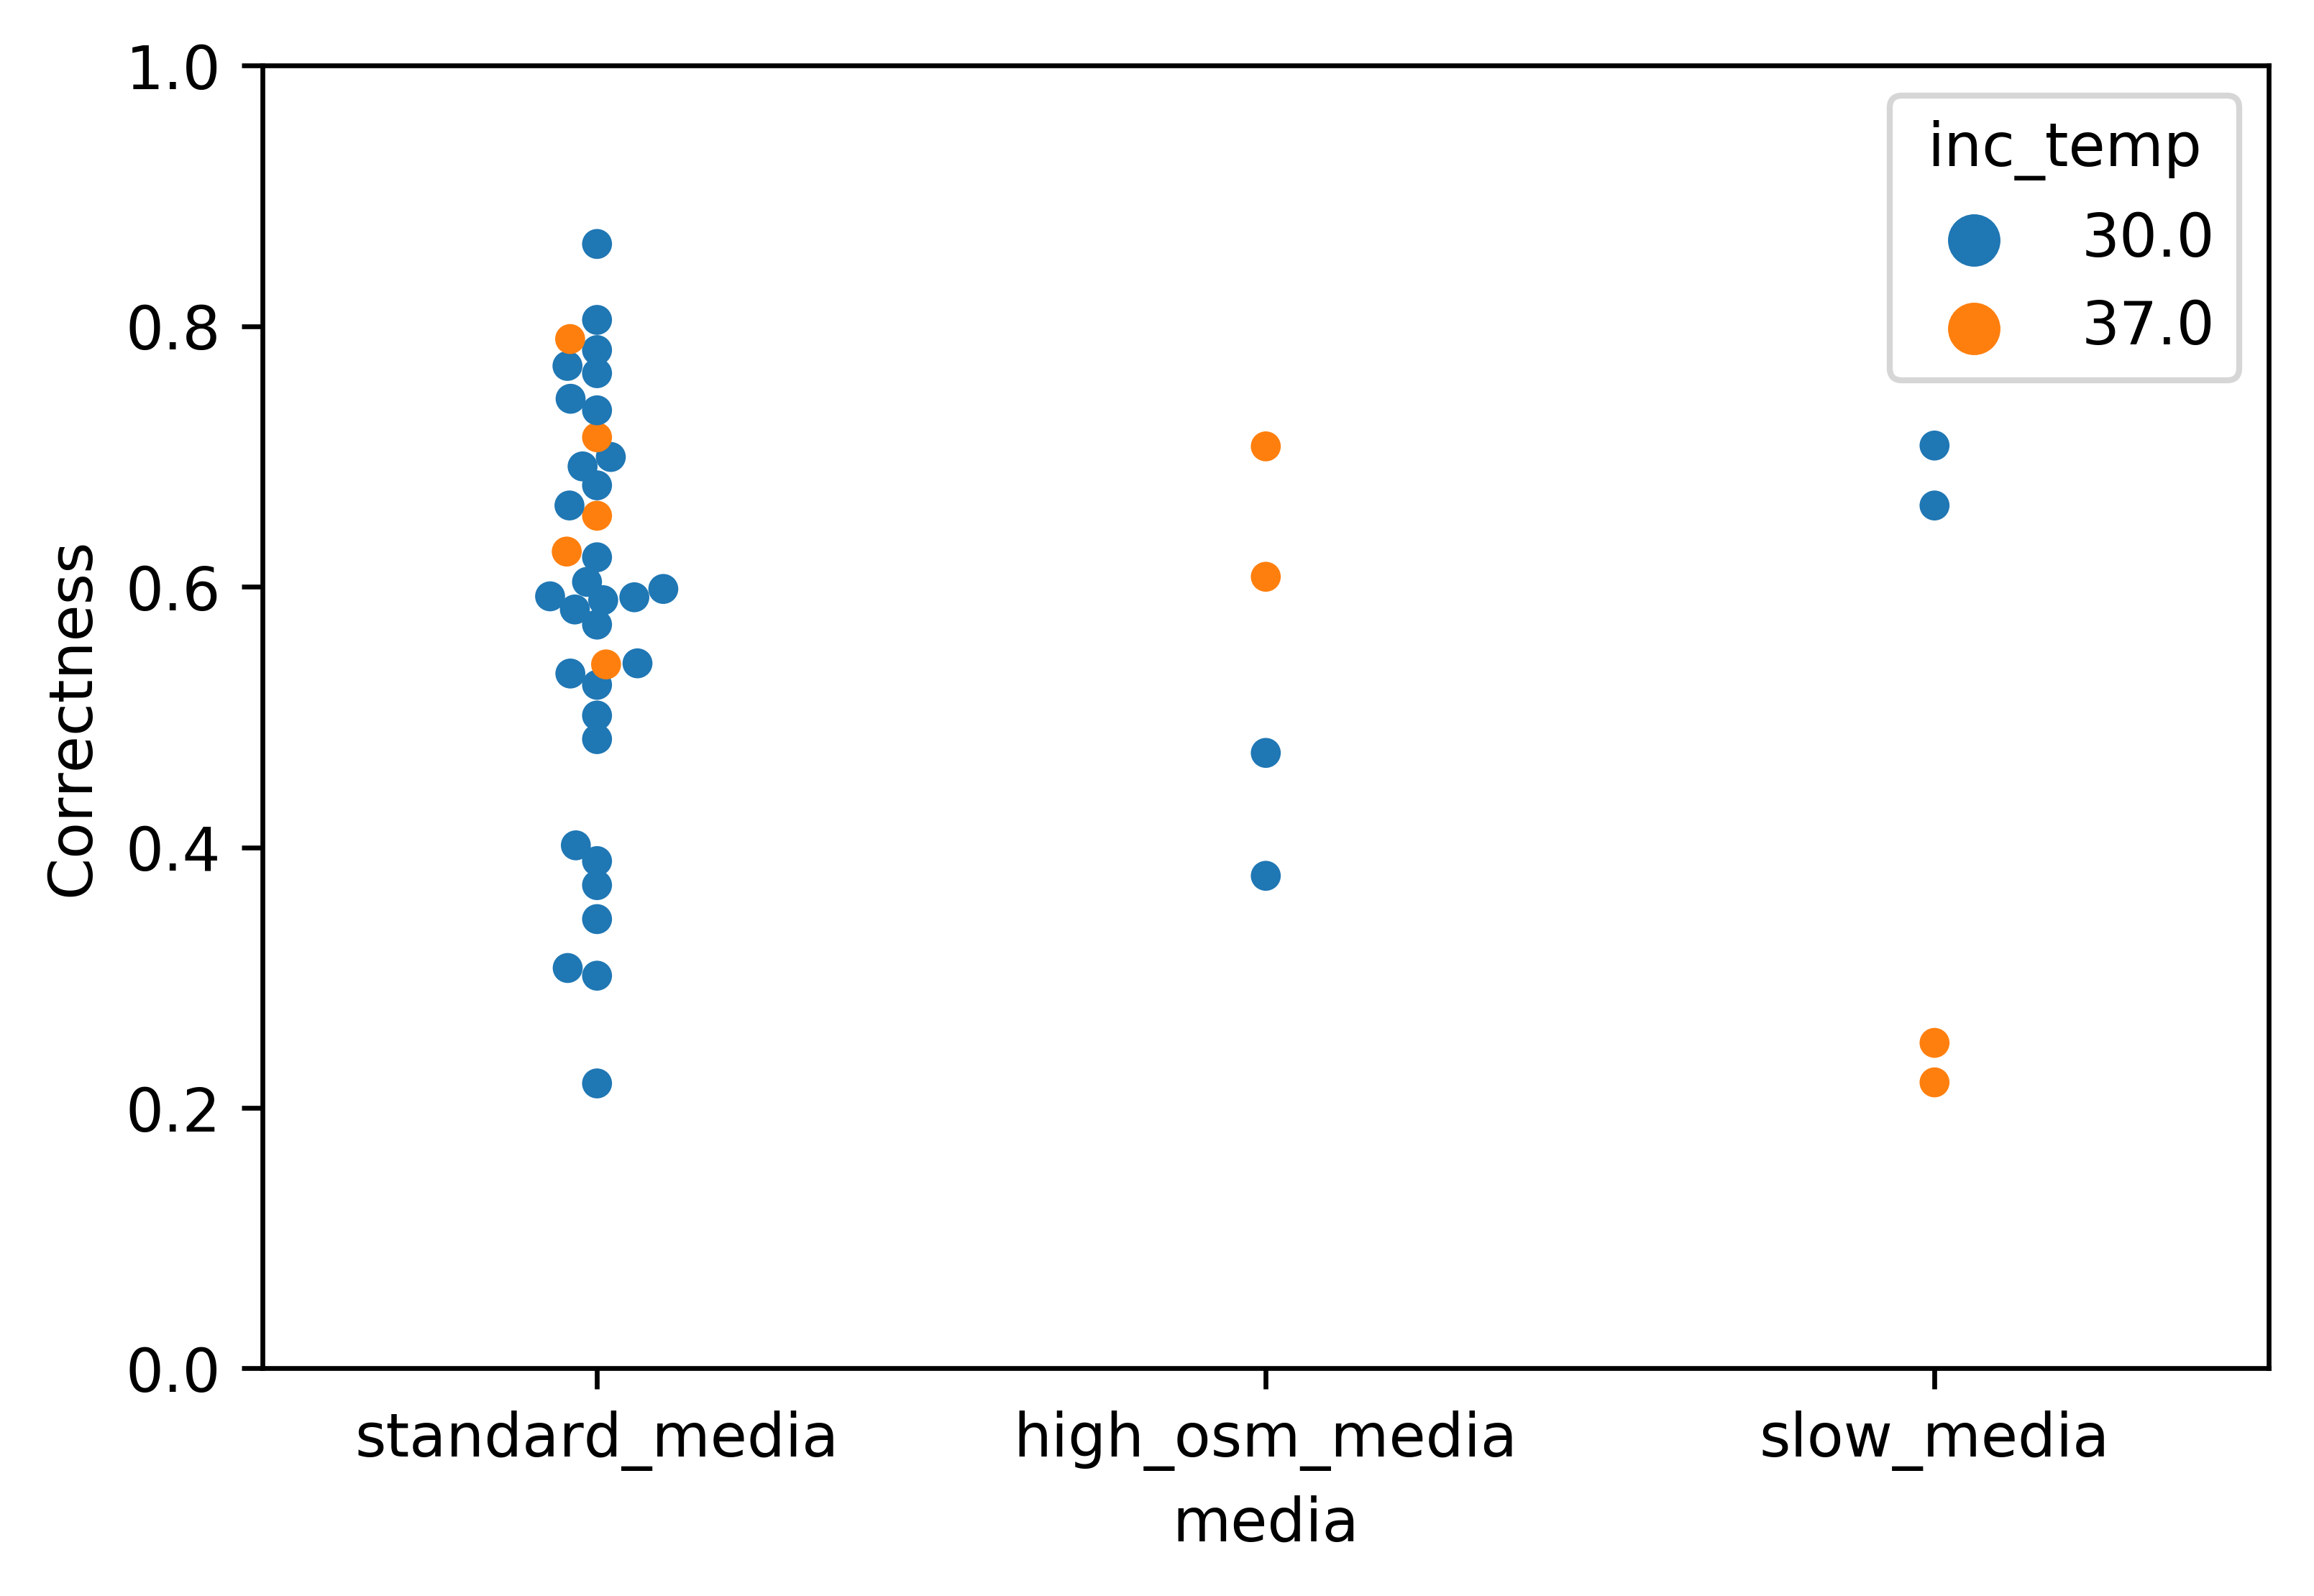

In [6]:
make_plot("AND")
# make_plot_od("AND")
# make_3D_plot("AND")

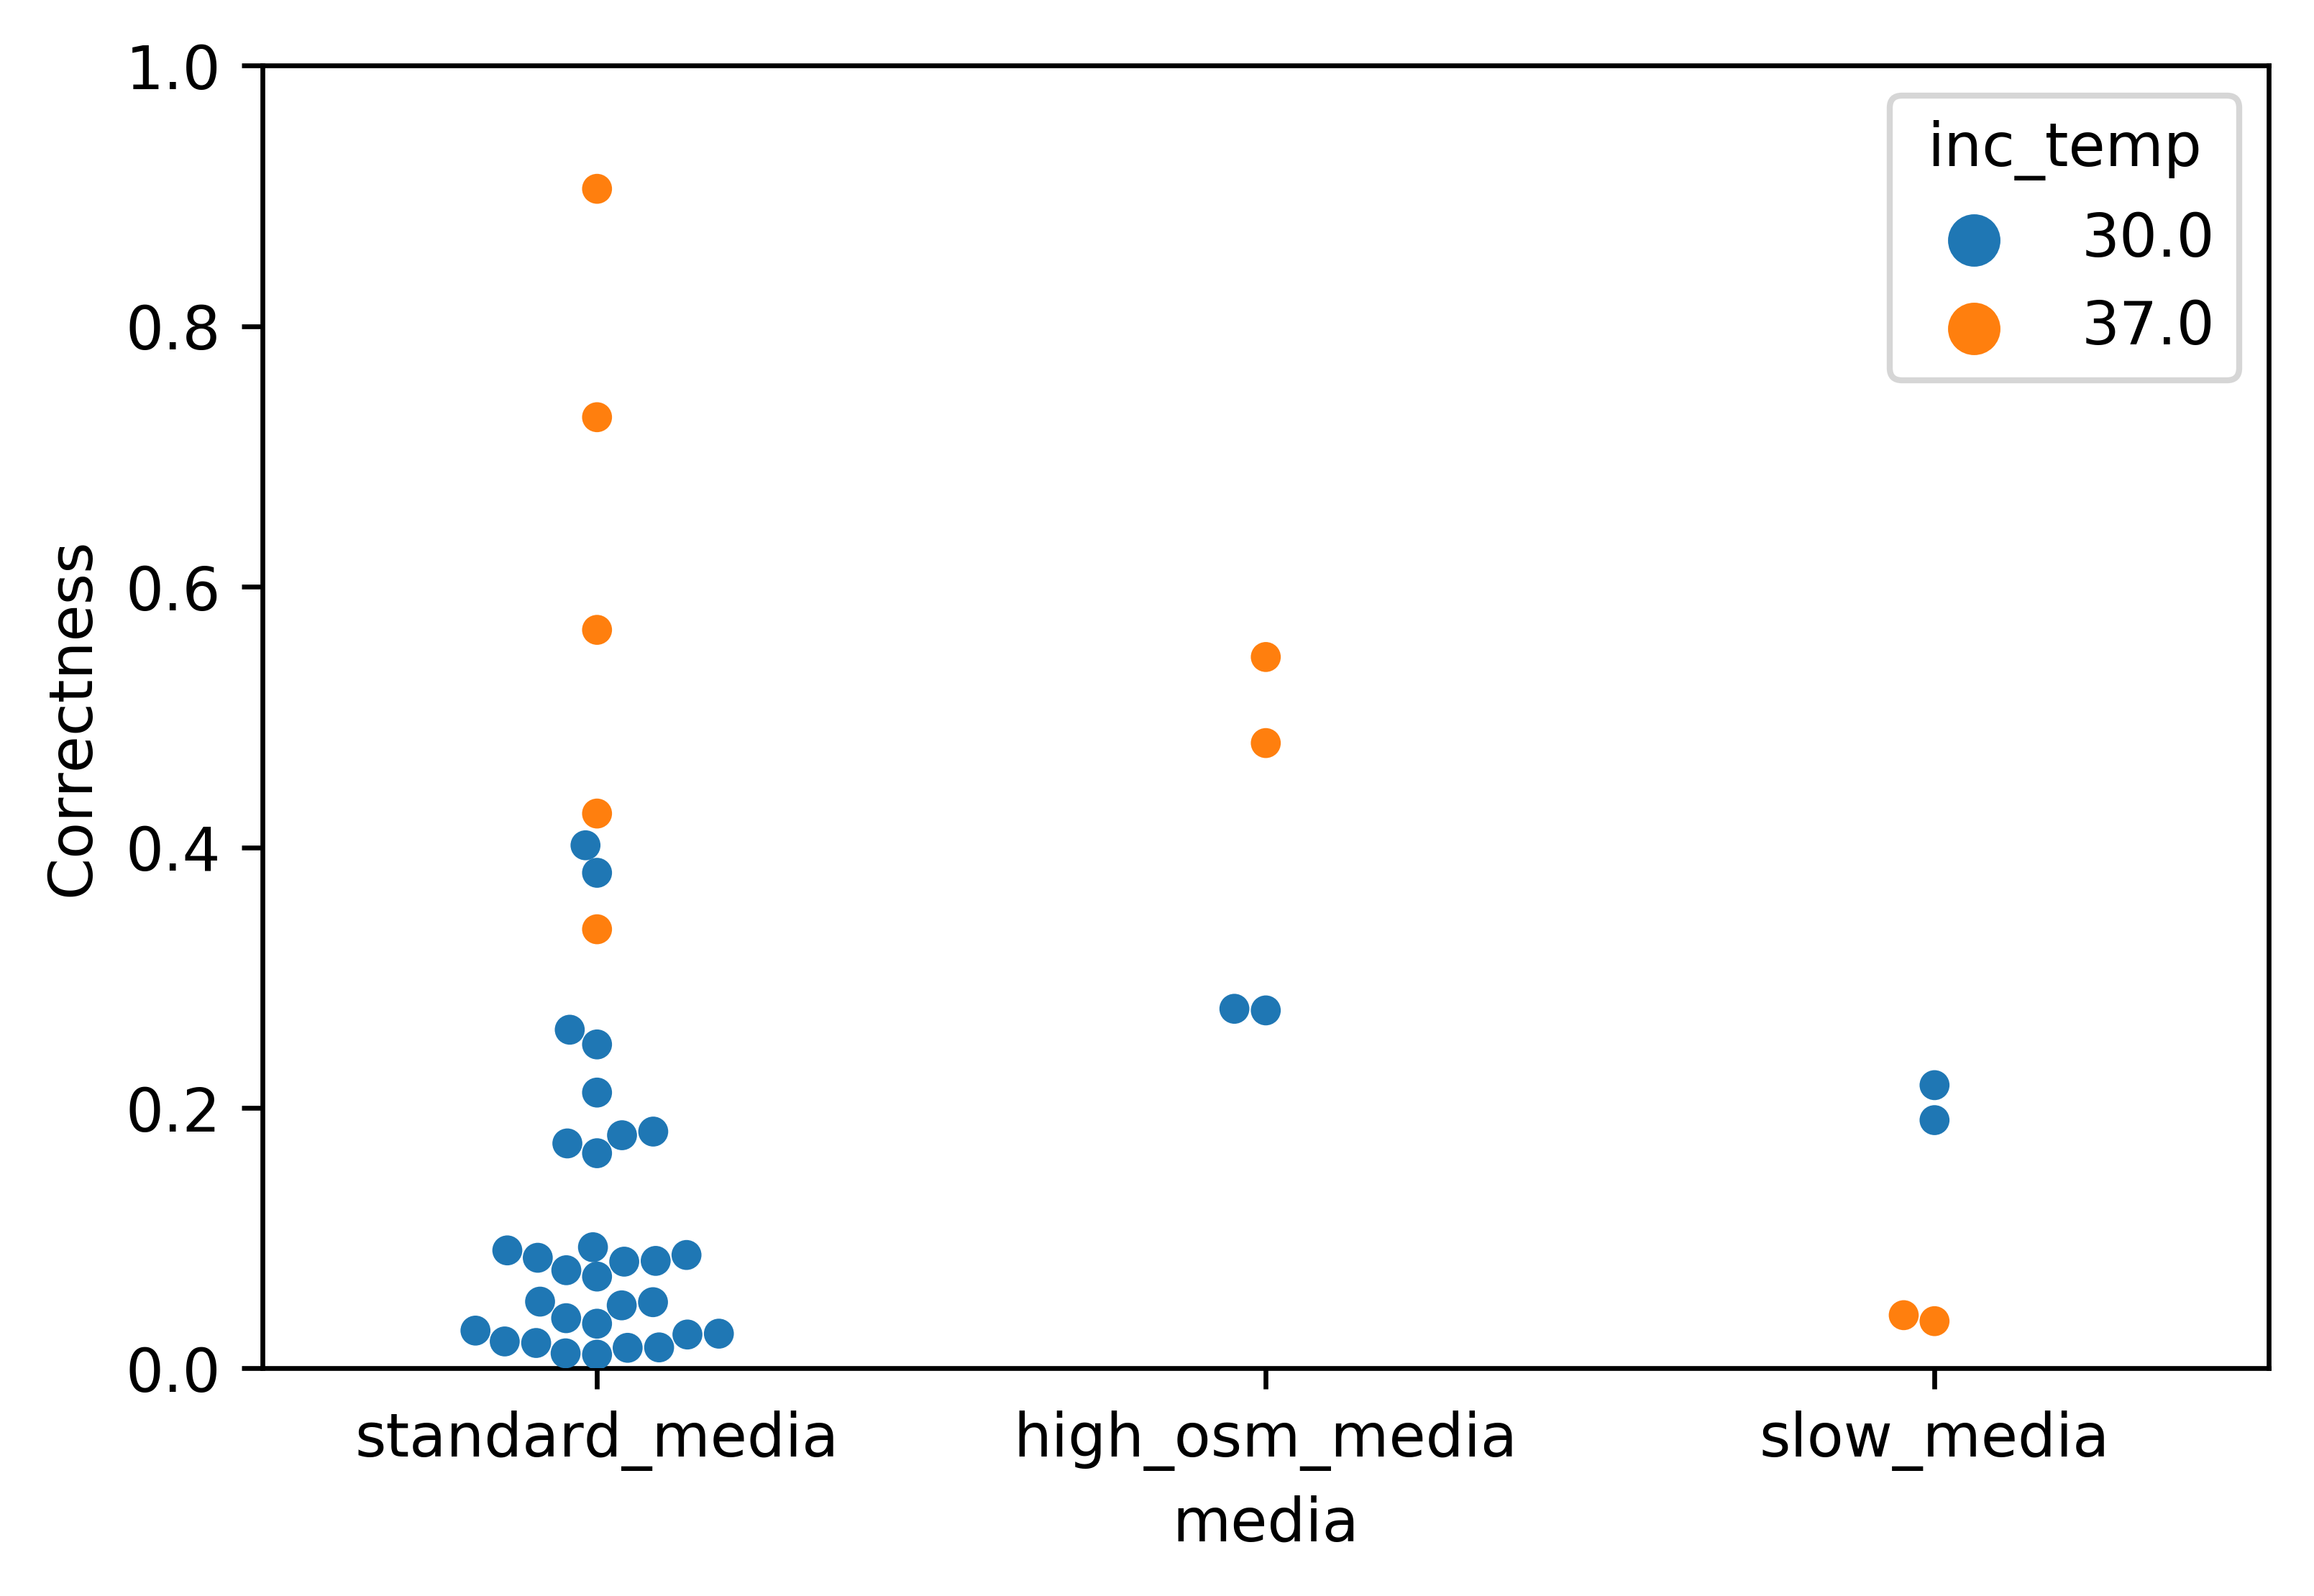

In [7]:
make_plot("NAND")
# make_plot_od("NAND")
# make_3D_plot("NAND")

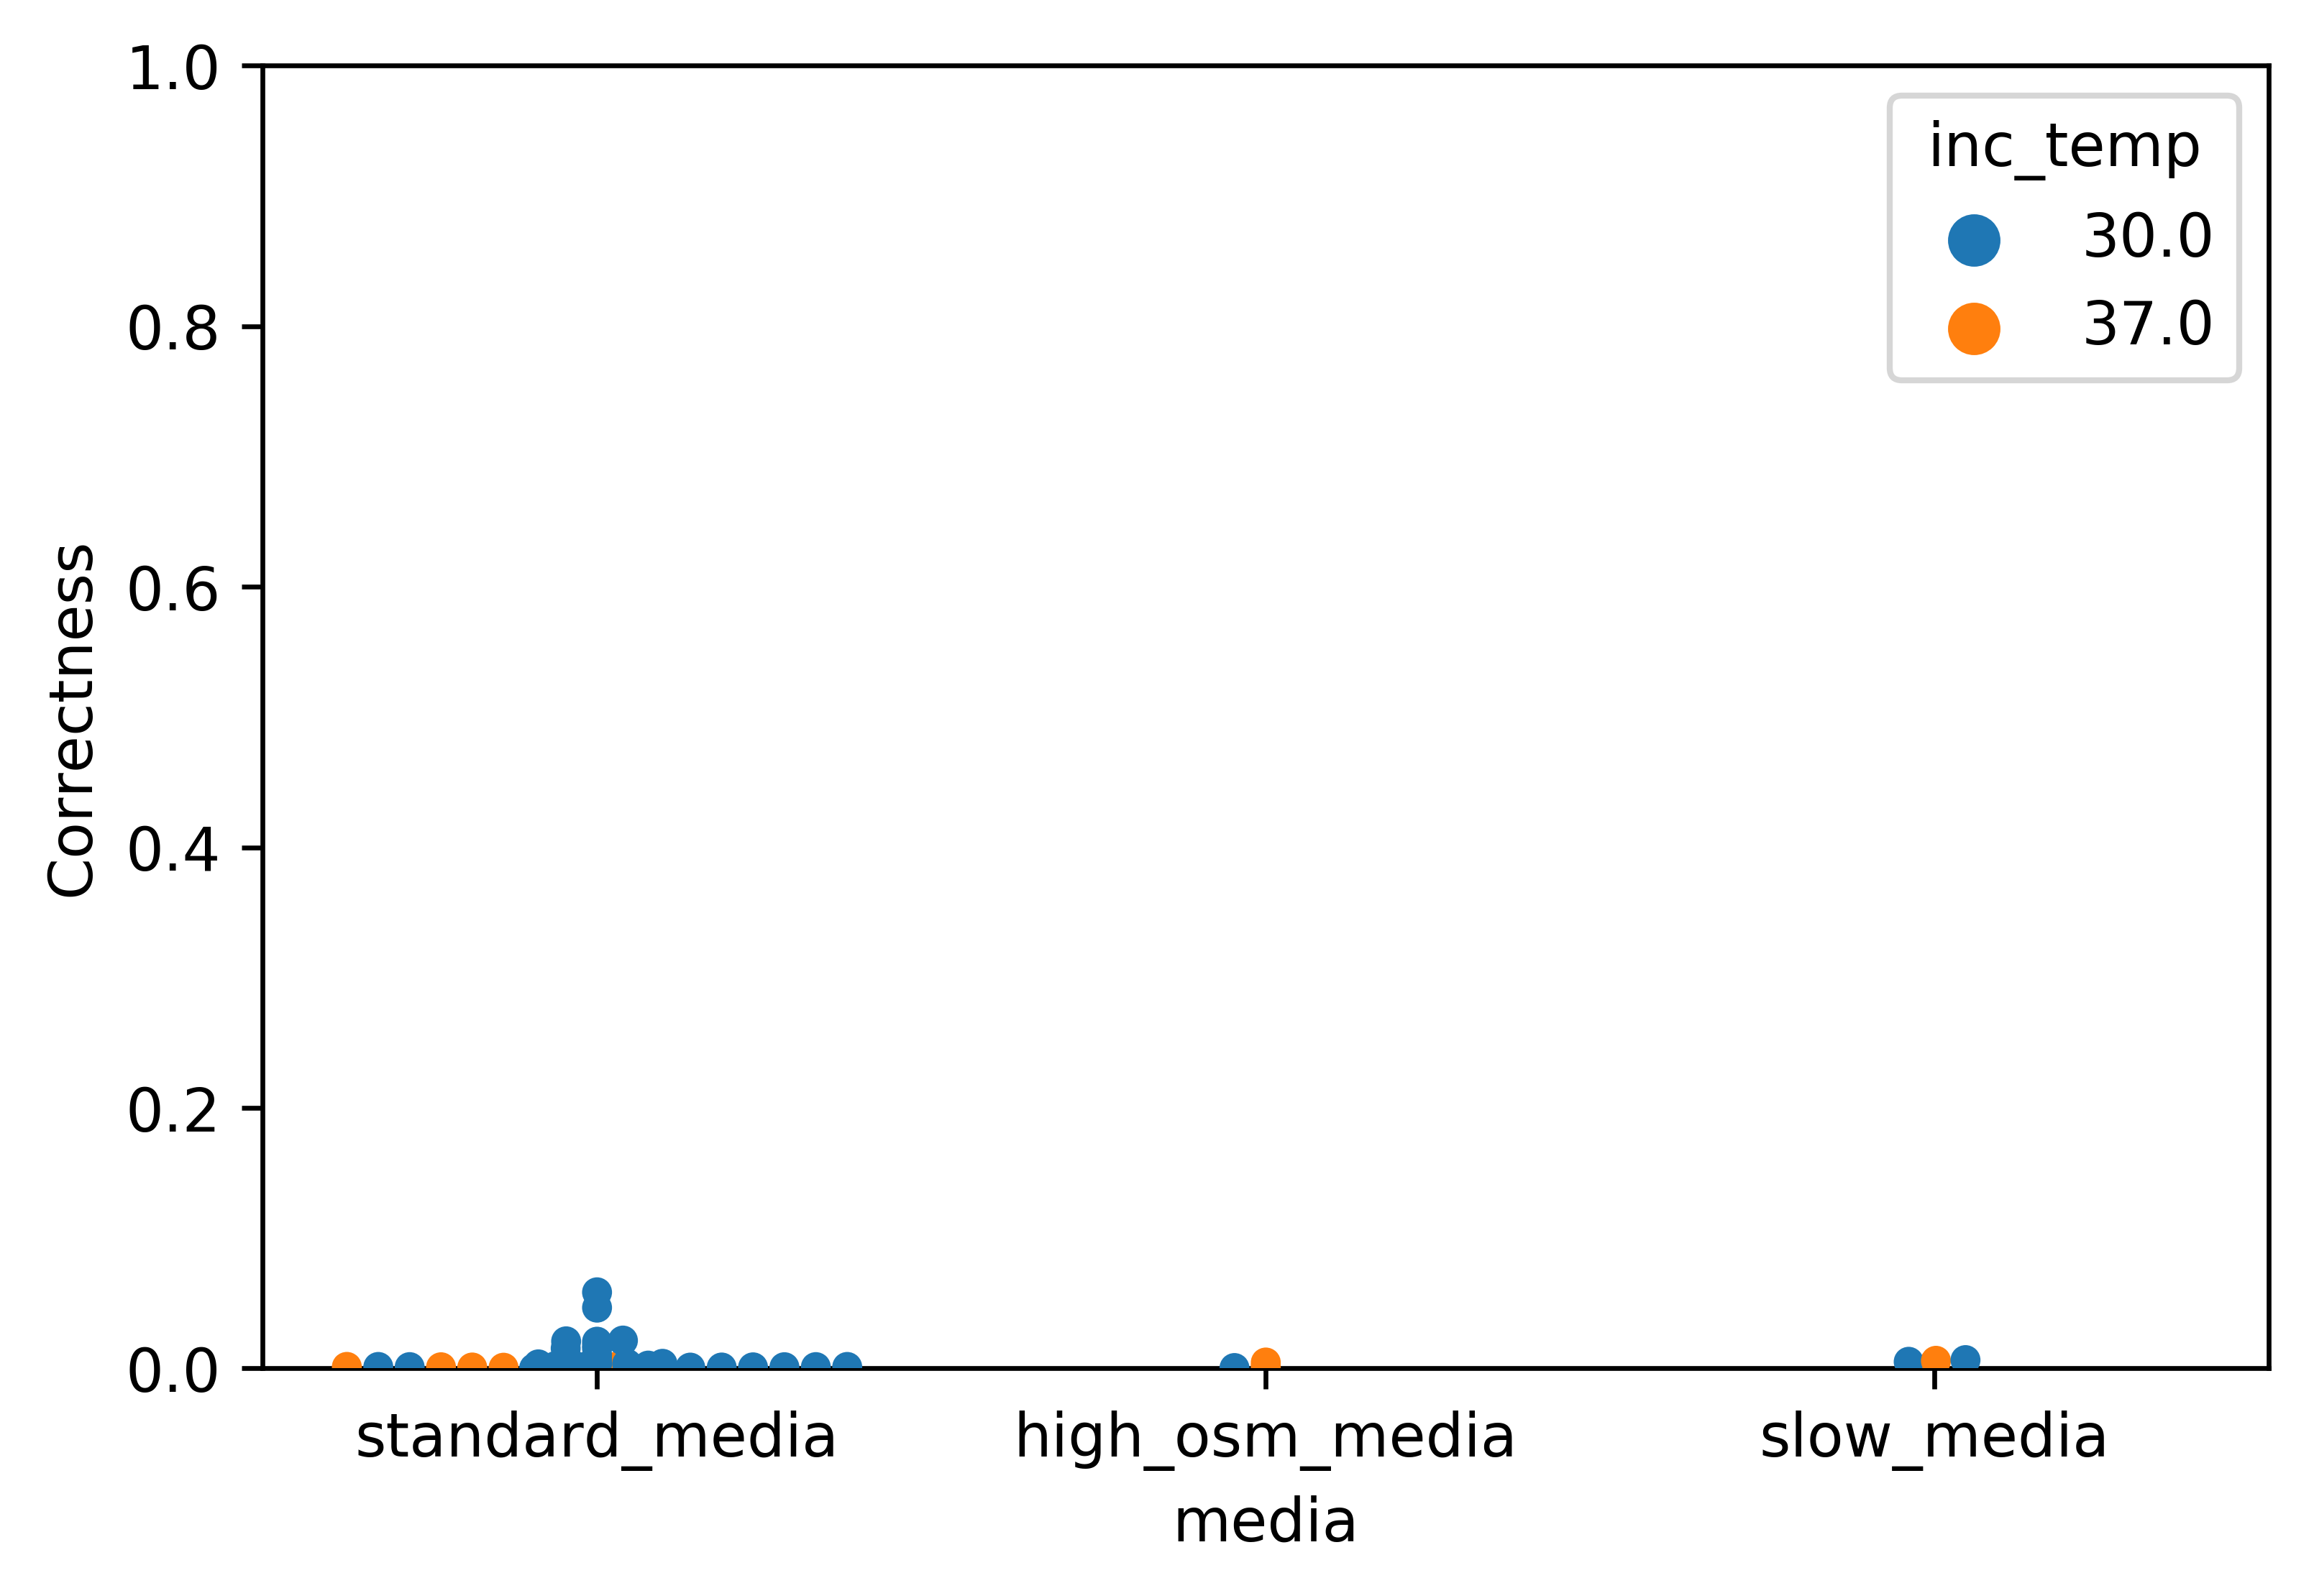

In [8]:
make_plot("OR")
# make_plot_od("OR")
# make_3D_plot("OR")

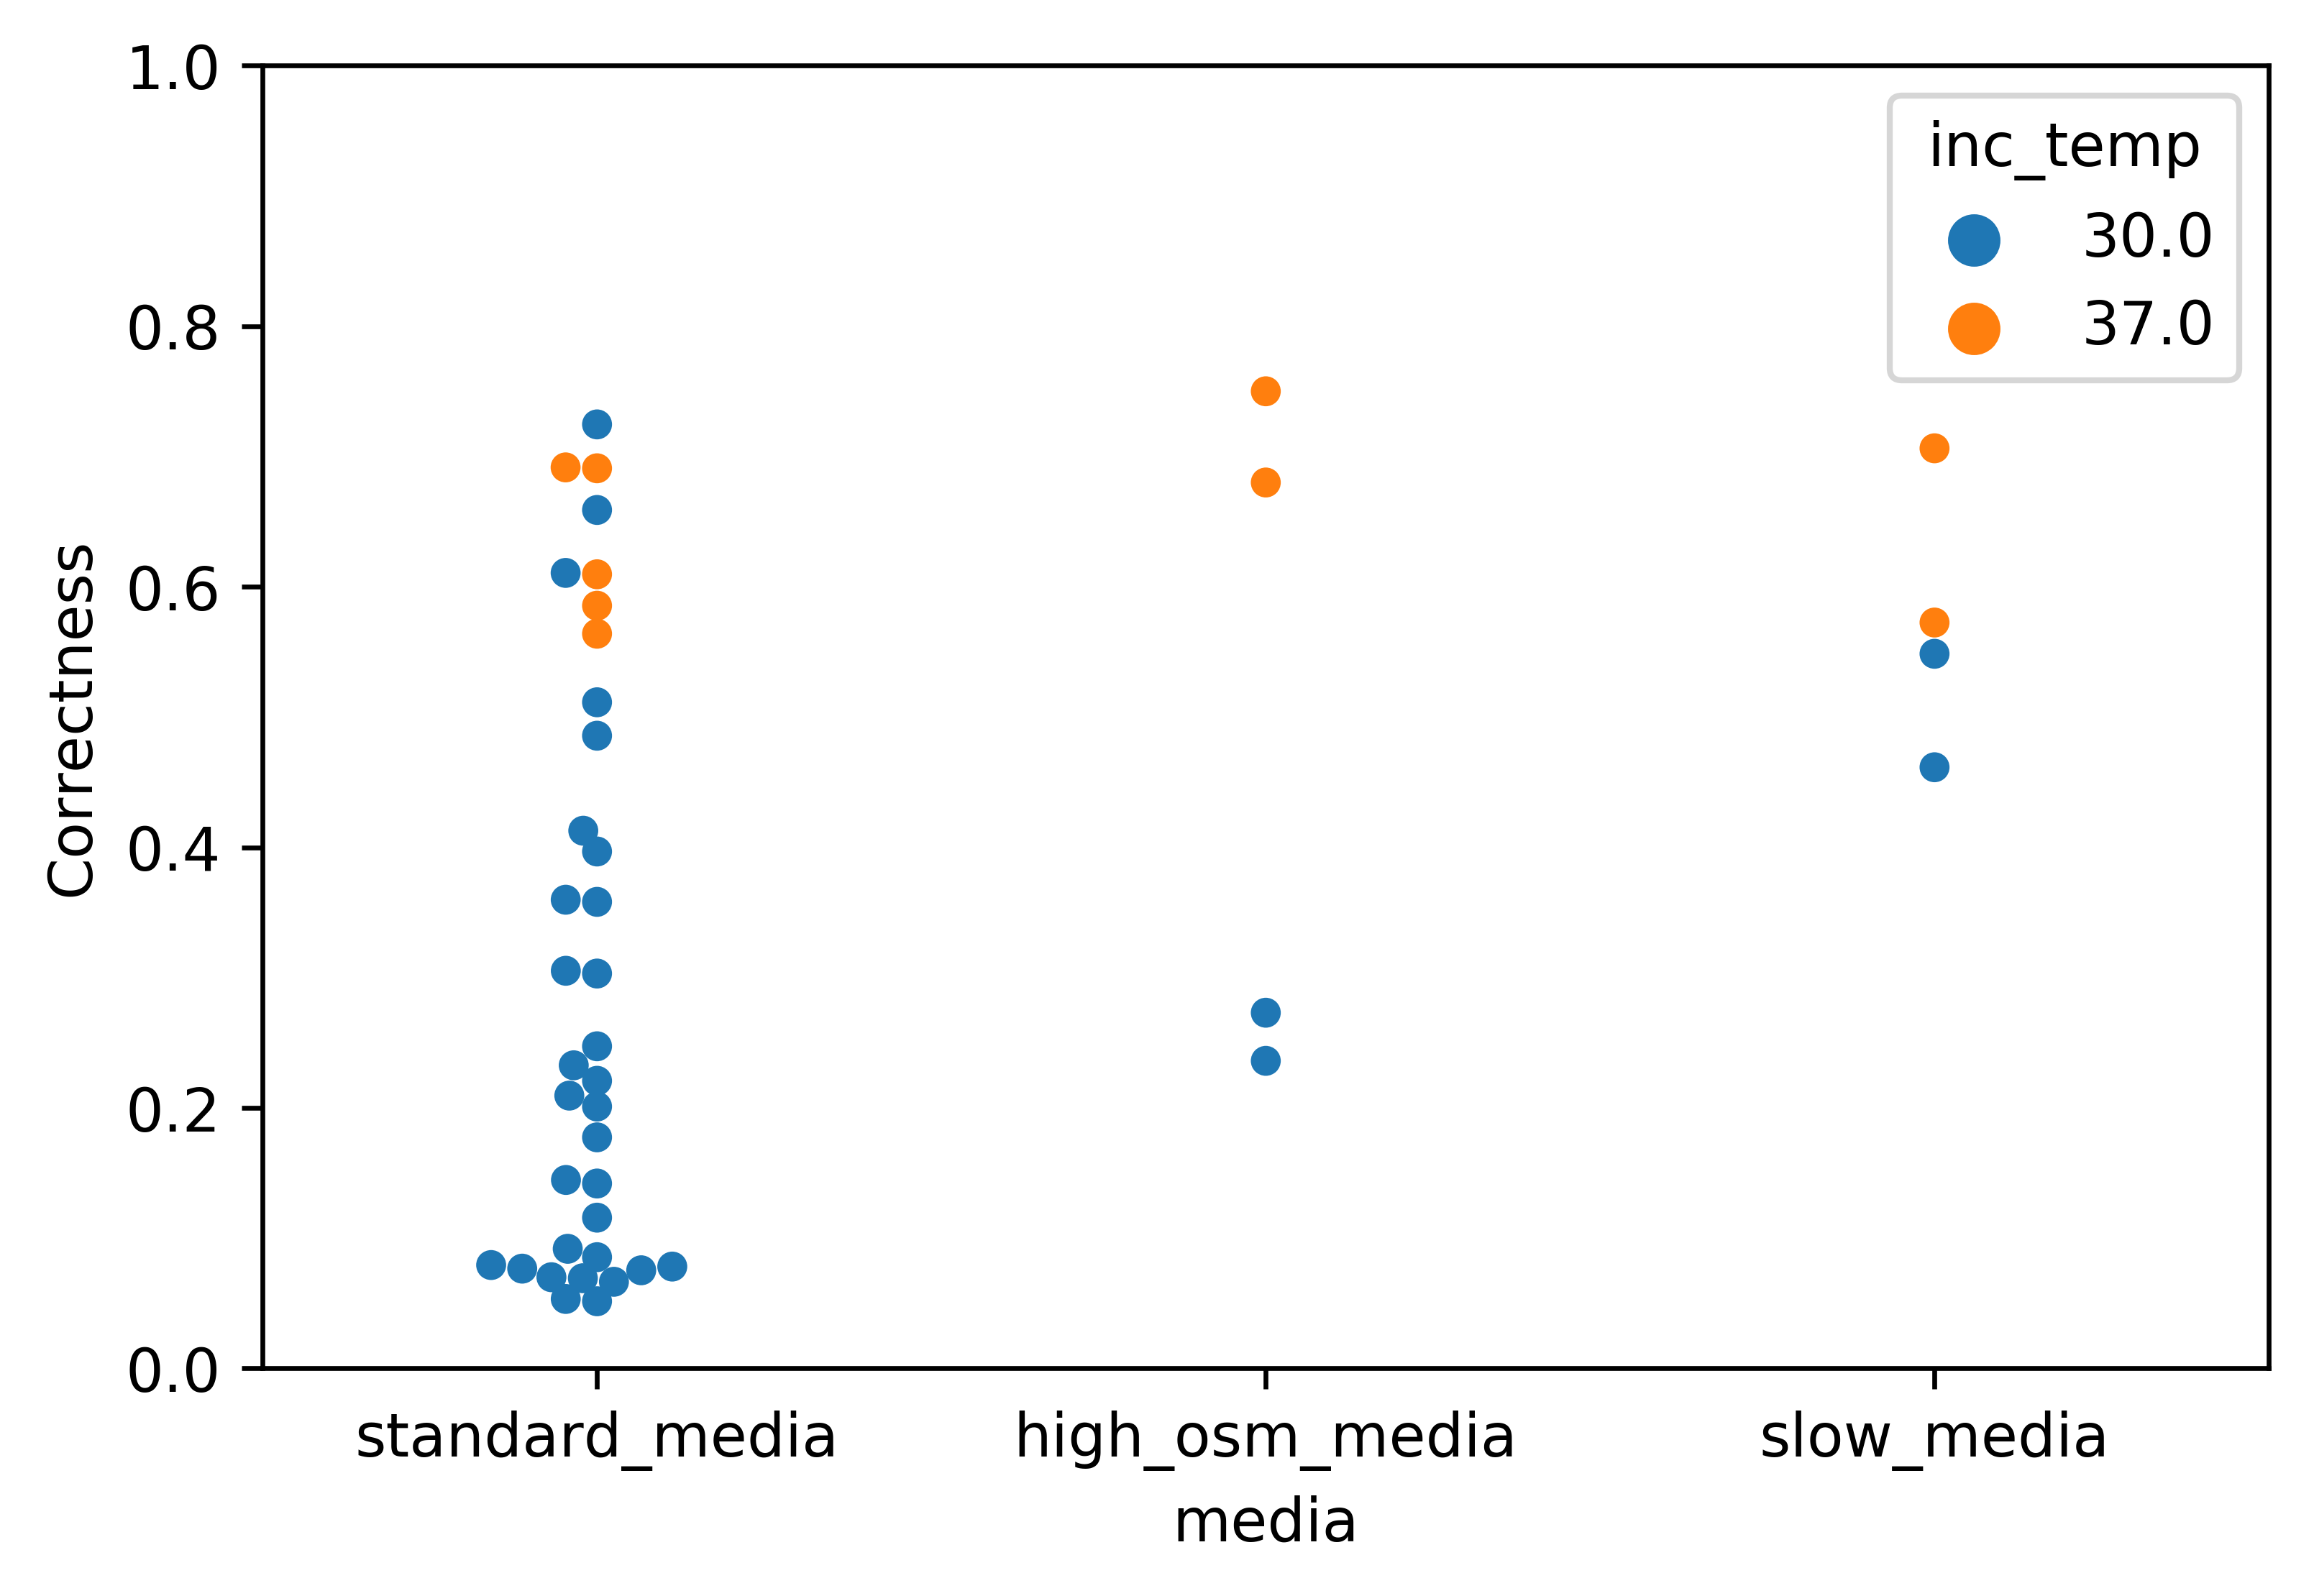

In [9]:
make_plot("NOR")
# make_plot_od("NOR")
# make_3D_plot("NOR")

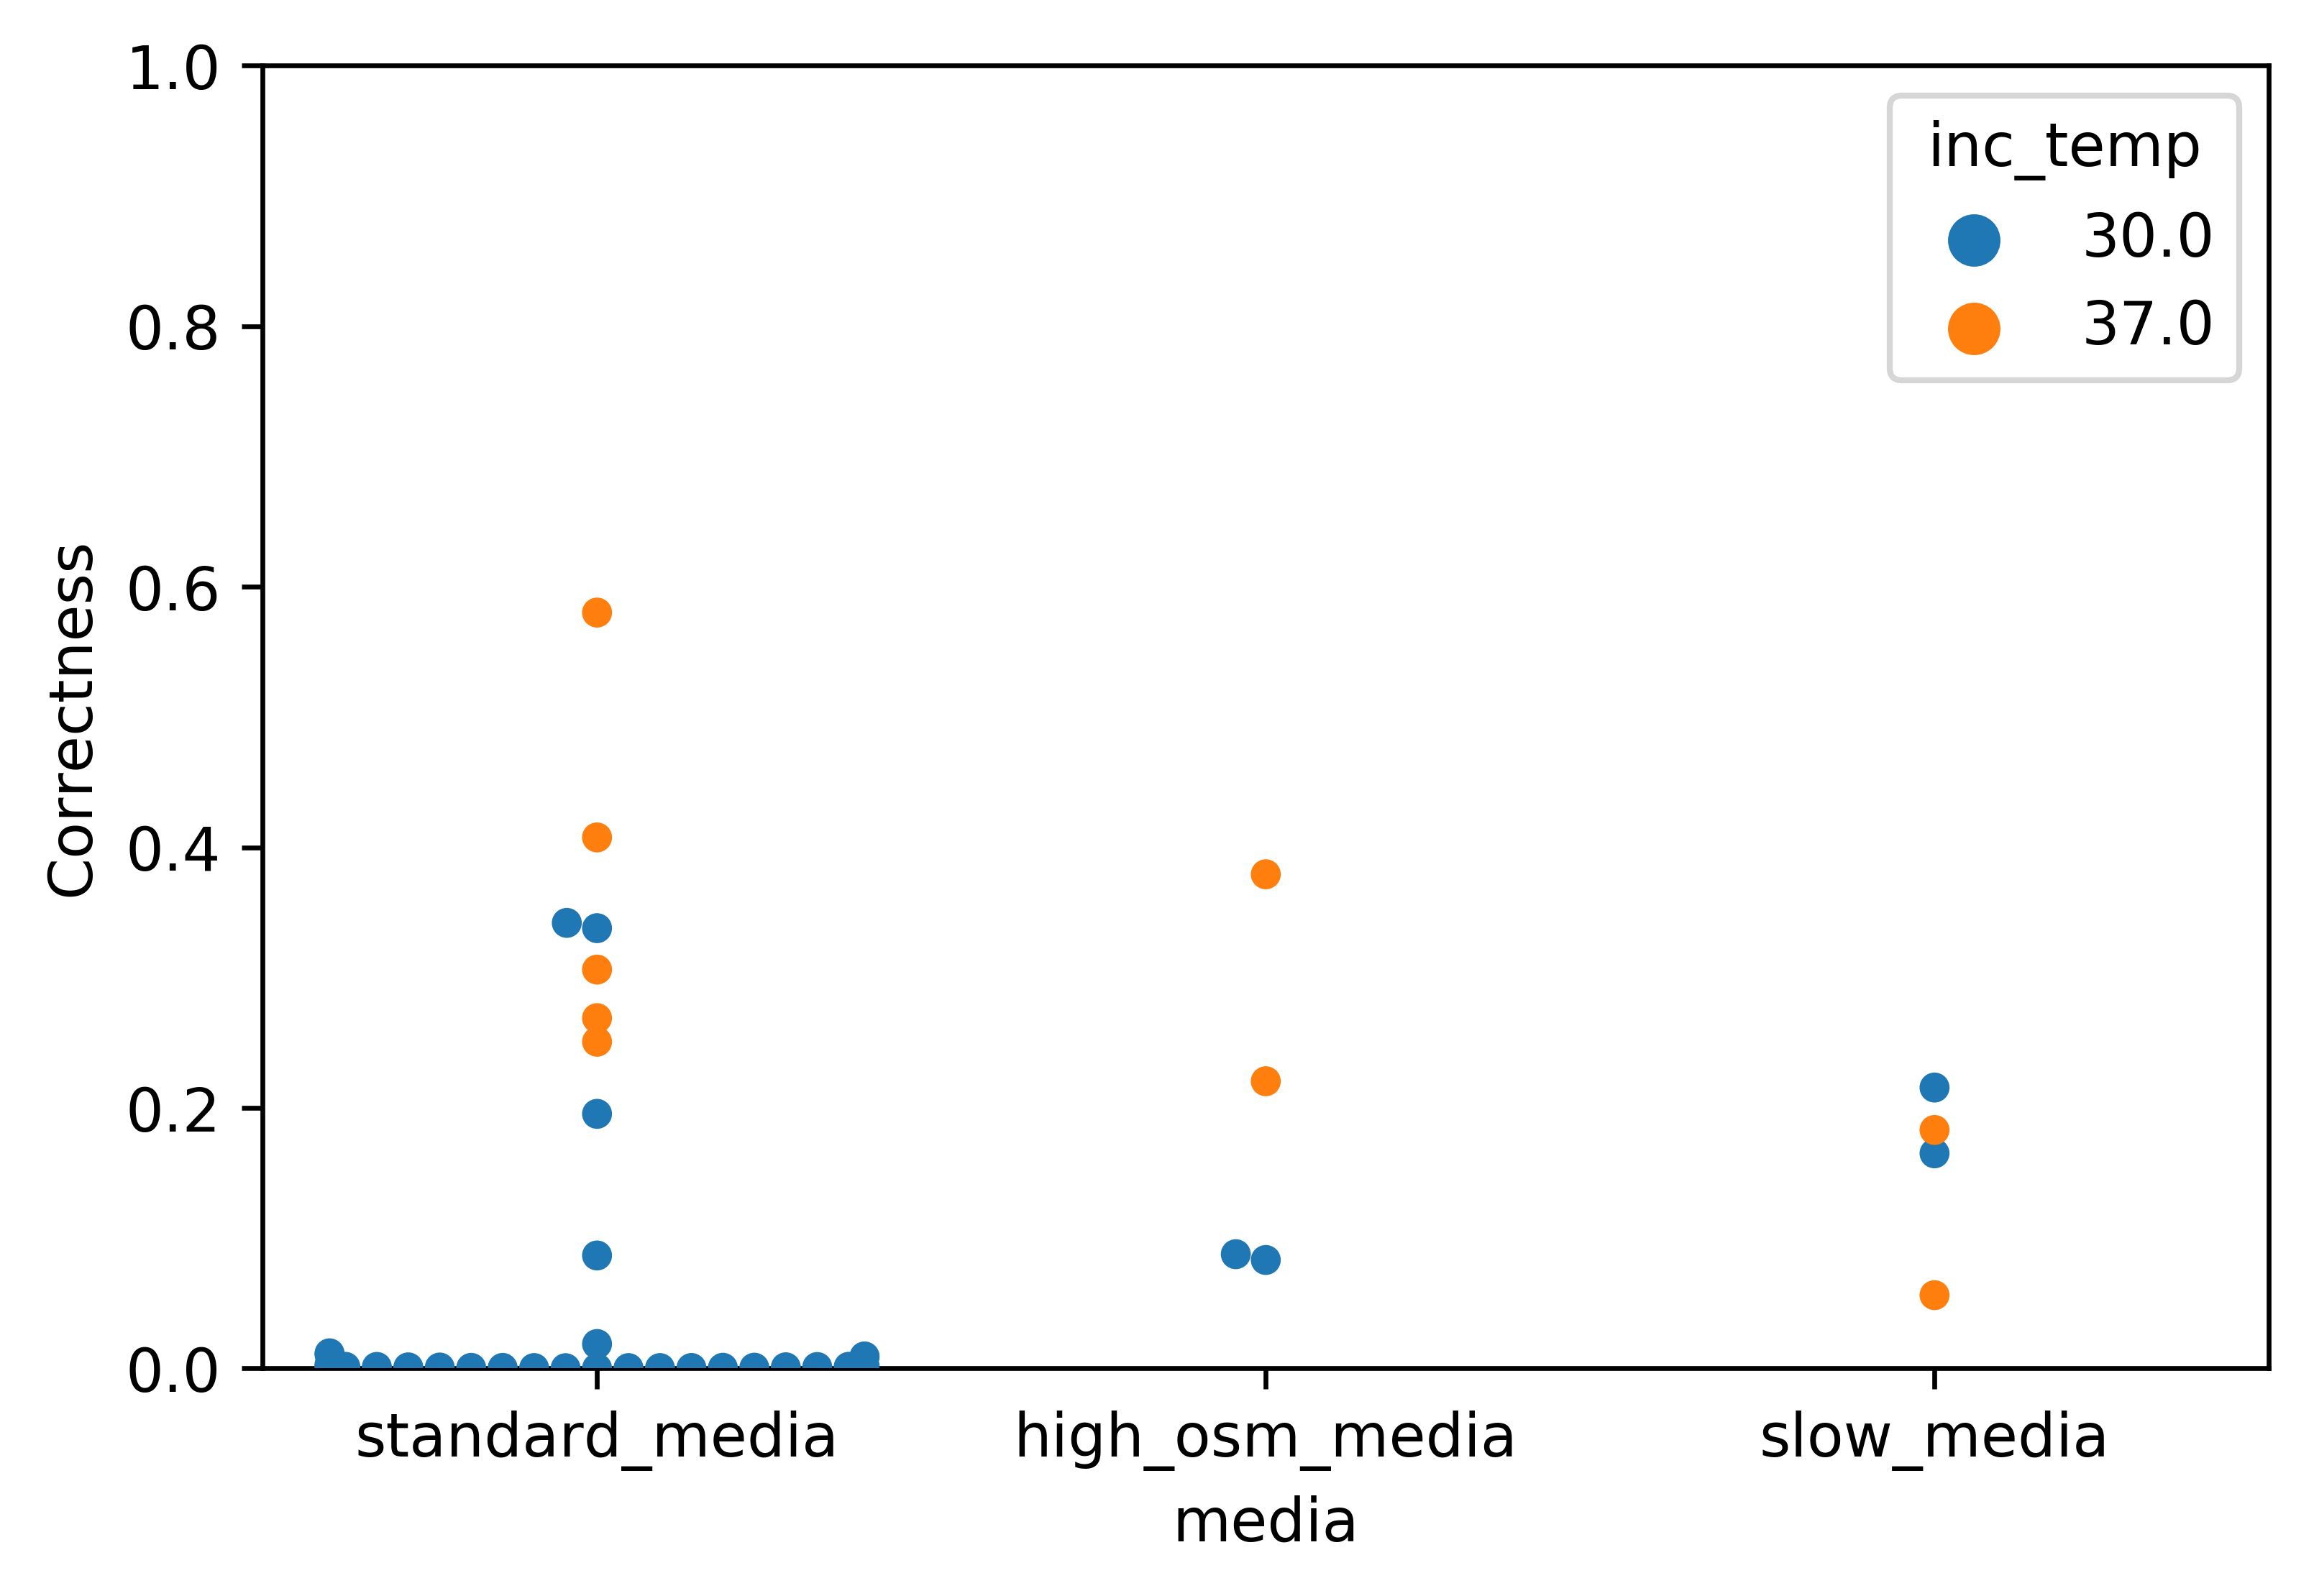

In [10]:
make_plot("XOR")
# make_plot_od("XOR")
# make_3D_plot("XOR")

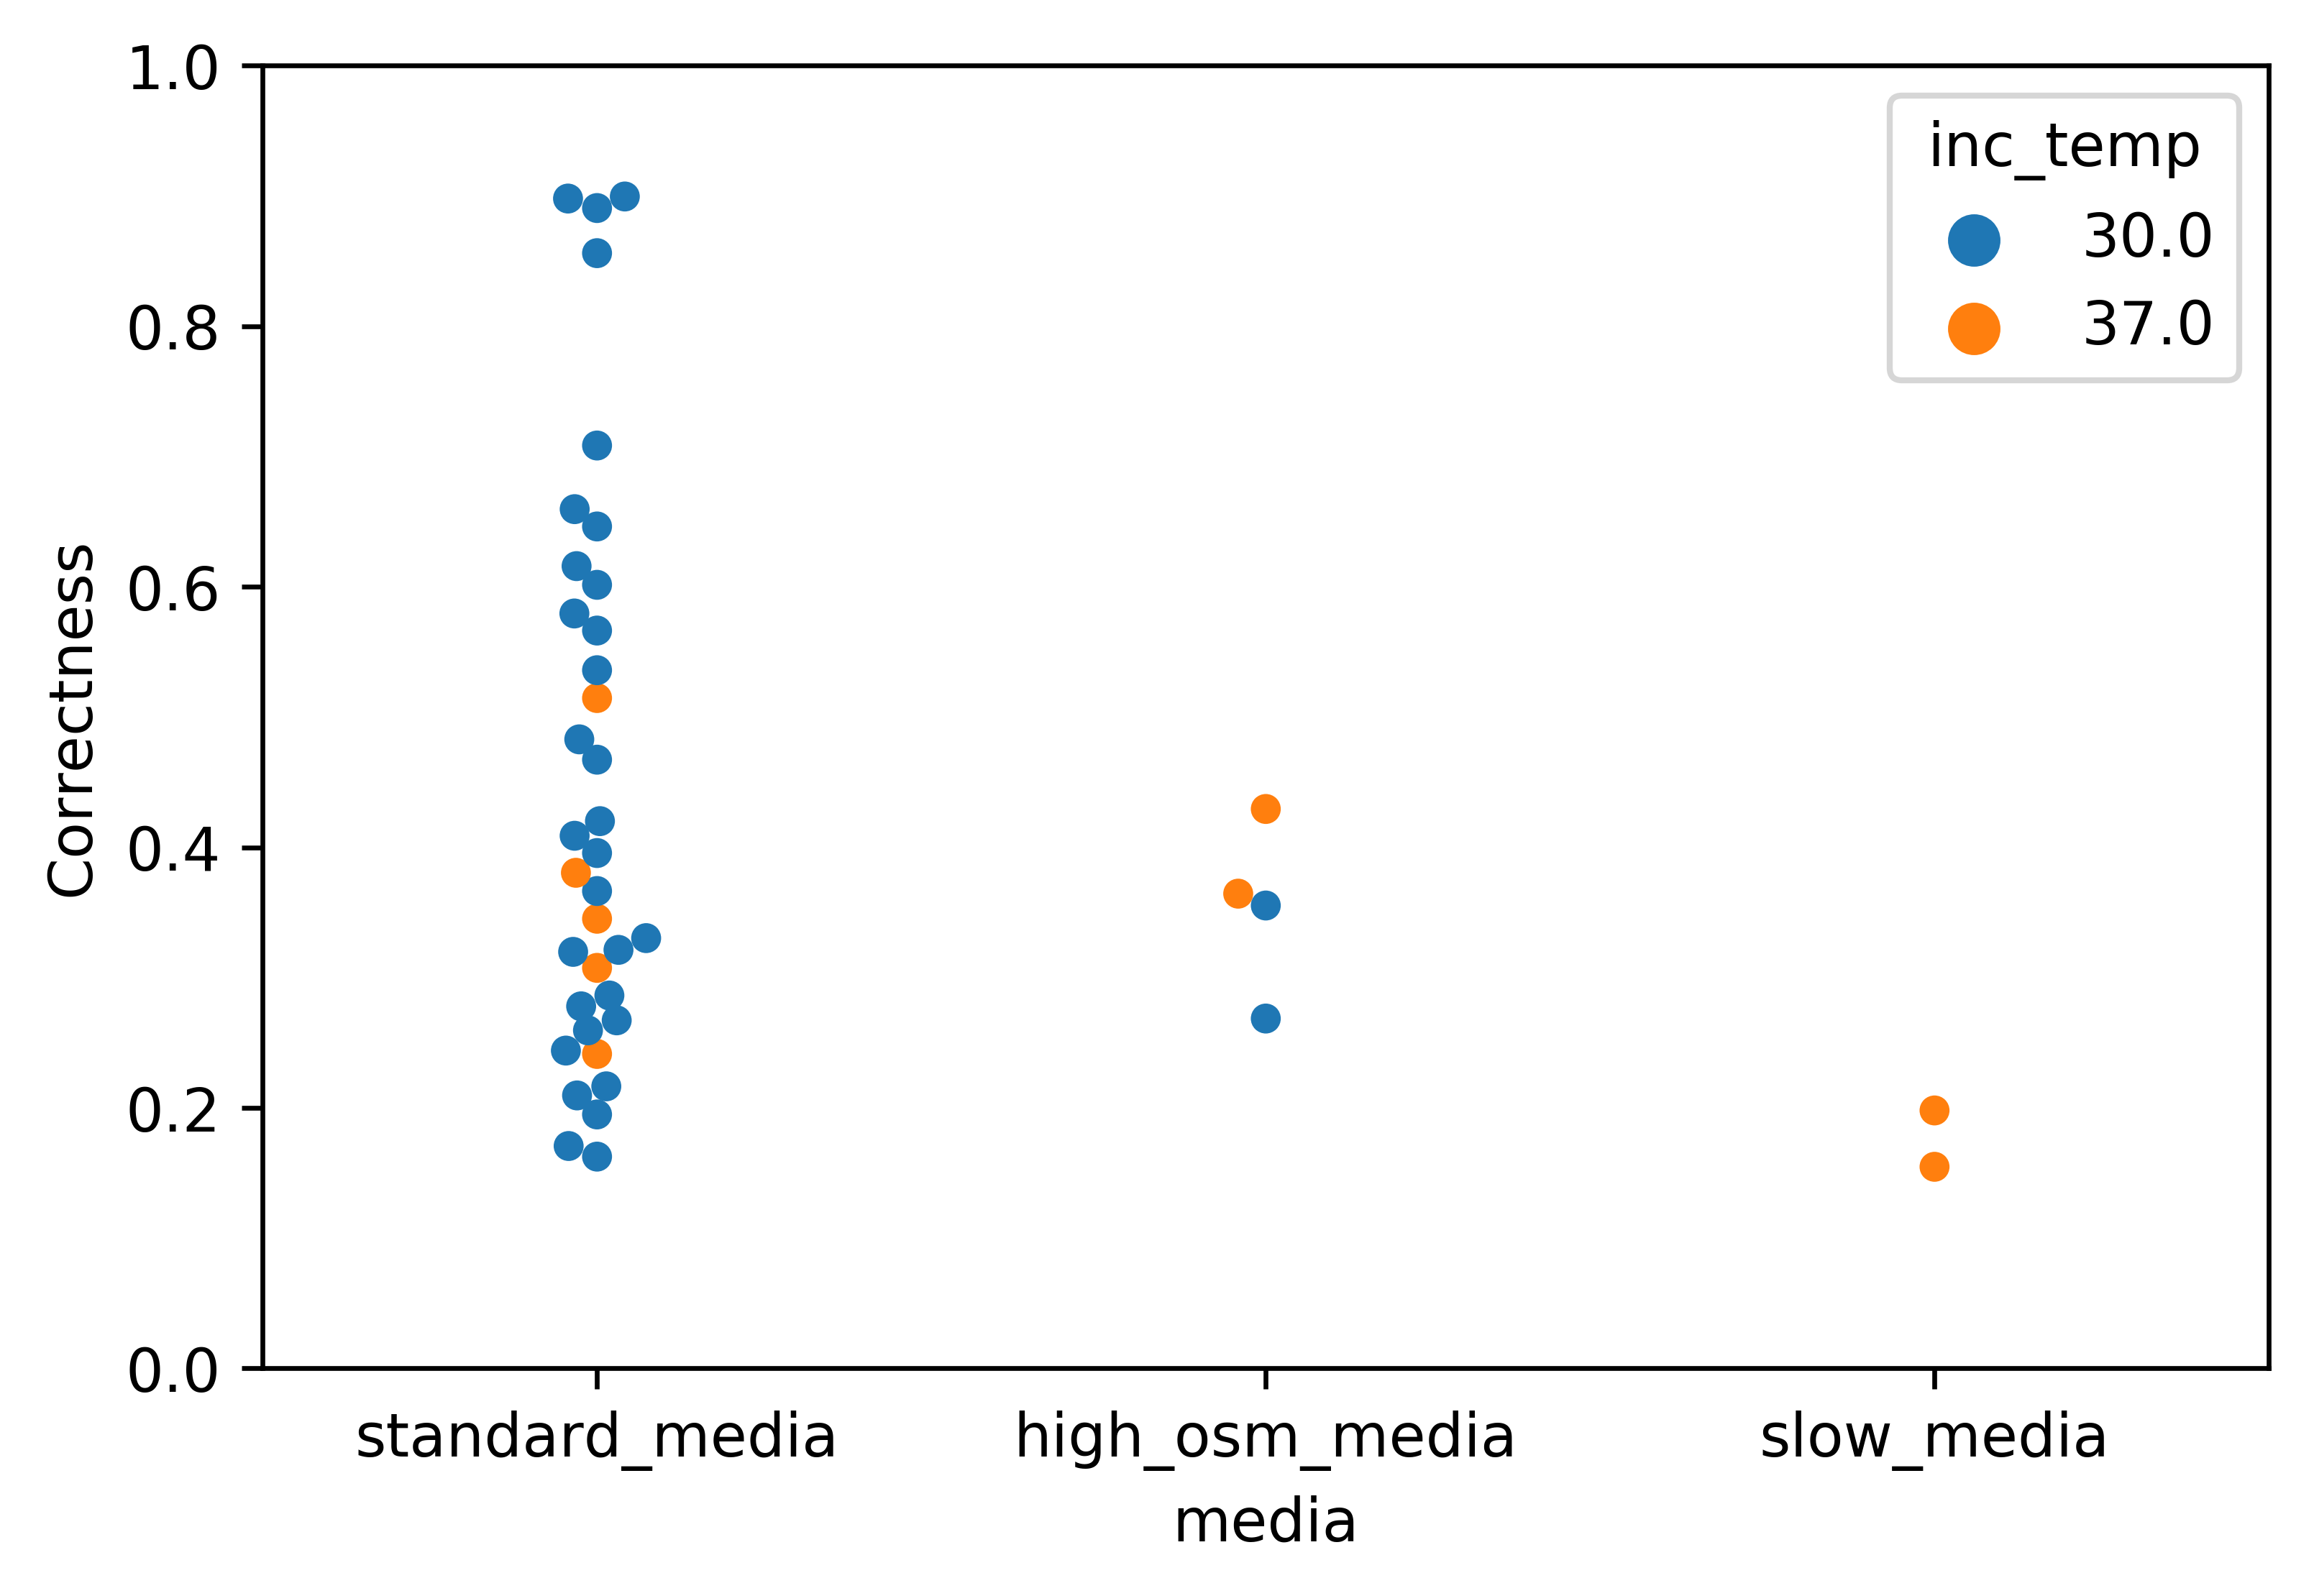

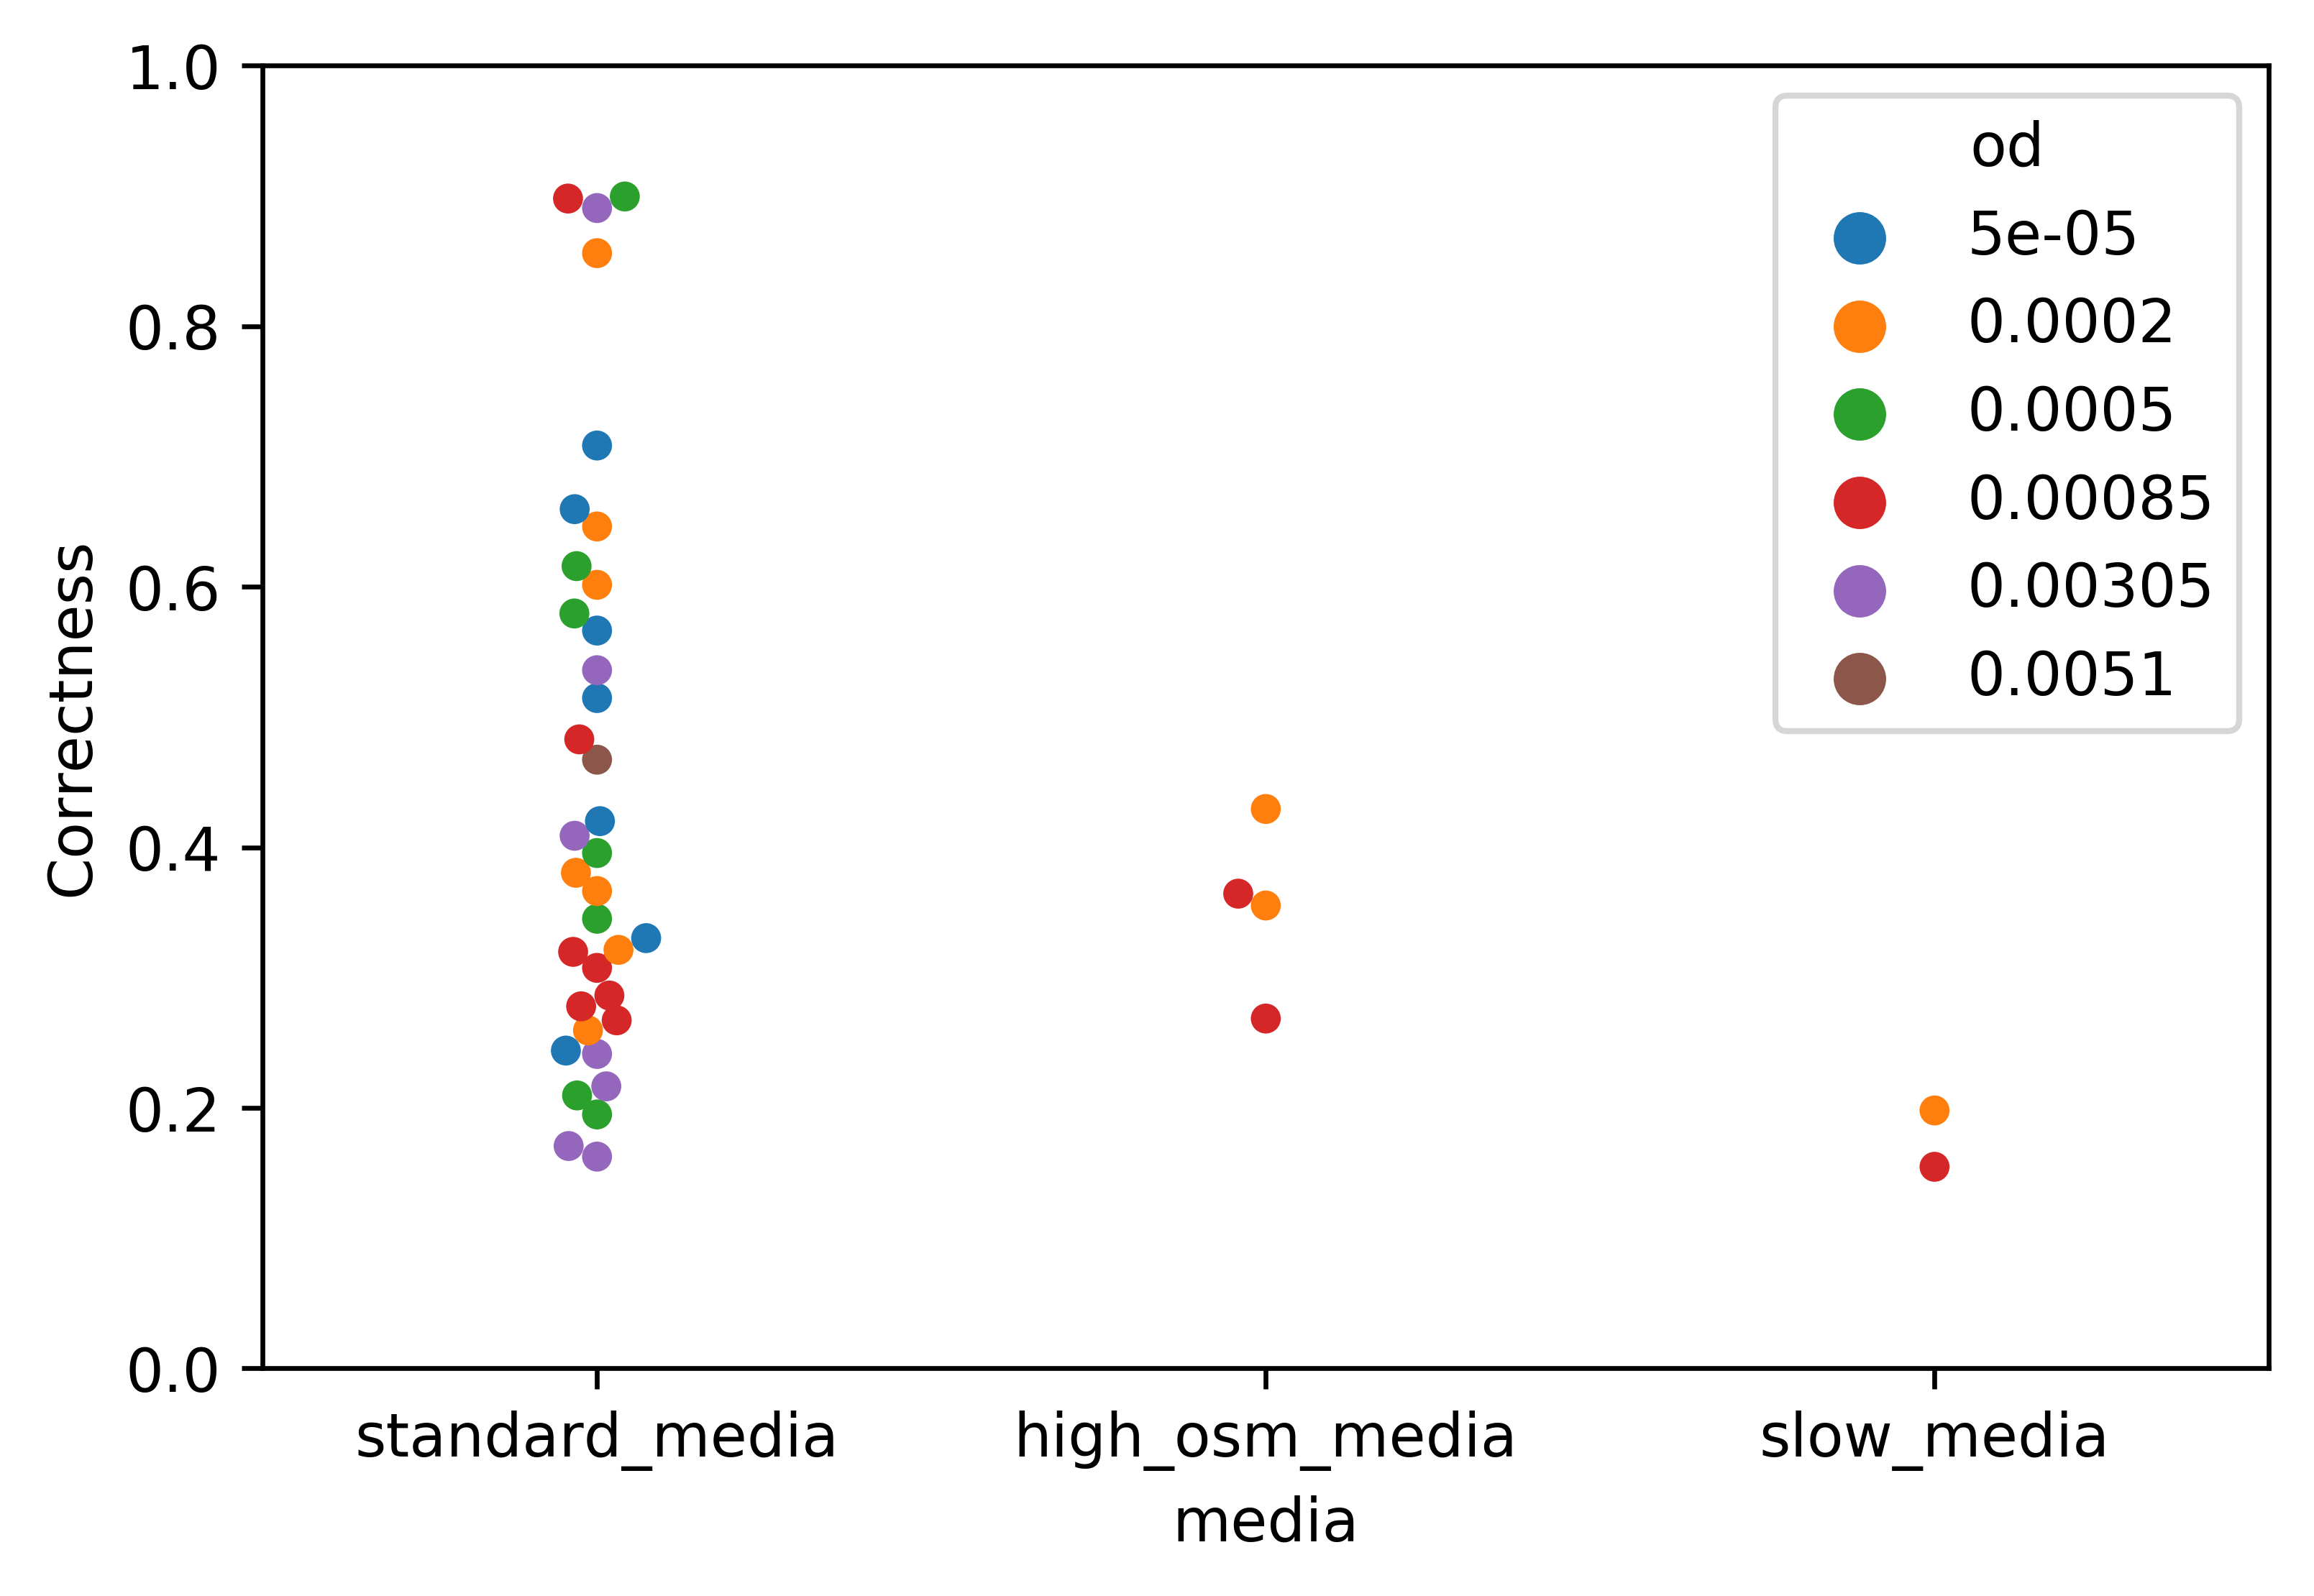

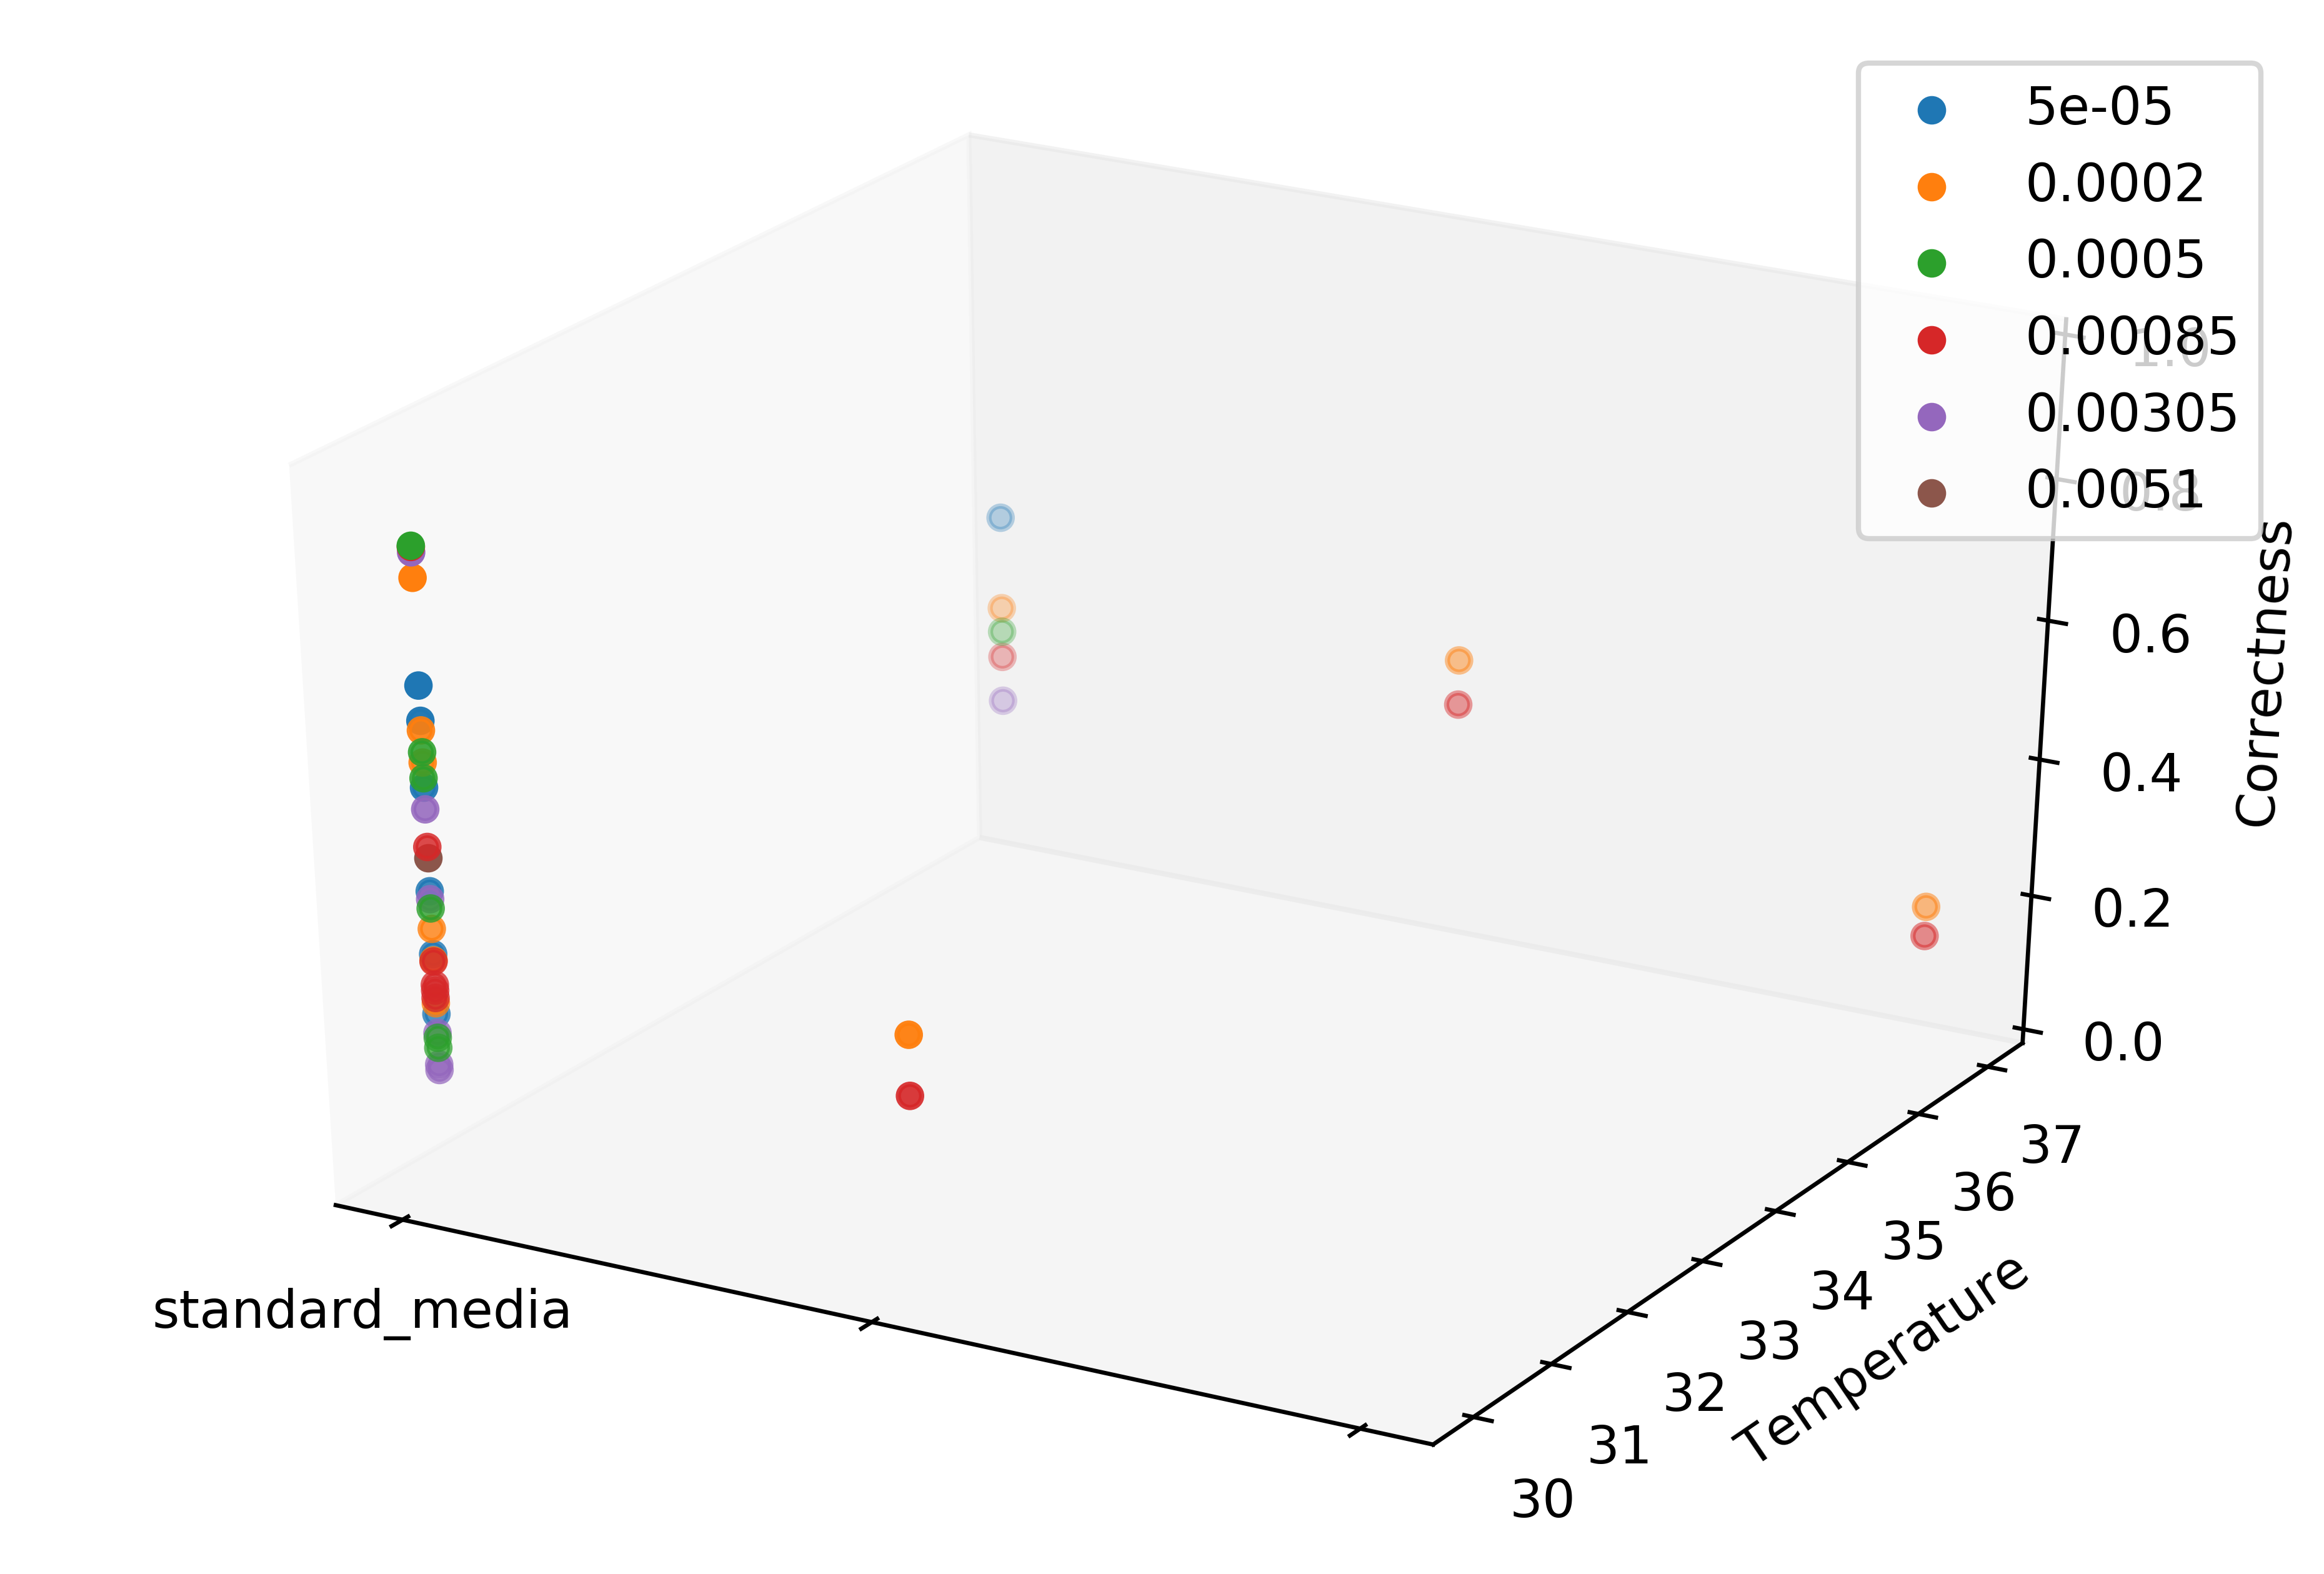

In [40]:
make_plot("XNOR")
# make_plot_od("XNOR")
# make_3D_plot("XNOR")

In [12]:
conditions2=['media', 'inc_temp', 'od']
circuit_score_df_prod_inc = circuit_score_df_prod.groupby(conditions2+['gate'])[correctness_col].agg(np.mean).reset_index()
HTML(circuit_score_df_prod_inc.to_html(index=False))


media,inc_temp,od,gate,mean_correct_classifier_live
high_osm_media,30.0,0.00020,AND,0.472437
high_osm_media,30.0,0.00020,NAND,0.274781
high_osm_media,30.0,0.00020,NOR,0.236056
high_osm_media,30.0,0.00020,OR,0.000249
high_osm_media,30.0,0.00020,XNOR,0.355294
high_osm_media,30.0,0.00020,XOR,0.087629
high_osm_media,30.0,0.00085,AND,0.378096
high_osm_media,30.0,0.00085,NAND,0.276004
high_osm_media,30.0,0.00085,NOR,0.272997
high_osm_media,30.0,0.00085,OR,0.000110


In [13]:
conditions3=['media', 'od']
circuit_score_df_prod_inc_temp = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.mean).reset_index()
HTML(circuit_score_df_prod_inc_temp.to_html(index=False))

media,od,gate,mean_correct_classifier_live
high_osm_media,0.00020,AND,0.590096
high_osm_media,0.00020,NAND,0.410420
high_osm_media,0.00020,NOR,0.493048
high_osm_media,0.00020,OR,0.000973
high_osm_media,0.00020,XNOR,0.392345
high_osm_media,0.00020,XOR,0.233448
high_osm_media,0.00085,AND,0.492876
high_osm_media,0.00085,NAND,0.377998
high_osm_media,0.00085,NOR,0.476506
high_osm_media,0.00085,OR,0.002293


In [14]:
def print_od_media_table(circuit):
    temp_df = circuit_score_df_prod_inc_temp.loc[circuit_score_df_prod_inc_temp['gate'] == circuit]
    print("\n{}\n".format(circuit))
    return temp_df.pivot_table(index="media", columns='od', values=correctness_col)


    

In [15]:
print_od_media_table("AND")


AND



od,5e-05,0.0002,0.0005,0.00085,0.00305,0.0051
media,,,,,,
high_osm_media,NaN,0.590096,NaN,0.492876,NaN,NaN
slow_media,NaN,0.463959,NaN,0.456106,NaN,NaN
standard_media,0.706566,0.596394,0.630796,0.576146,0.585745,0.677844


In [16]:
print_od_media_table("NAND")


NAND



od,5e-05,0.0002,0.0005,0.00085,0.00305,0.0051
media,,,,,,
high_osm_media,NaN,0.410420,NaN,0.377998,NaN,NaN
slow_media,NaN,0.113385,NaN,0.129108,NaN,NaN
standard_media,0.485251,0.345588,0.415897,0.286383,0.21542,0.075327


In [17]:
print_od_media_table("OR")


OR



od,5e-05,0.0002,0.0005,0.00085,0.00305,0.0051
media,,,,,,
high_osm_media,NaN,0.000973,NaN,0.002293,NaN,NaN
slow_media,NaN,0.005243,NaN,0.005418,NaN,NaN
standard_media,0.009706,0.005609,0.001201,0.005667,0.002048,0.000056


In [18]:
print_od_media_table("NOR")


NOR



od,5e-05,0.0002,0.0005,0.00085,0.00305,0.0051
media,,,,,,
high_osm_media,NaN,0.493048,NaN,0.476506,NaN,NaN
slow_media,NaN,0.583849,NaN,0.560520,NaN,NaN
standard_media,0.456645,0.448887,0.414606,0.497060,0.383734,0.051494


In [19]:
print_od_media_table("XOR")


XOR



od,5e-05,0.0002,0.0005,0.00085,0.00305,0.0051
media,,,,,,
high_osm_media,NaN,0.233448,NaN,0.151789,NaN,NaN
slow_media,NaN,0.199278,NaN,0.110615,NaN,NaN
standard_media,0.292201,0.240600,0.135459,0.198614,0.126386,0.000132


In [20]:
print_od_media_table("XNOR")


XNOR



od,5e-05,0.0002,0.0005,0.00085,0.00305,0.0051
media,,,,,,
high_osm_media,NaN,0.392345,NaN,0.316456,NaN,NaN
slow_media,NaN,0.197979,NaN,0.154716,NaN,NaN
standard_media,0.50132,0.444449,0.413803,0.364693,0.319434,0.467243


In [21]:
circuit_score_df_prod_media_only = circuit_score_df_prod_inc_temp.groupby(['media','gate'])[correctness_col].agg(np.mean).reset_index()
circuit_score_df_prod_media_only.sort_values(by=[correctness_col])
HTML(circuit_score_df_prod_media_only.sort_values(by=[correctness_col],ascending=False).to_html(index=False))

media,gate,mean_correct_classifier_live
standard_media,AND,0.628915
slow_media,NOR,0.572185
high_osm_media,AND,0.541486
high_osm_media,NOR,0.484777
slow_media,AND,0.460032
standard_media,XNOR,0.418490
high_osm_media,NAND,0.394209
standard_media,NOR,0.375404
high_osm_media,XNOR,0.354401
standard_media,NAND,0.303978


In [22]:
HTML(circuit_score_df_prod_media_only.sort_values(by=["gate",correctness_col]).to_html(index=False))


media,gate,mean_correct_classifier_live
slow_media,AND,0.460032
high_osm_media,AND,0.541486
standard_media,AND,0.628915
slow_media,NAND,0.121247
standard_media,NAND,0.303978
high_osm_media,NAND,0.394209
standard_media,NOR,0.375404
high_osm_media,NOR,0.484777
slow_media,NOR,0.572185
high_osm_media,OR,0.001633


In [23]:
HTML(circuit_score_df_prod_media_only.sort_values(by=["media",correctness_col],ascending=False).to_html(index=False))


media,gate,mean_correct_classifier_live
standard_media,AND,0.628915
standard_media,XNOR,0.418490
standard_media,NOR,0.375404
standard_media,NAND,0.303978
standard_media,XOR,0.165566
standard_media,OR,0.004048
slow_media,NOR,0.572185
slow_media,AND,0.460032
slow_media,XNOR,0.176348
slow_media,XOR,0.154947


In [24]:
overall_circuit_score_df_prod = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.mean).reset_index()
HTML(overall_circuit_score_df_prod.sort_values(by=[correctness_col],ascending=False).to_html(index=False))


gate,mean_correct_classifier_live
AND,0.543478
NOR,0.477455
XNOR,0.316413
NAND,0.273144
XOR,0.171044
OR,0.003670


In [25]:
# Dan's robustness score based on std
# Robustness is the std deviation of the score across all conditions after aggregation
circuit_robustness_df = circuit_score_df_prod_media_only.groupby(['gate'])[correctness_col].agg(np.std).reset_index()
circuit_robustness_df.loc[:,"robustness"] = [1-c for c in circuit_robustness_df.loc[:,correctness_col]] 
# circuit_robustness_df.loc[:, 'reproducibility'] = circuit_robustness_df.apply(lambda x: 1.0- x[correctness_col], axis=1)
circuit_robustness_df = circuit_robustness_df.drop(columns=[correctness_col])
# HTML(circuit_robustness_df.sort_values(by=['reproducibility'],ascending=False).to_html(index=False))
HTML(circuit_robustness_df.sort_values(by=['robustness'],ascending=False).to_html(index=False))


gate,std
NAND,0.139069
XNOR,0.125461
NOR,0.098594
AND,0.084459
XOR,0.019424
OR,0.001878


In [26]:
## Change order of means

conditions3=['media', 'inc_temp']
circuit_score_df_prod_od = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.mean).reset_index()
circuit_score_df_prod_od_std = circuit_score_df_prod_inc.groupby(conditions3+['gate'])[correctness_col].agg(np.std).reset_index()
circuit_score_df_prod_od.loc[:,"std"] = circuit_score_df_prod_od_std.loc[:,correctness_col].values
HTML(circuit_score_df_prod_od.to_html(index=False))


media,inc_temp,gate,mean_correct_classifier_live,std
high_osm_media,30.0,AND,0.425266,0.066709
high_osm_media,30.0,NAND,0.275393,0.000865
high_osm_media,30.0,NOR,0.254527,0.026122
high_osm_media,30.0,OR,0.000179,0.000099
high_osm_media,30.0,XNOR,0.311910,0.061354
high_osm_media,30.0,XOR,0.085407,0.003143
high_osm_media,37.0,AND,0.657706,0.070780
high_osm_media,37.0,NAND,0.513026,0.046717
high_osm_media,37.0,NOR,0.715027,0.049516
high_osm_media,37.0,OR,0.003086,0.001966


In [27]:
circuit_score_df_prod_media_only_odfirst = circuit_score_df_prod_inc_temp.groupby(['media','gate'])[correctness_col].agg(np.mean).reset_index()
circuit_score_df_prod_media_only_odfirst.sort_values(by=[correctness_col])
HTML(circuit_score_df_prod_media_only_odfirst.sort_values(by=[correctness_col],ascending=False).to_html(index=False))



media,gate,mean_correct_classifier_live
standard_media,AND,0.628915
slow_media,NOR,0.572185
high_osm_media,AND,0.541486
high_osm_media,NOR,0.484777
slow_media,AND,0.460032
standard_media,XNOR,0.418490
high_osm_media,NAND,0.394209
standard_media,NOR,0.375404
high_osm_media,XNOR,0.354401
standard_media,NAND,0.303978


In [28]:
overall_circuit_score_df_prod_only_odfirst = circuit_score_df_prod_media_only_odfirst.groupby(['gate'])[correctness_col].agg(np.mean).reset_index()
HTML(overall_circuit_score_df_prod_only_odfirst.sort_values(by=[correctness_col],ascending=False).to_html(index=False))


gate,mean_correct_classifier_live
AND,0.543478
NOR,0.477455
XNOR,0.316413
NAND,0.273144
XOR,0.171044
OR,0.003670


In [42]:
mpl.rcParams['figure.dpi']= 600
csdp1 = circuit_score_df_prod_od
# make error bar plots
def errorplot(gate):
    plt.figure()
    df_prod = csdp1[(csdp1["gate"]==gate)]
    data30 = df_prod.loc[df_prod.inc_temp==30.0][correctness_col].values
    data37 = df_prod.loc[df_prod.inc_temp==37.0][correctness_col].values
    std30 = df_prod.loc[df_prod.inc_temp==30.0]["std"].values
    std37 = df_prod.loc[df_prod.inc_temp==37.0]["std"].values
    plt.errorbar(range(0,len(data30)),data30,std30,color="b",linestyle="none",marker="o",label="30C")
    plt.errorbar(range(0,len(data37)),data37,std37,color="r",linestyle="none",marker="o",label="37C")
    plt.xticks(range(0,3), df_prod.media.unique())
    plt.ylim((0,1))
    plt.ylabel("Correctness") 
    

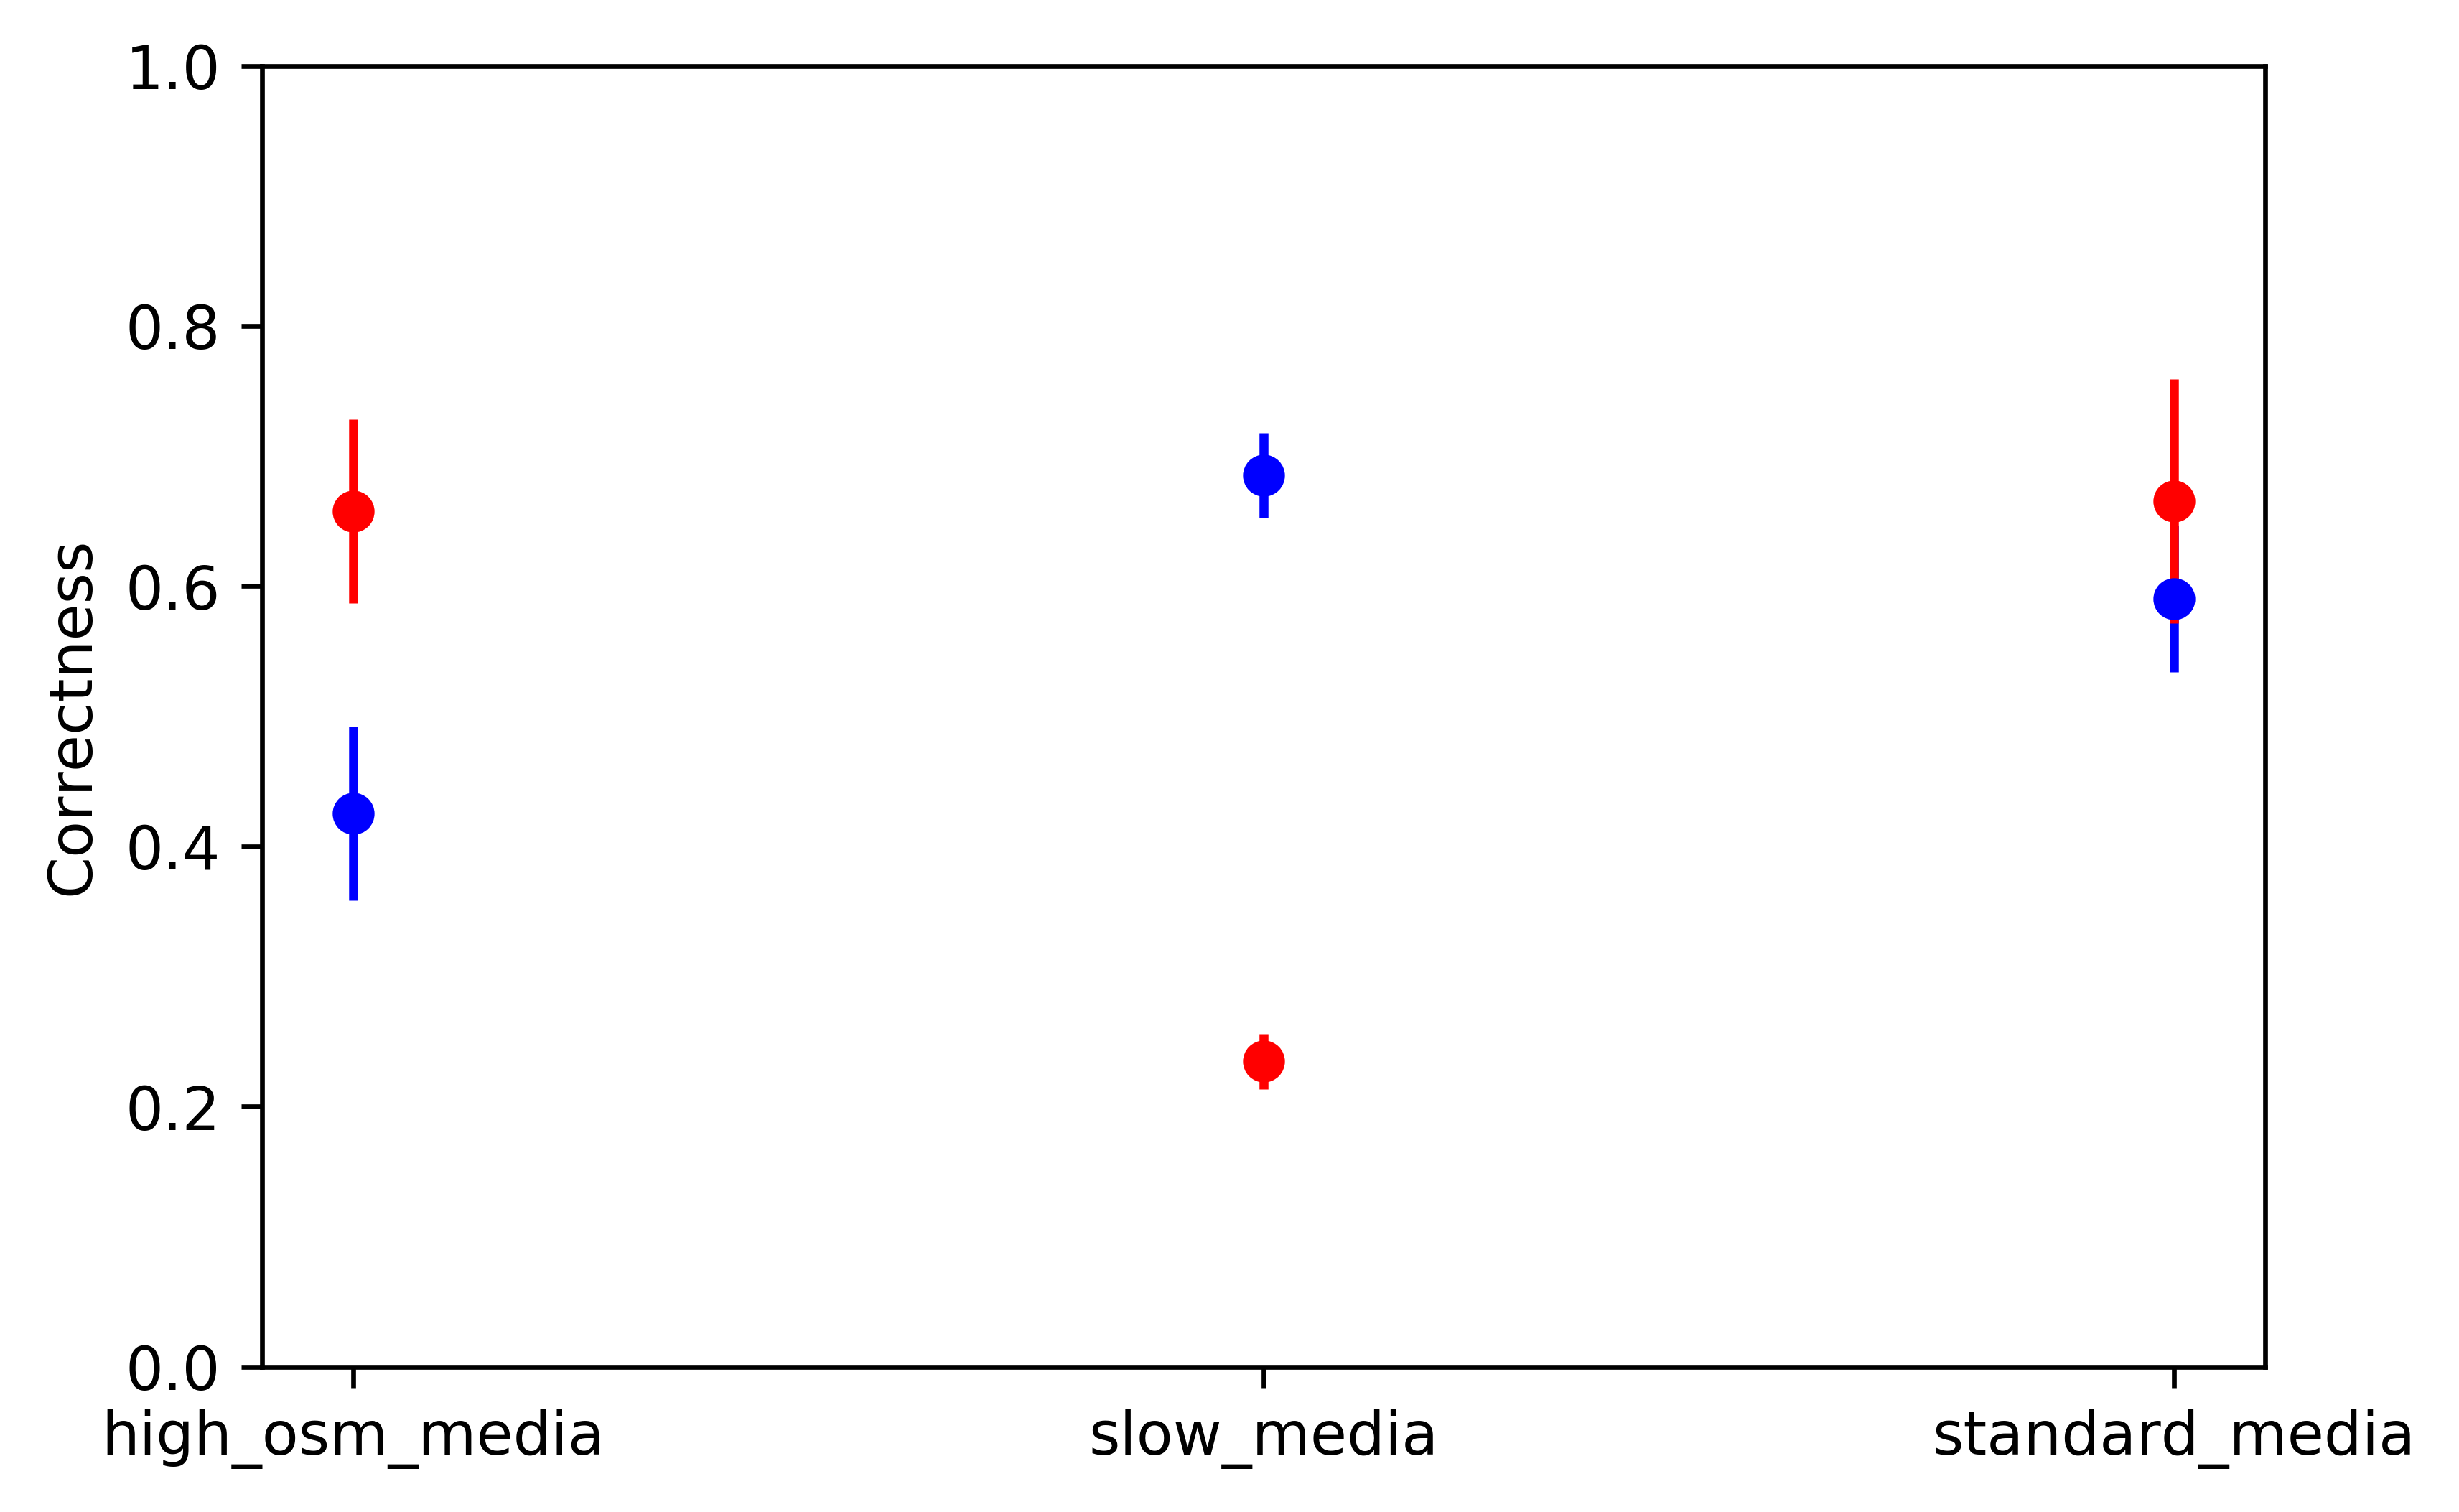

In [43]:
# errorplot("AND")

In [58]:
mpl.rcParams['figure.dpi']= 600
cspd1 = circuit_score_df_prod
# Strain x condition scores is mean of samples for condition
strain_score_df2 = df.groupby(conditions+design)['mean_correct_threshold_live'].agg(np.mean).reset_index()
cspd2 = strain_score_df2.groupby(conditions+['gate'])['mean_correct_threshold_live'].agg(np.prod).reset_index()

def calculate_std_err(data):
    err = []
    for ds in data:
        err.append(np.std(ds) / np.sqrt(len(ds)))
    return err


# make error bar plots
def whisker(gate,correctness_col,df):
    plt.figure()
    df_prod = df[(df["gate"]==gate)]
    data30_sc = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="standard_media")][correctness_col].values
    data30_osm = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="high_osm_media")][correctness_col].values
    data30_slow = df_prod.loc[(df_prod.inc_temp==30.0) & (df_prod.media=="slow_media")][correctness_col].values
    data37_sc = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="standard_media")][correctness_col].values
    data37_osm = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="high_osm_media")][correctness_col].values
    data37_slow = df_prod.loc[(df_prod.inc_temp==37.0) & (df_prod.media=="slow_media")][correctness_col].values
    datasc=[data30_sc,data30_osm,data30_slow,data37_sc,data37_osm,data37_slow]
    err = calculate_std_err(datasc)
    print([z for z in zip(["SC30","OSM30","SLOW30","SC37","OSM37","SLOW37"],err)])
    plt.boxplot(datasc,patch_artist=True,boxprops=dict(facecolor="lightgray"))
    labels = list(y+"\n"+str(x) for x,y in itertools.product([30.0,37.0],["SC Media","High Osm","SC Slow"]))
    plt.xticks(range(1,7), labels, fontsize=10)
    plt.xlim((0.5,6.5))
    plt.ylim((-0.1,1))
    plt.ylabel("Correctness") 
    

[('SC30', 0.029039050616615242), ('OSM30', 0.033354466945860334), ('SLOW30', 0.01627370934244545), ('SC37', 0.037535191618707095), ('OSM37', 0.03539010505479423), ('SLOW37', 0.010720762360758427)]
[('SC30', 0.02901557196201412), ('OSM30', 0.013951962047700385), ('SLOW30', 0.01702438904861275), ('SC37', 0.018803771838953386), ('OSM37', 0.01588357188807307), ('SLOW37', 0.014352488305356475)]


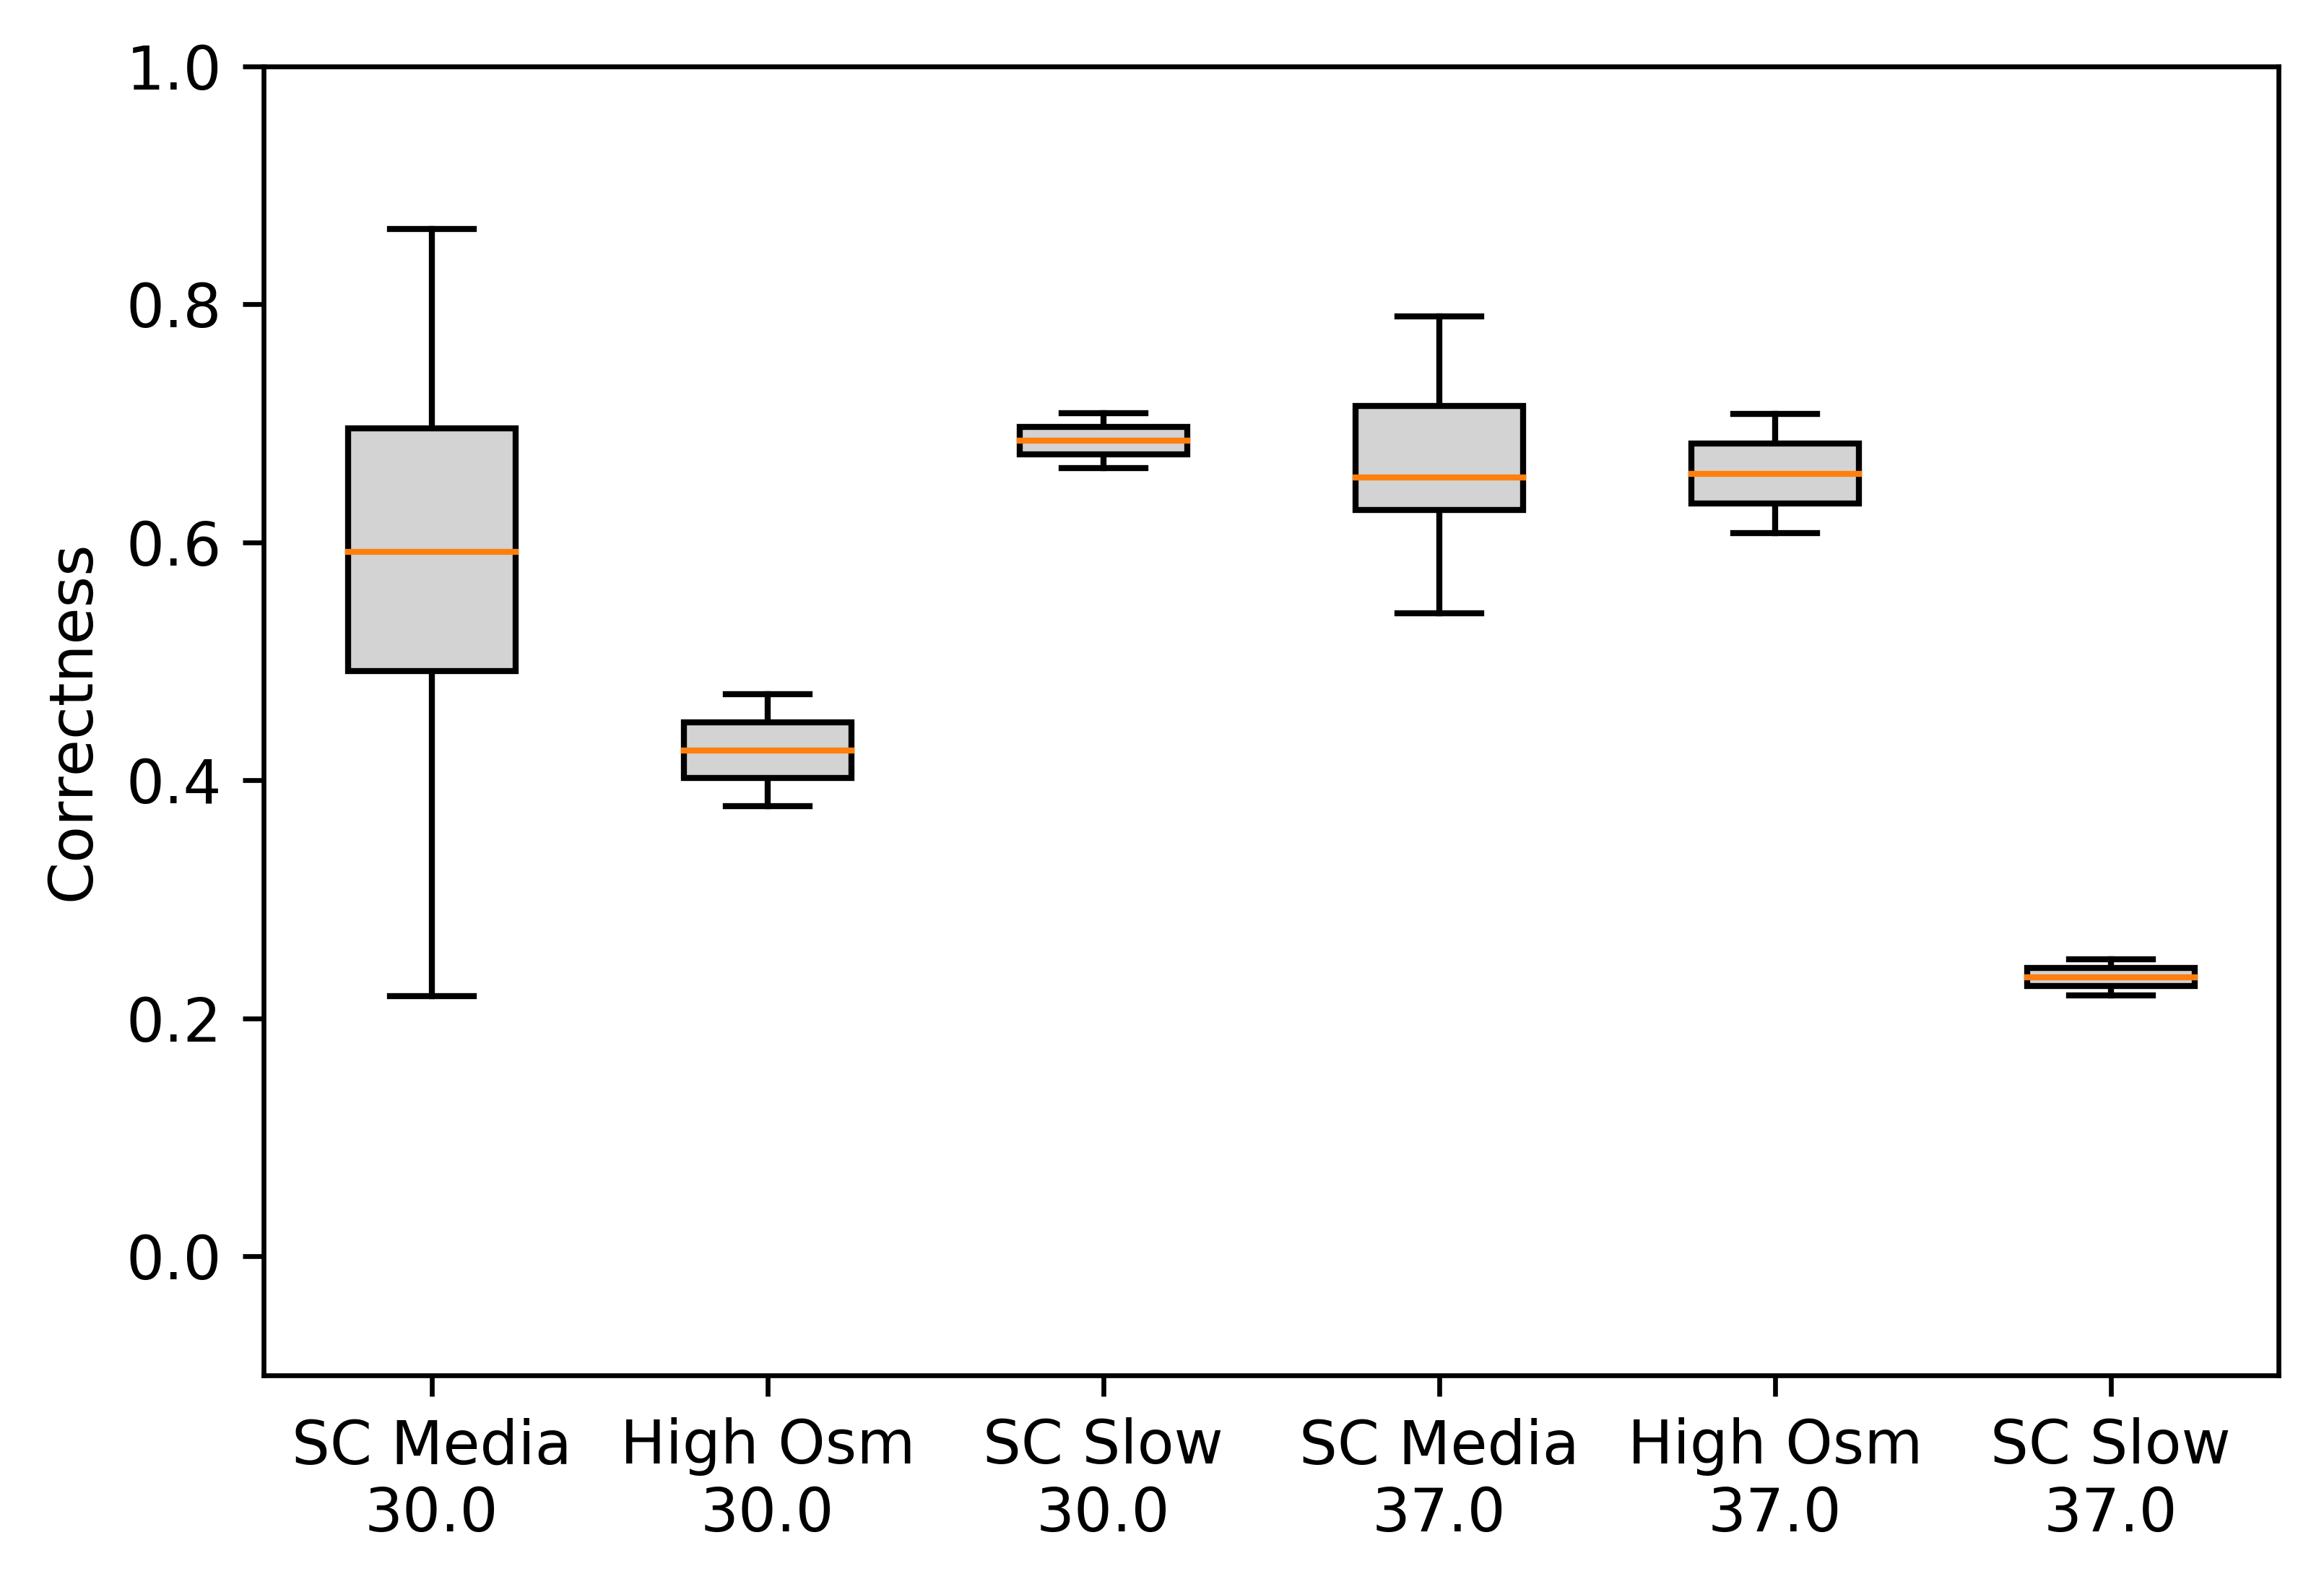

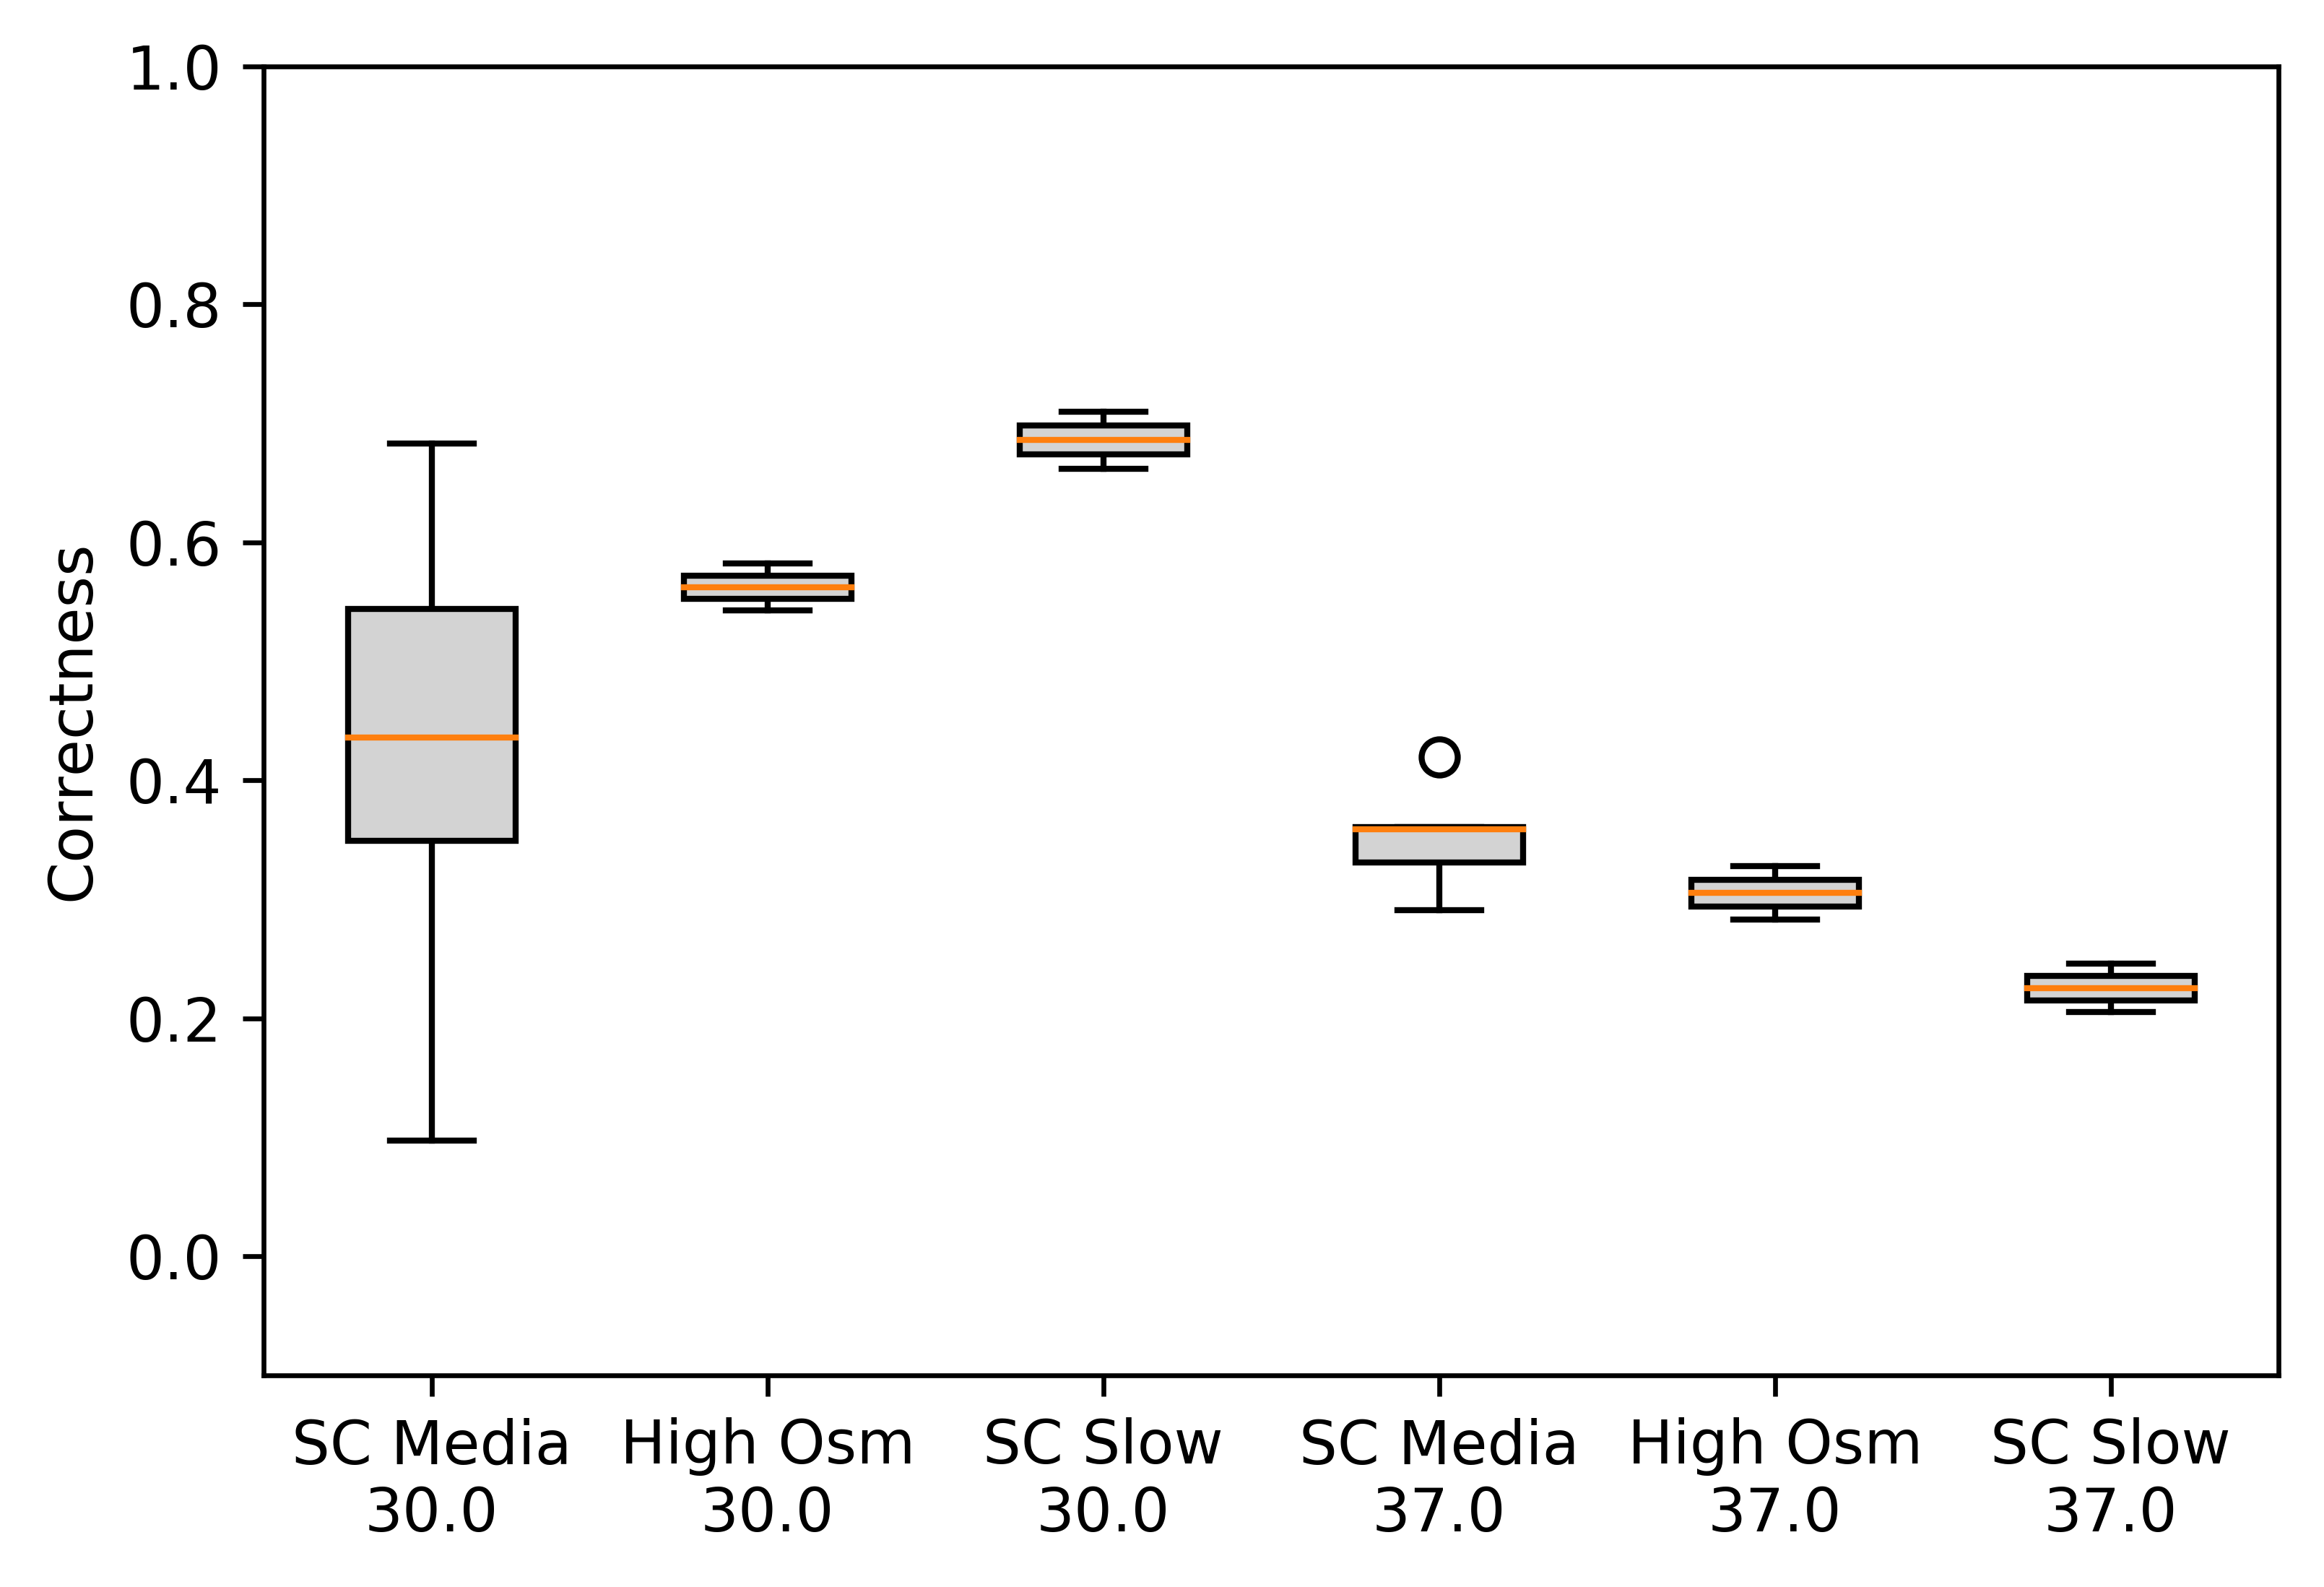

In [59]:
whisker("AND",'mean_correct_classifier_live',cspd1)
whisker("AND",'mean_correct_threshold_live',cspd2)

[('SC30', 0.018478797240094404), ('OSM30', 0.00043244724947263794), ('SLOW30', 0.00949372964523142), ('SC37', 0.0917717124469875), ('OSM37', 0.023358339078629504), ('SLOW37', 0.001623922326450706)]
[('SC30', 0.015803107538400595), ('OSM30', 0.007572978380071819), ('SLOW30', 0.009239273919061751), ('SC37', 0.03655799531713827), ('OSM37', 0.01509950877528593), ('SLOW37', 0.008002936078834838)]


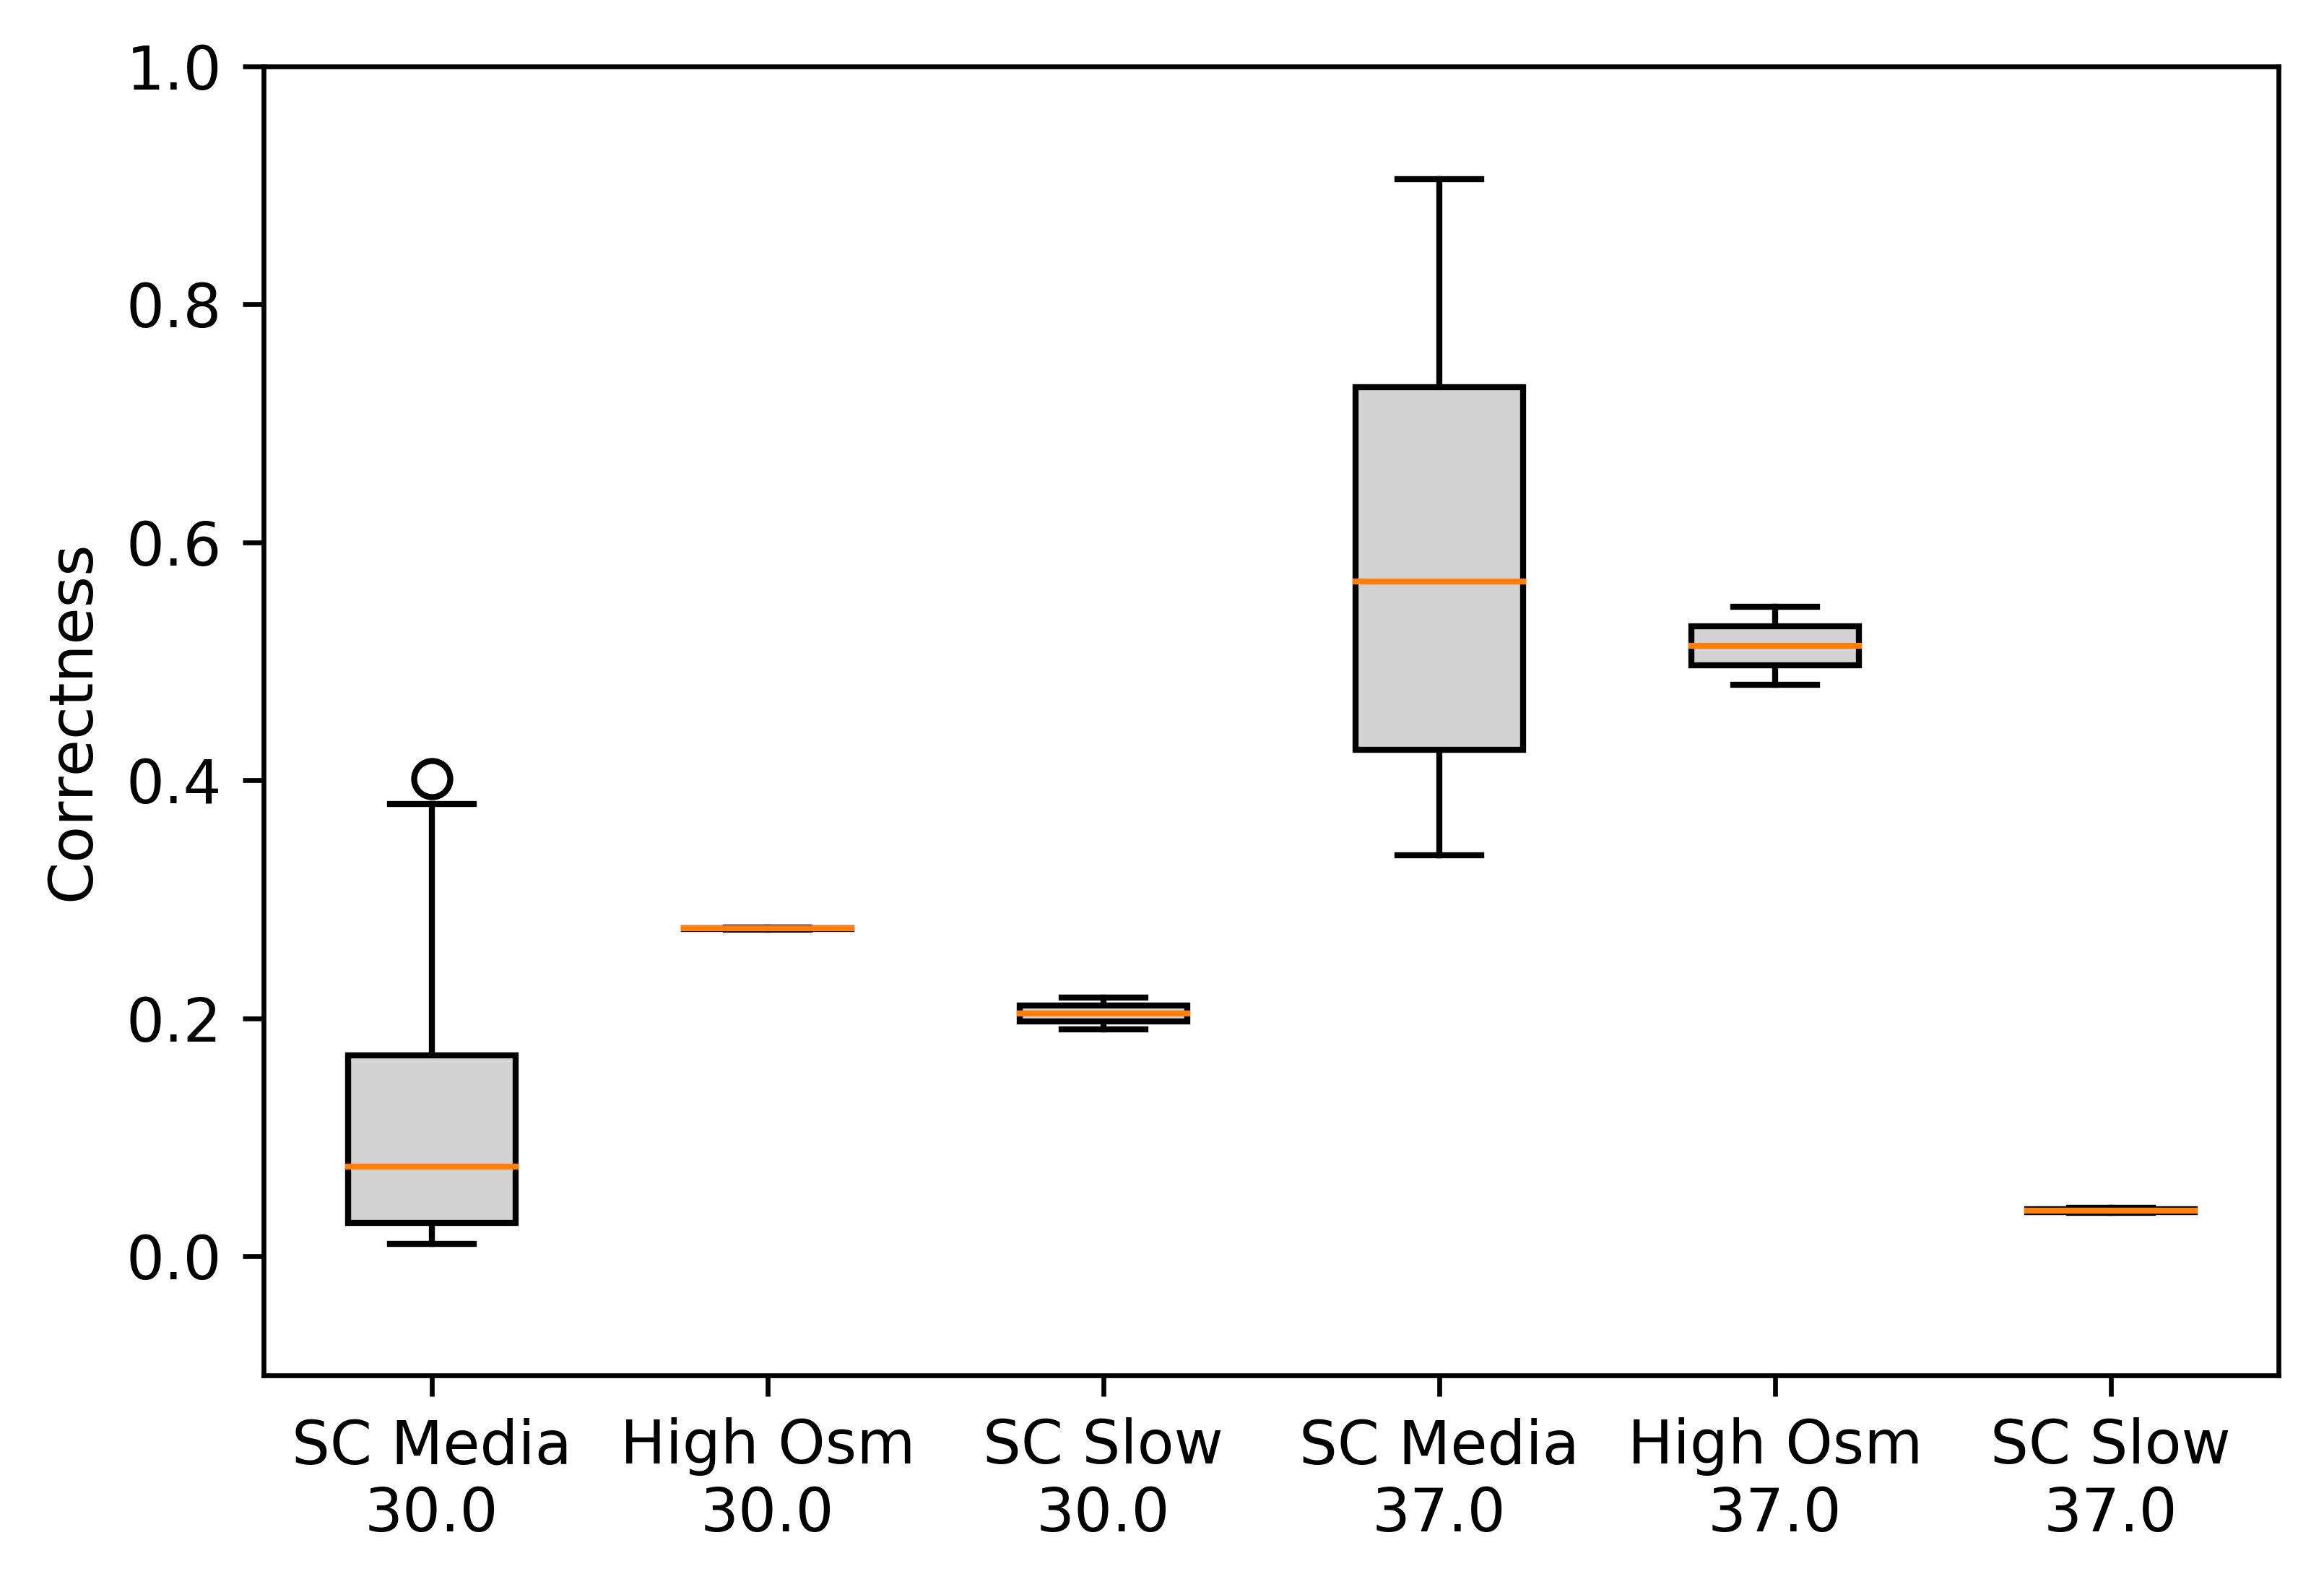

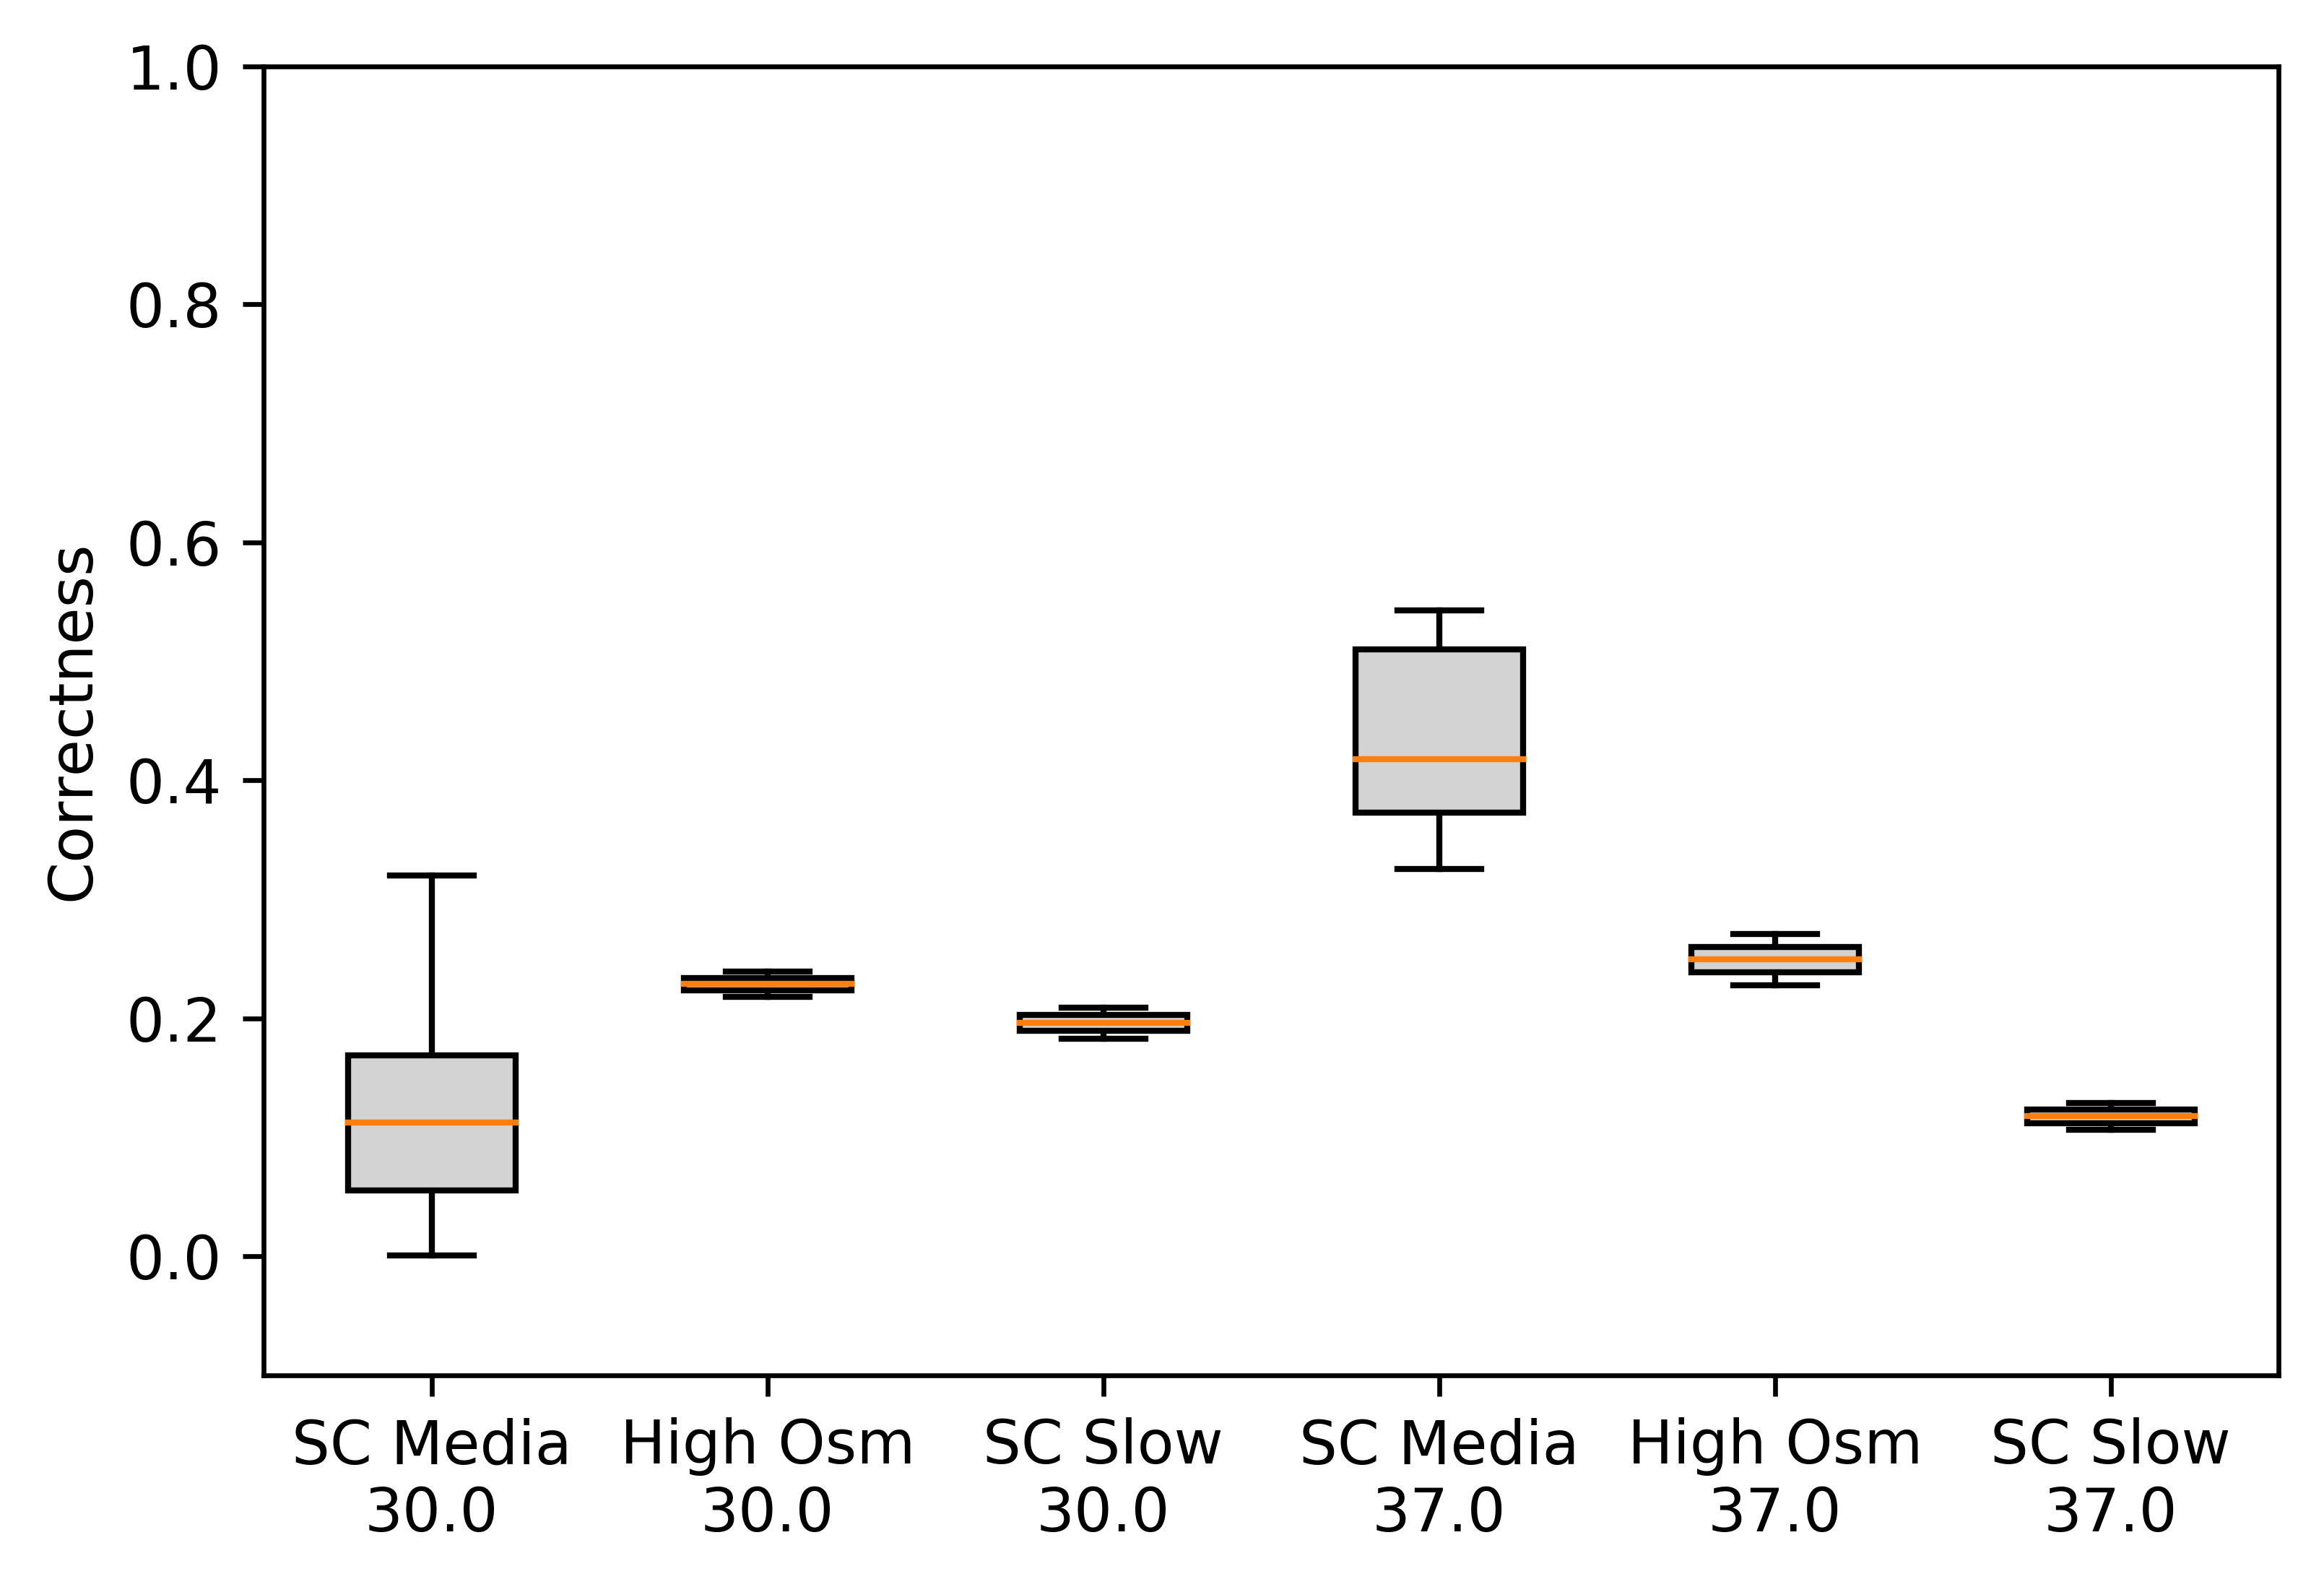

In [60]:
whisker("NAND",'mean_correct_classifier_live',cspd1)
whisker("NAND",'mean_correct_threshold_live',cspd2)

[('SC30', 0.002426411980641741), ('OSM30', 4.929226892721888e-05), ('SLOW30', 0.0004605271419214192), ('SC37', 0.00018886621947628168), ('OSM37', 0.0009831051228949058), ('SLOW37', 0.000583982449367384)]
[('SC30', 0.006087706092482744), ('OSM30', 0.0015298575113679054), ('SLOW30', 0.0006996720416077502), ('SC37', 0.003257649610914517), ('OSM37', 0.0014848944922582995), ('SLOW37', 0.0018937809697728793)]


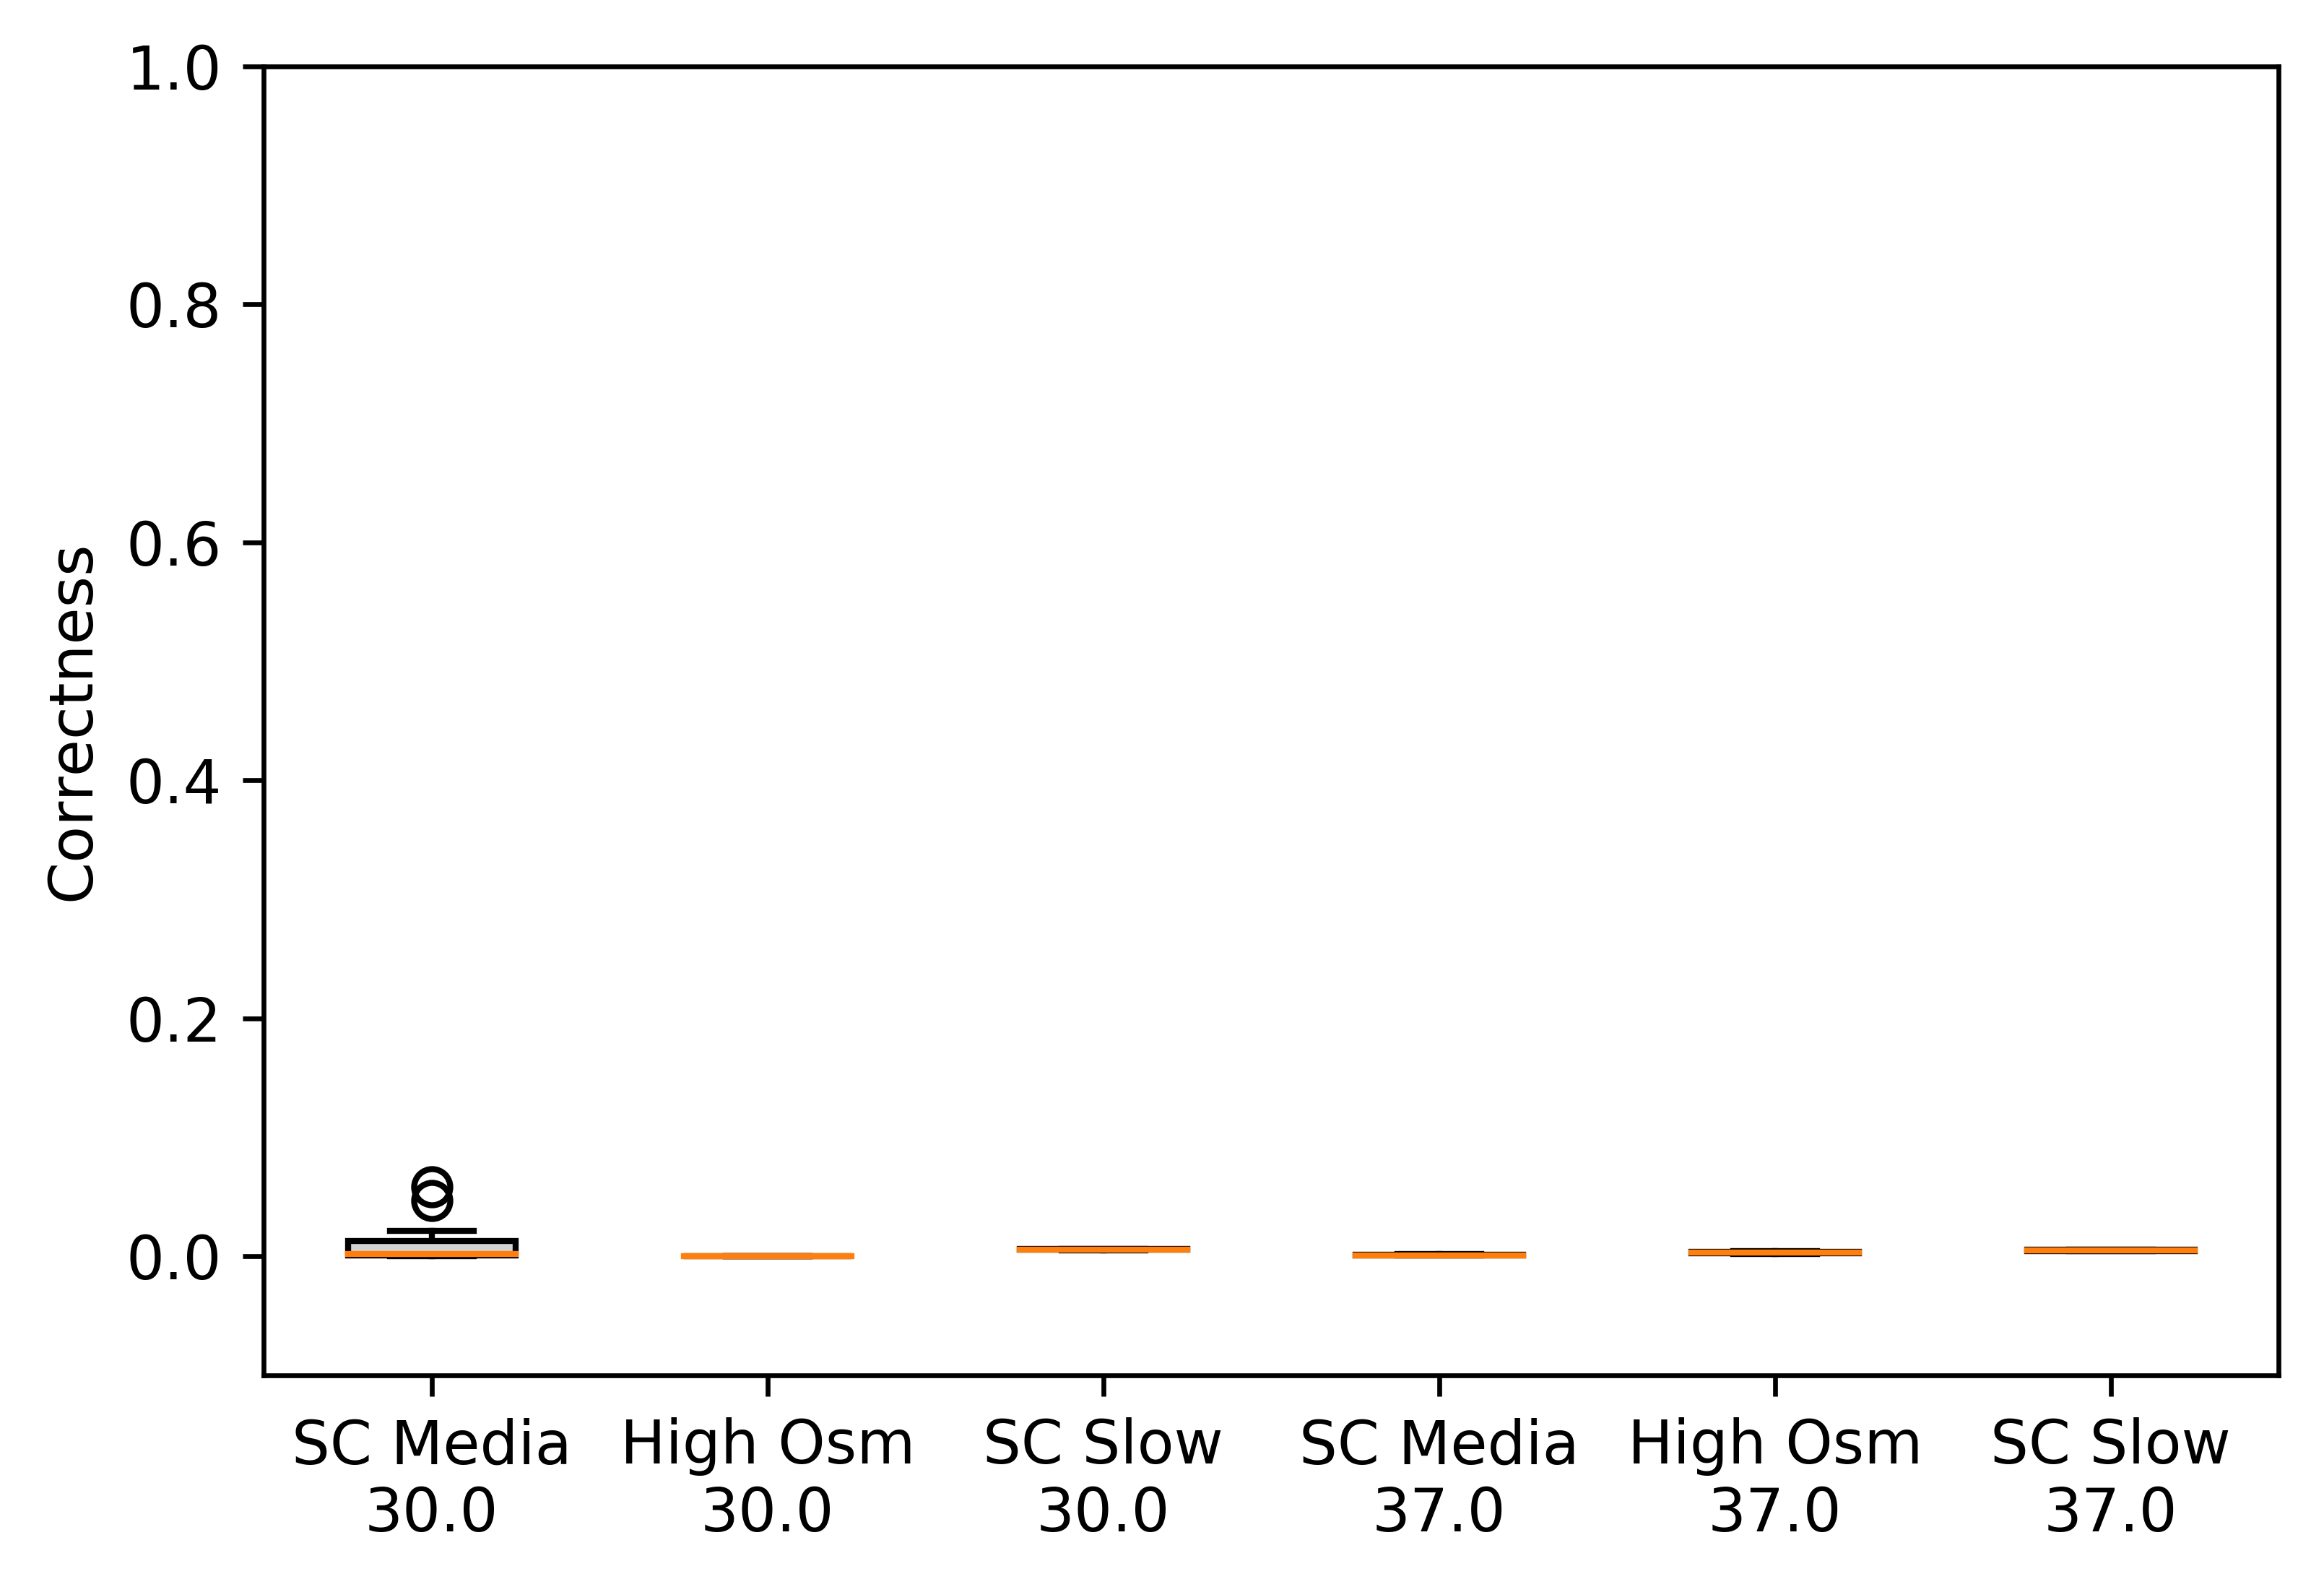

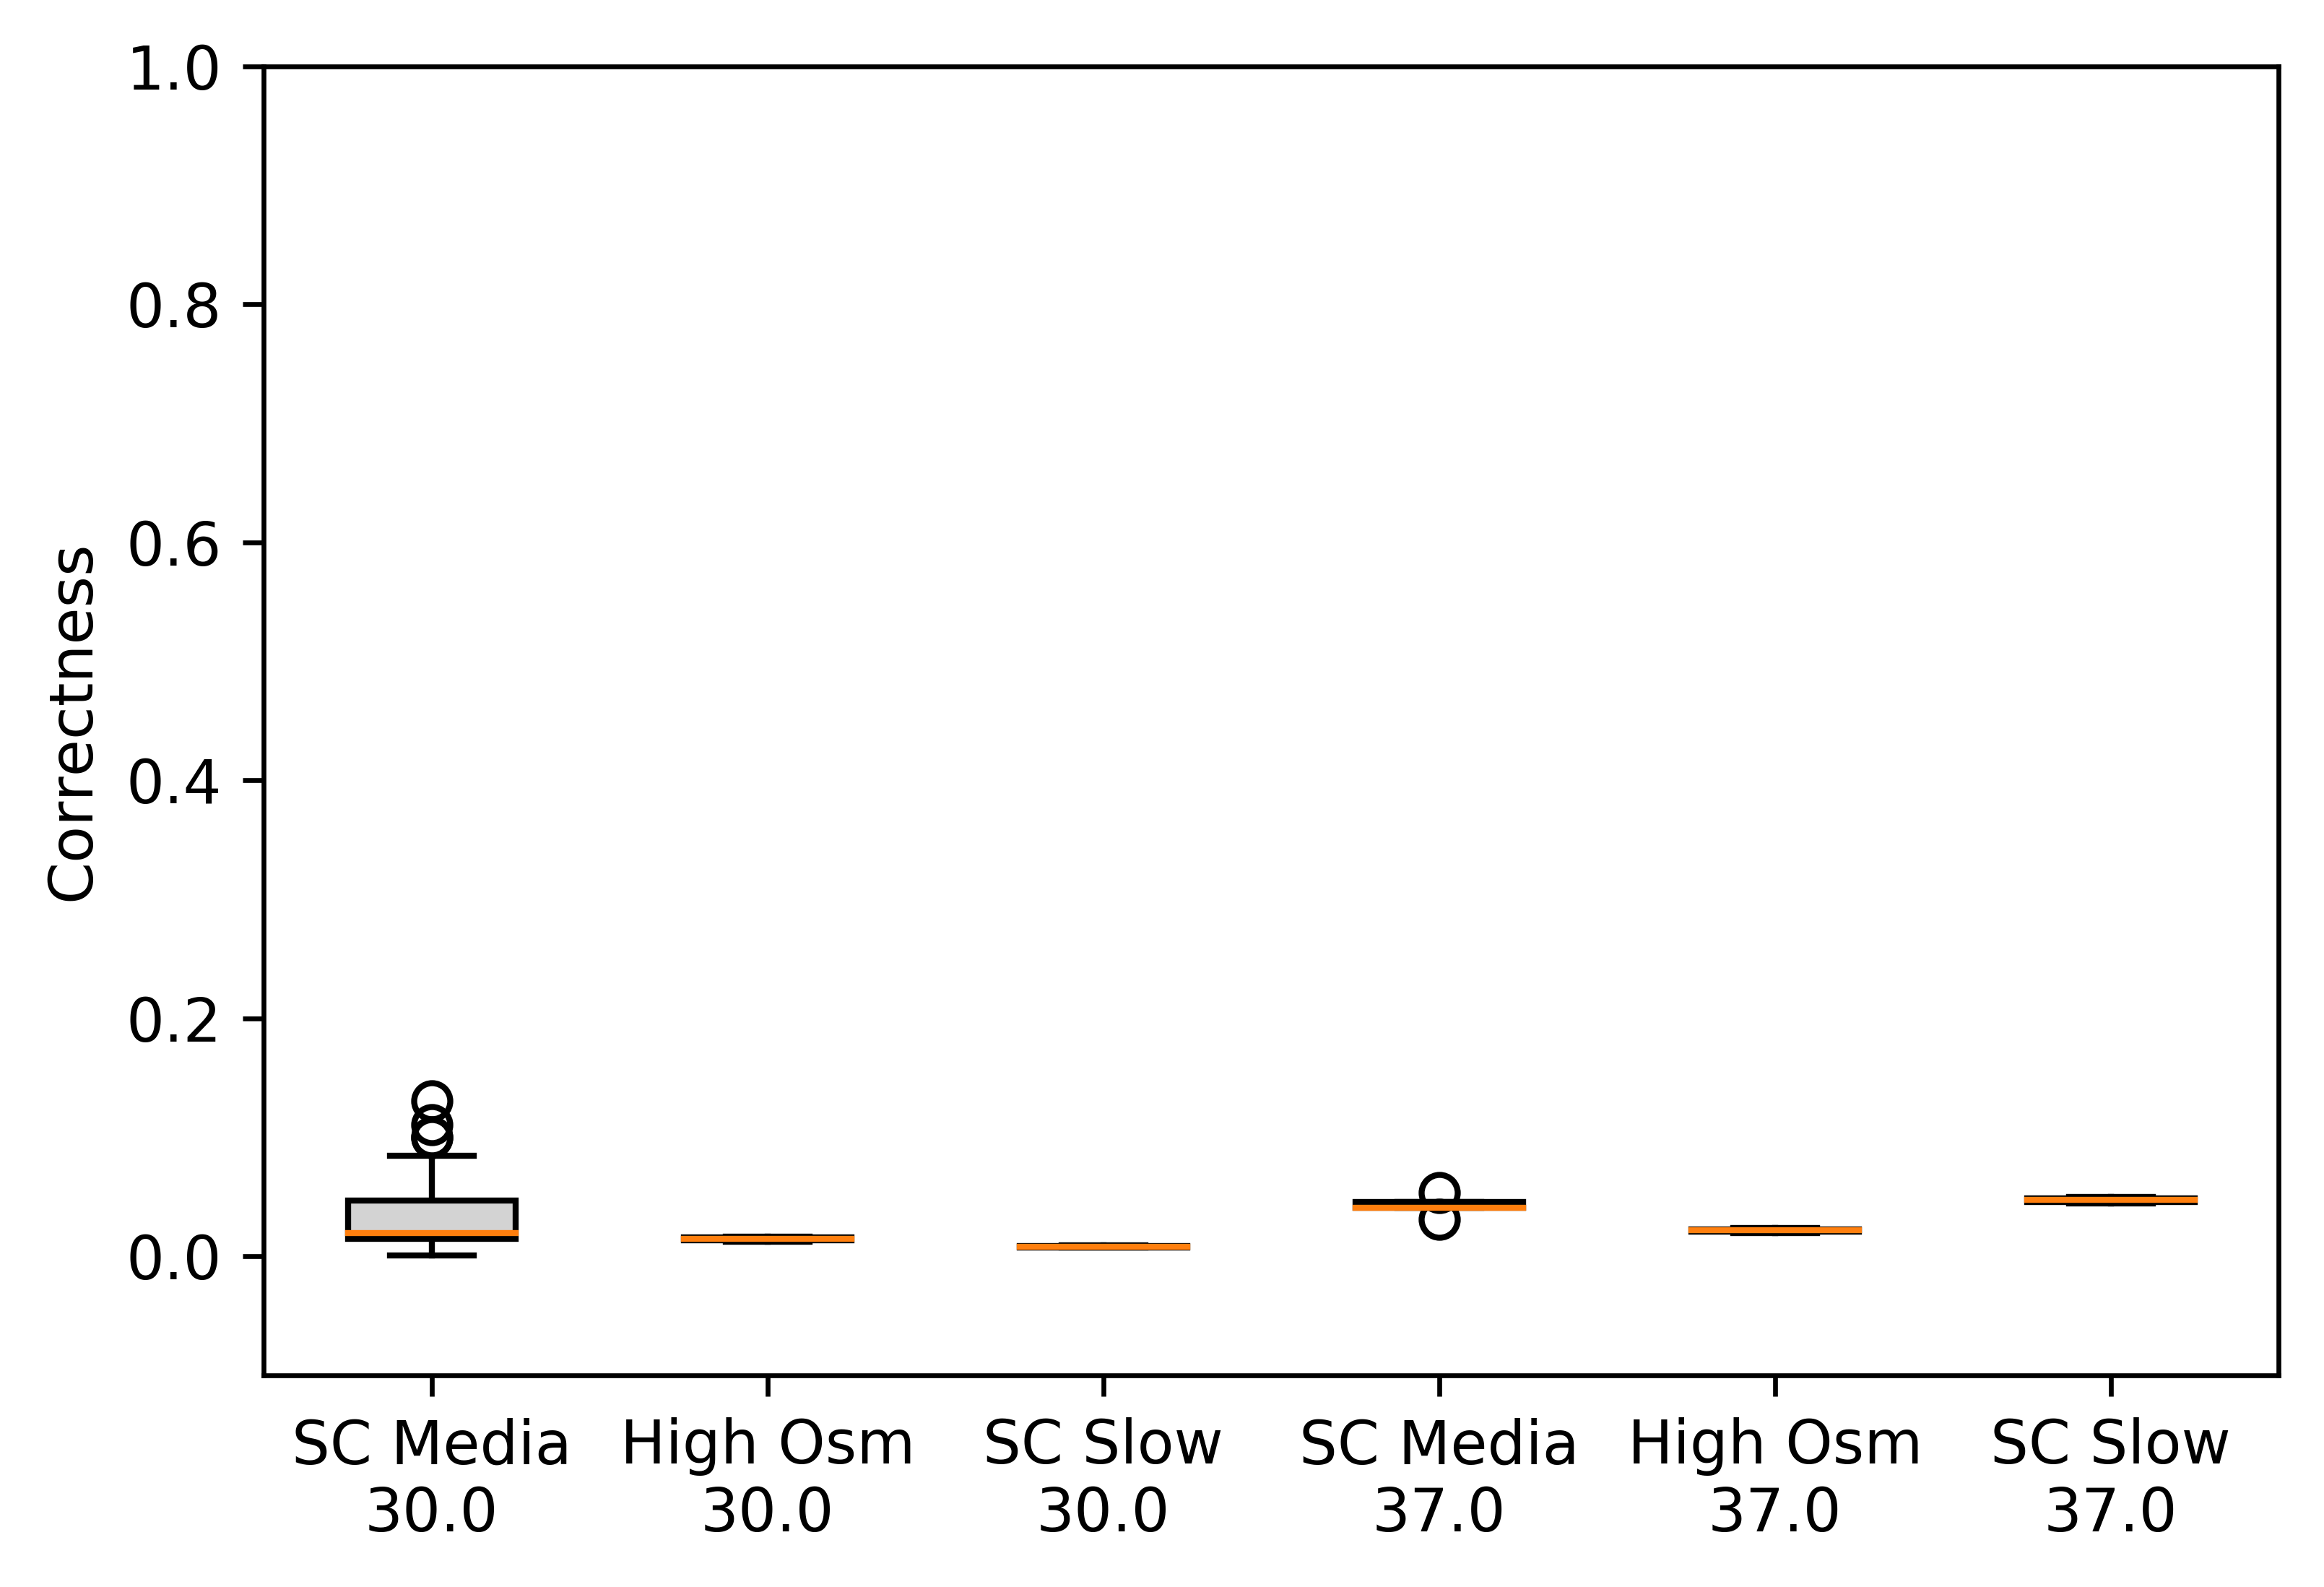

In [61]:
whisker("OR",'mean_correct_classifier_live',cspd1)
whisker("OR",'mean_correct_threshold_live',cspd2)

[('SC30', 0.034184929745426335), ('OSM30', 0.013060821512170315), ('SLOW30', 0.030793697461605003), ('SC37', 0.023885545484321525), ('OSM37', 0.02475794849291991), ('SLOW37', 0.0472902278999339)]
[('SC30', 0.030292553784809793), ('OSM30', 0.008925326313806036), ('SLOW30', 0.028151766261341134), ('SC37', 0.01614984014814355), ('OSM37', 0.02767294091270254), ('SLOW37', 0.0018096772486558344)]


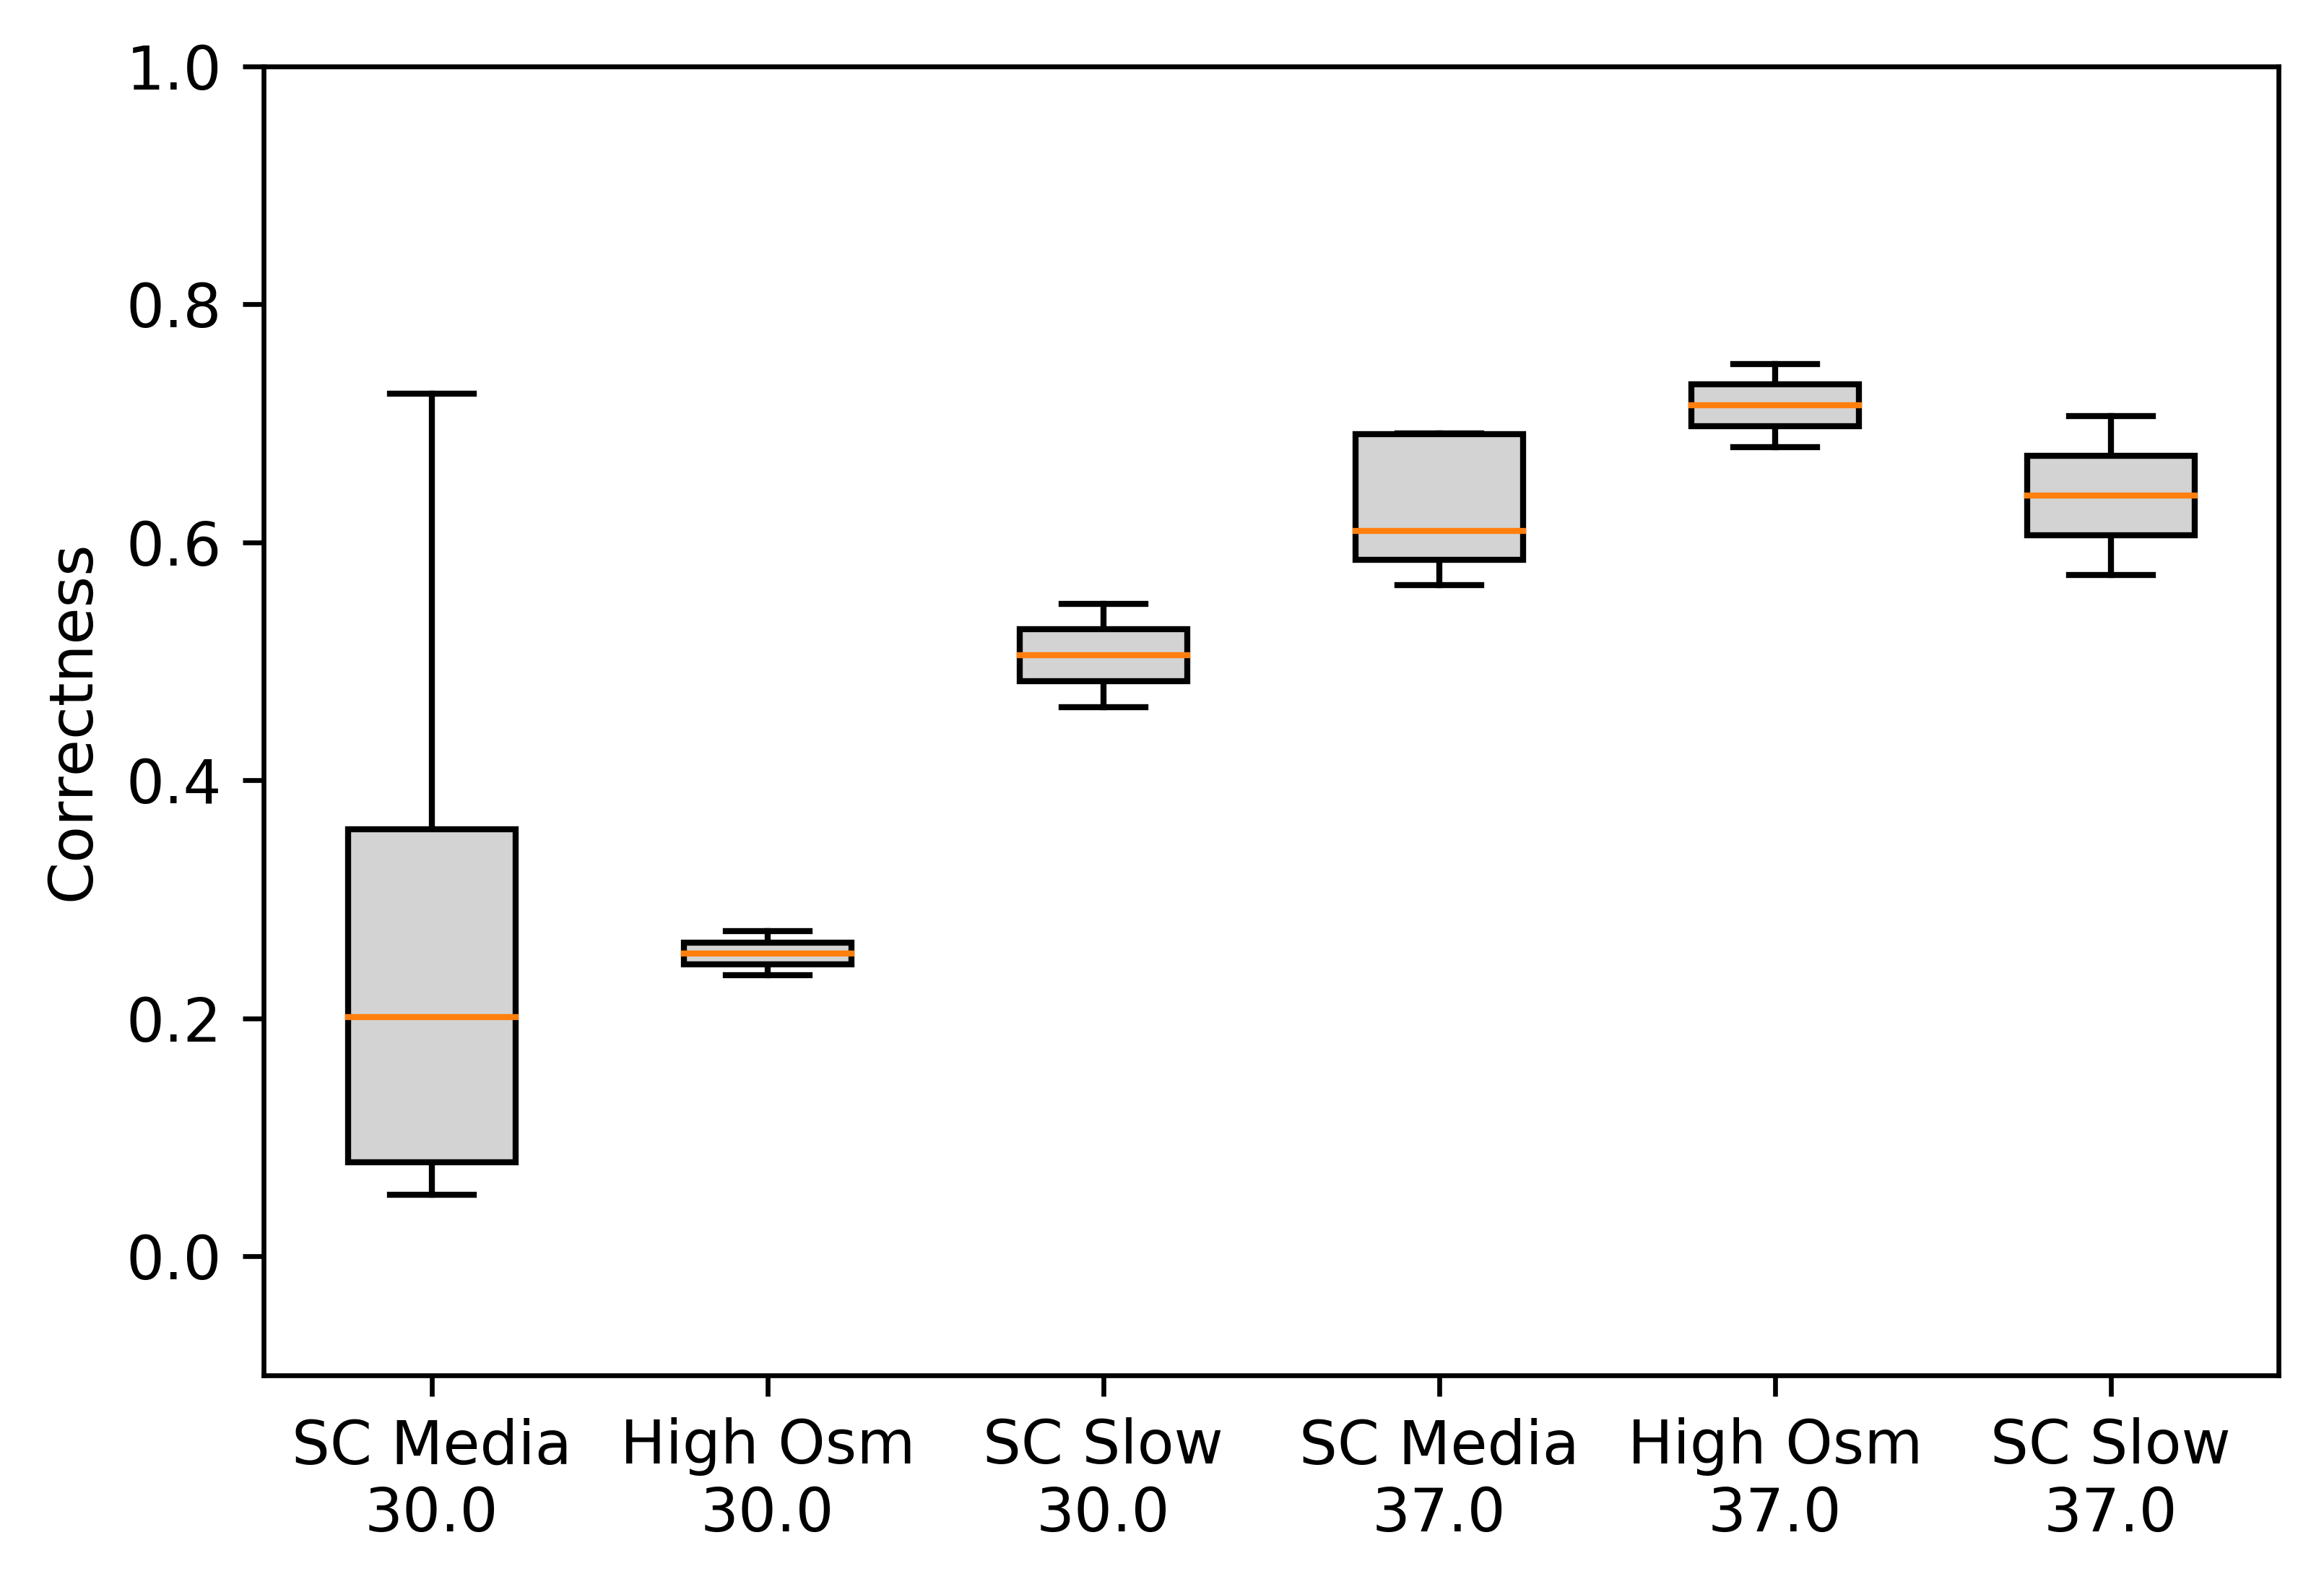

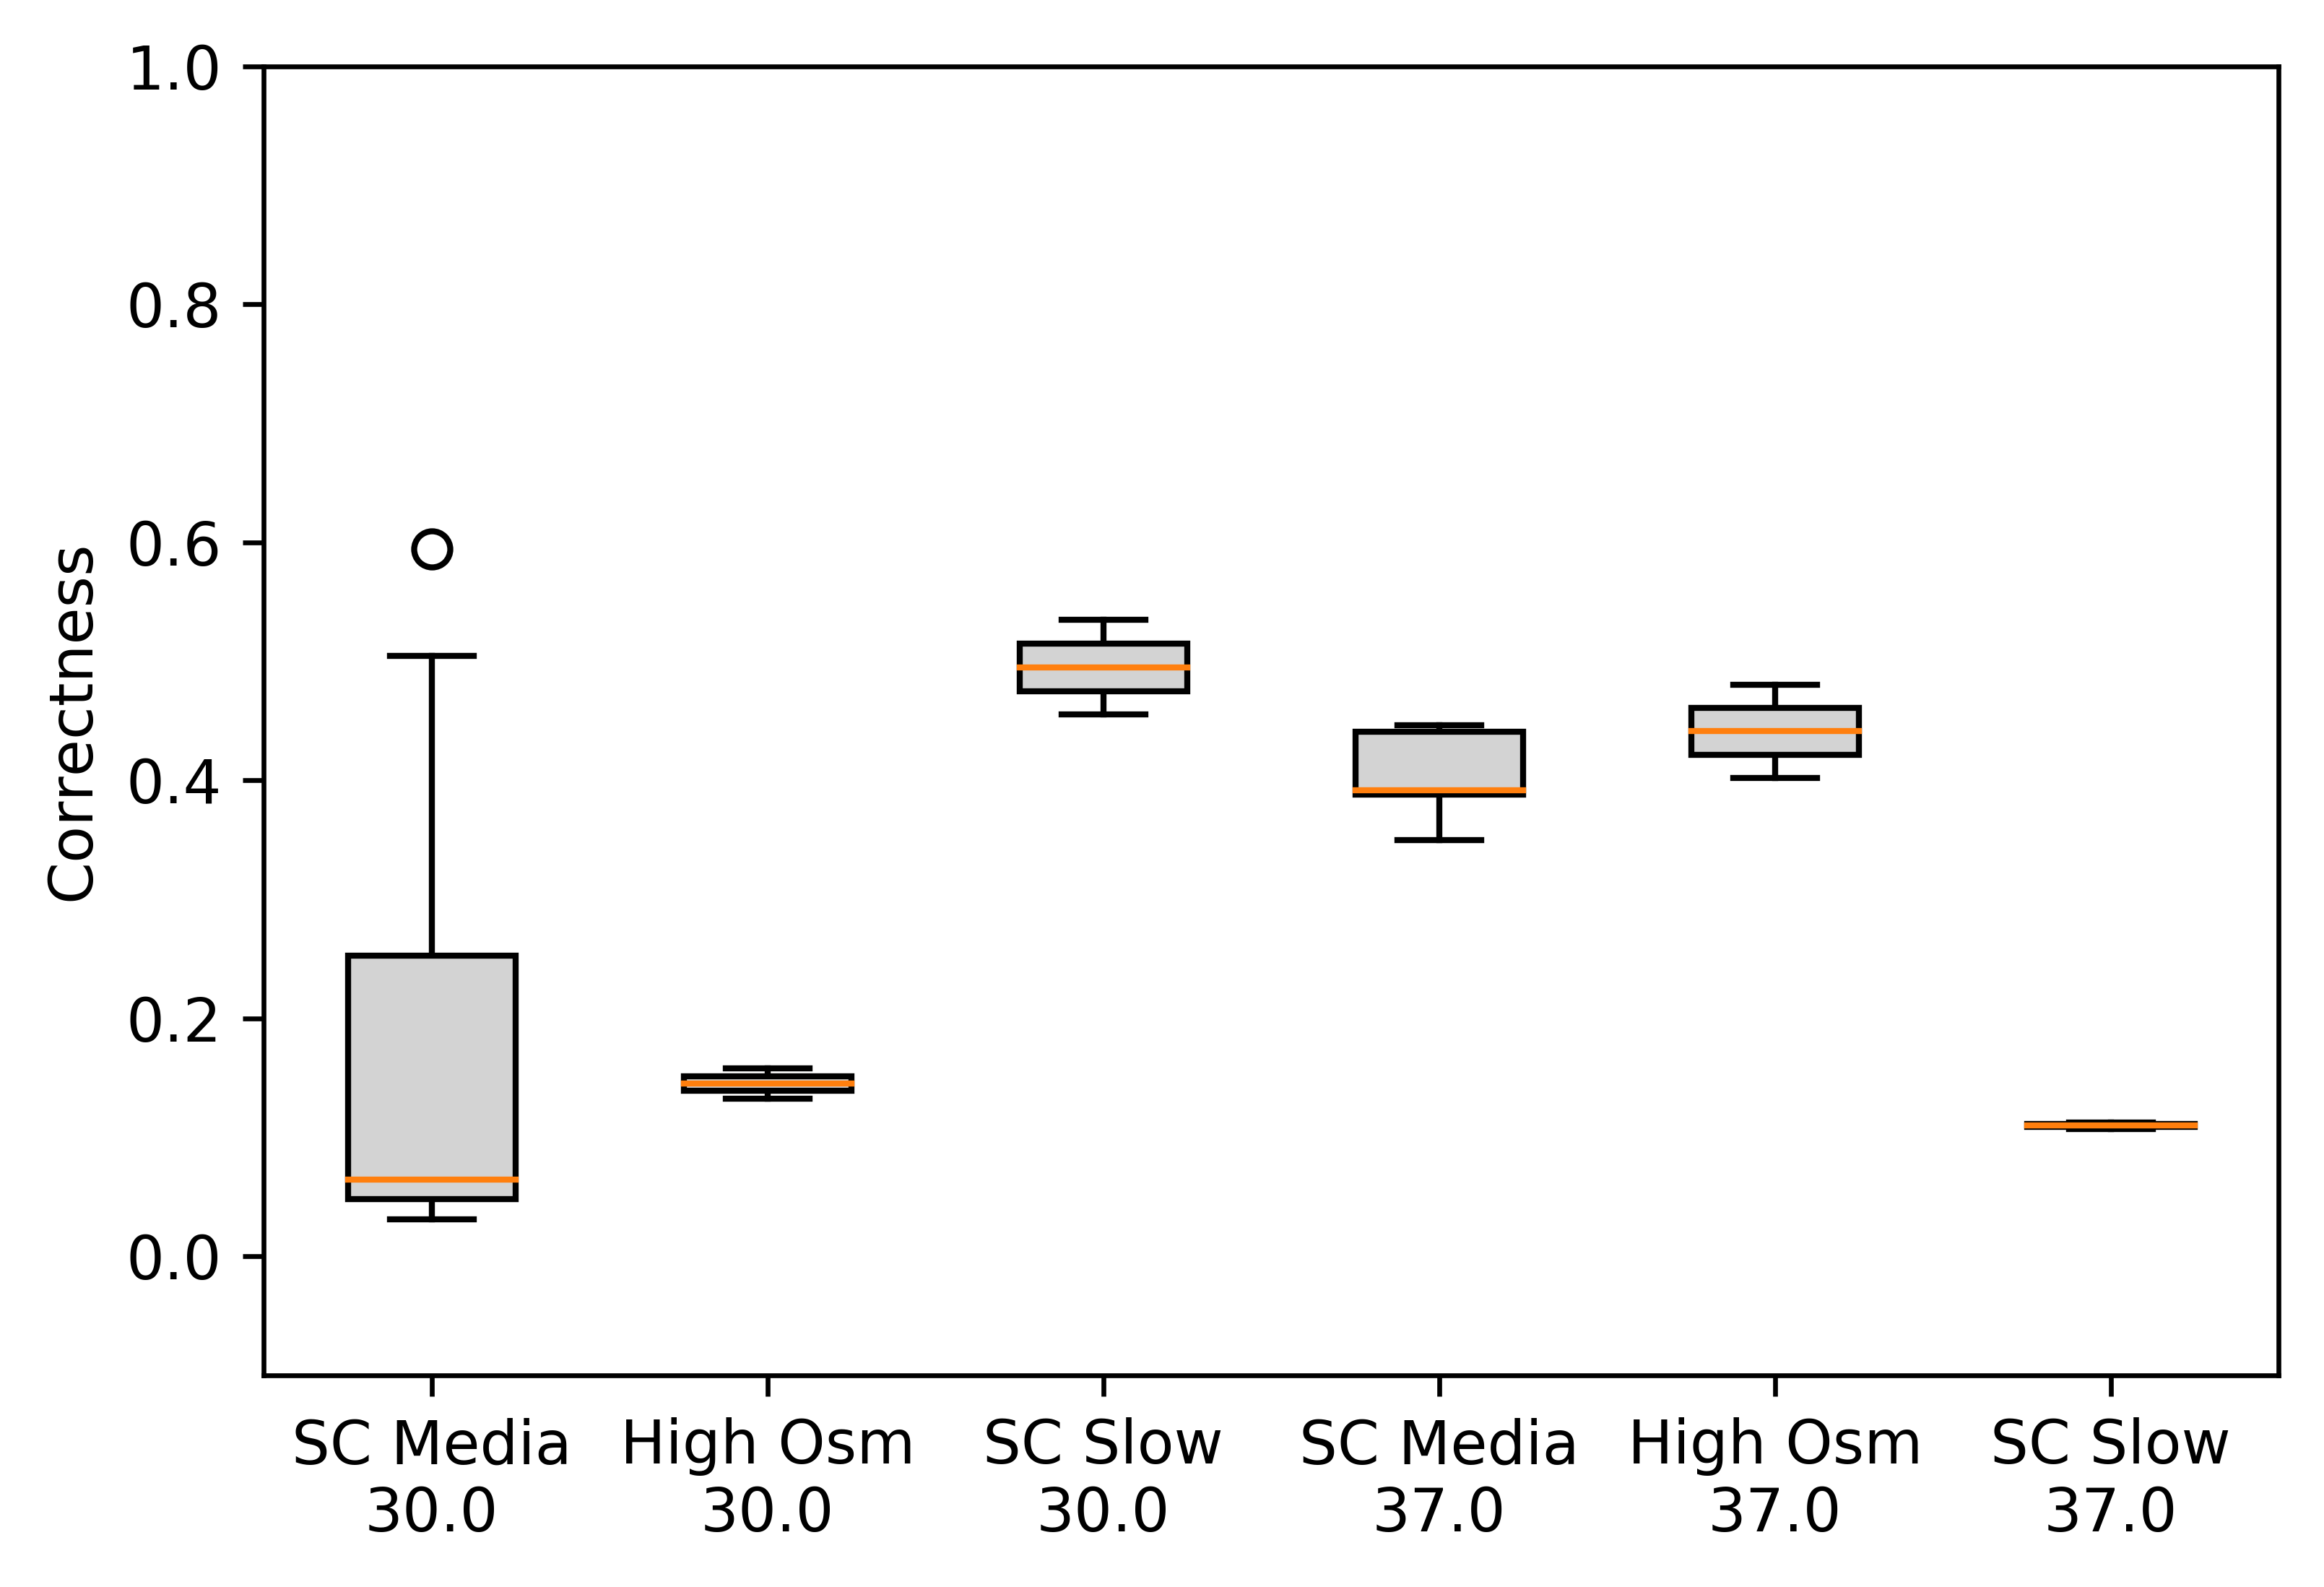

In [62]:
whisker("NOR",'mean_correct_classifier_live',cspd1)
whisker("NOR",'mean_correct_threshold_live',cspd2)

[('SC30', 0.015893205065950797), ('OSM30', 0.0015714151313437697), ('SLOW30', 0.017861515837454996), ('SC37', 0.054352034144025424), ('OSM37', 0.05617010919672582), ('SLOW37', 0.04483276757221721)]
[('SC30', 0.011189130858043834), ('OSM30', 0.0017611026061656128), ('SLOW30', 0.00986544979778307), ('SC37', 0.020838637885482708), ('OSM37', 0.017402824622529952), ('SLOW37', 0.004000214041360546)]


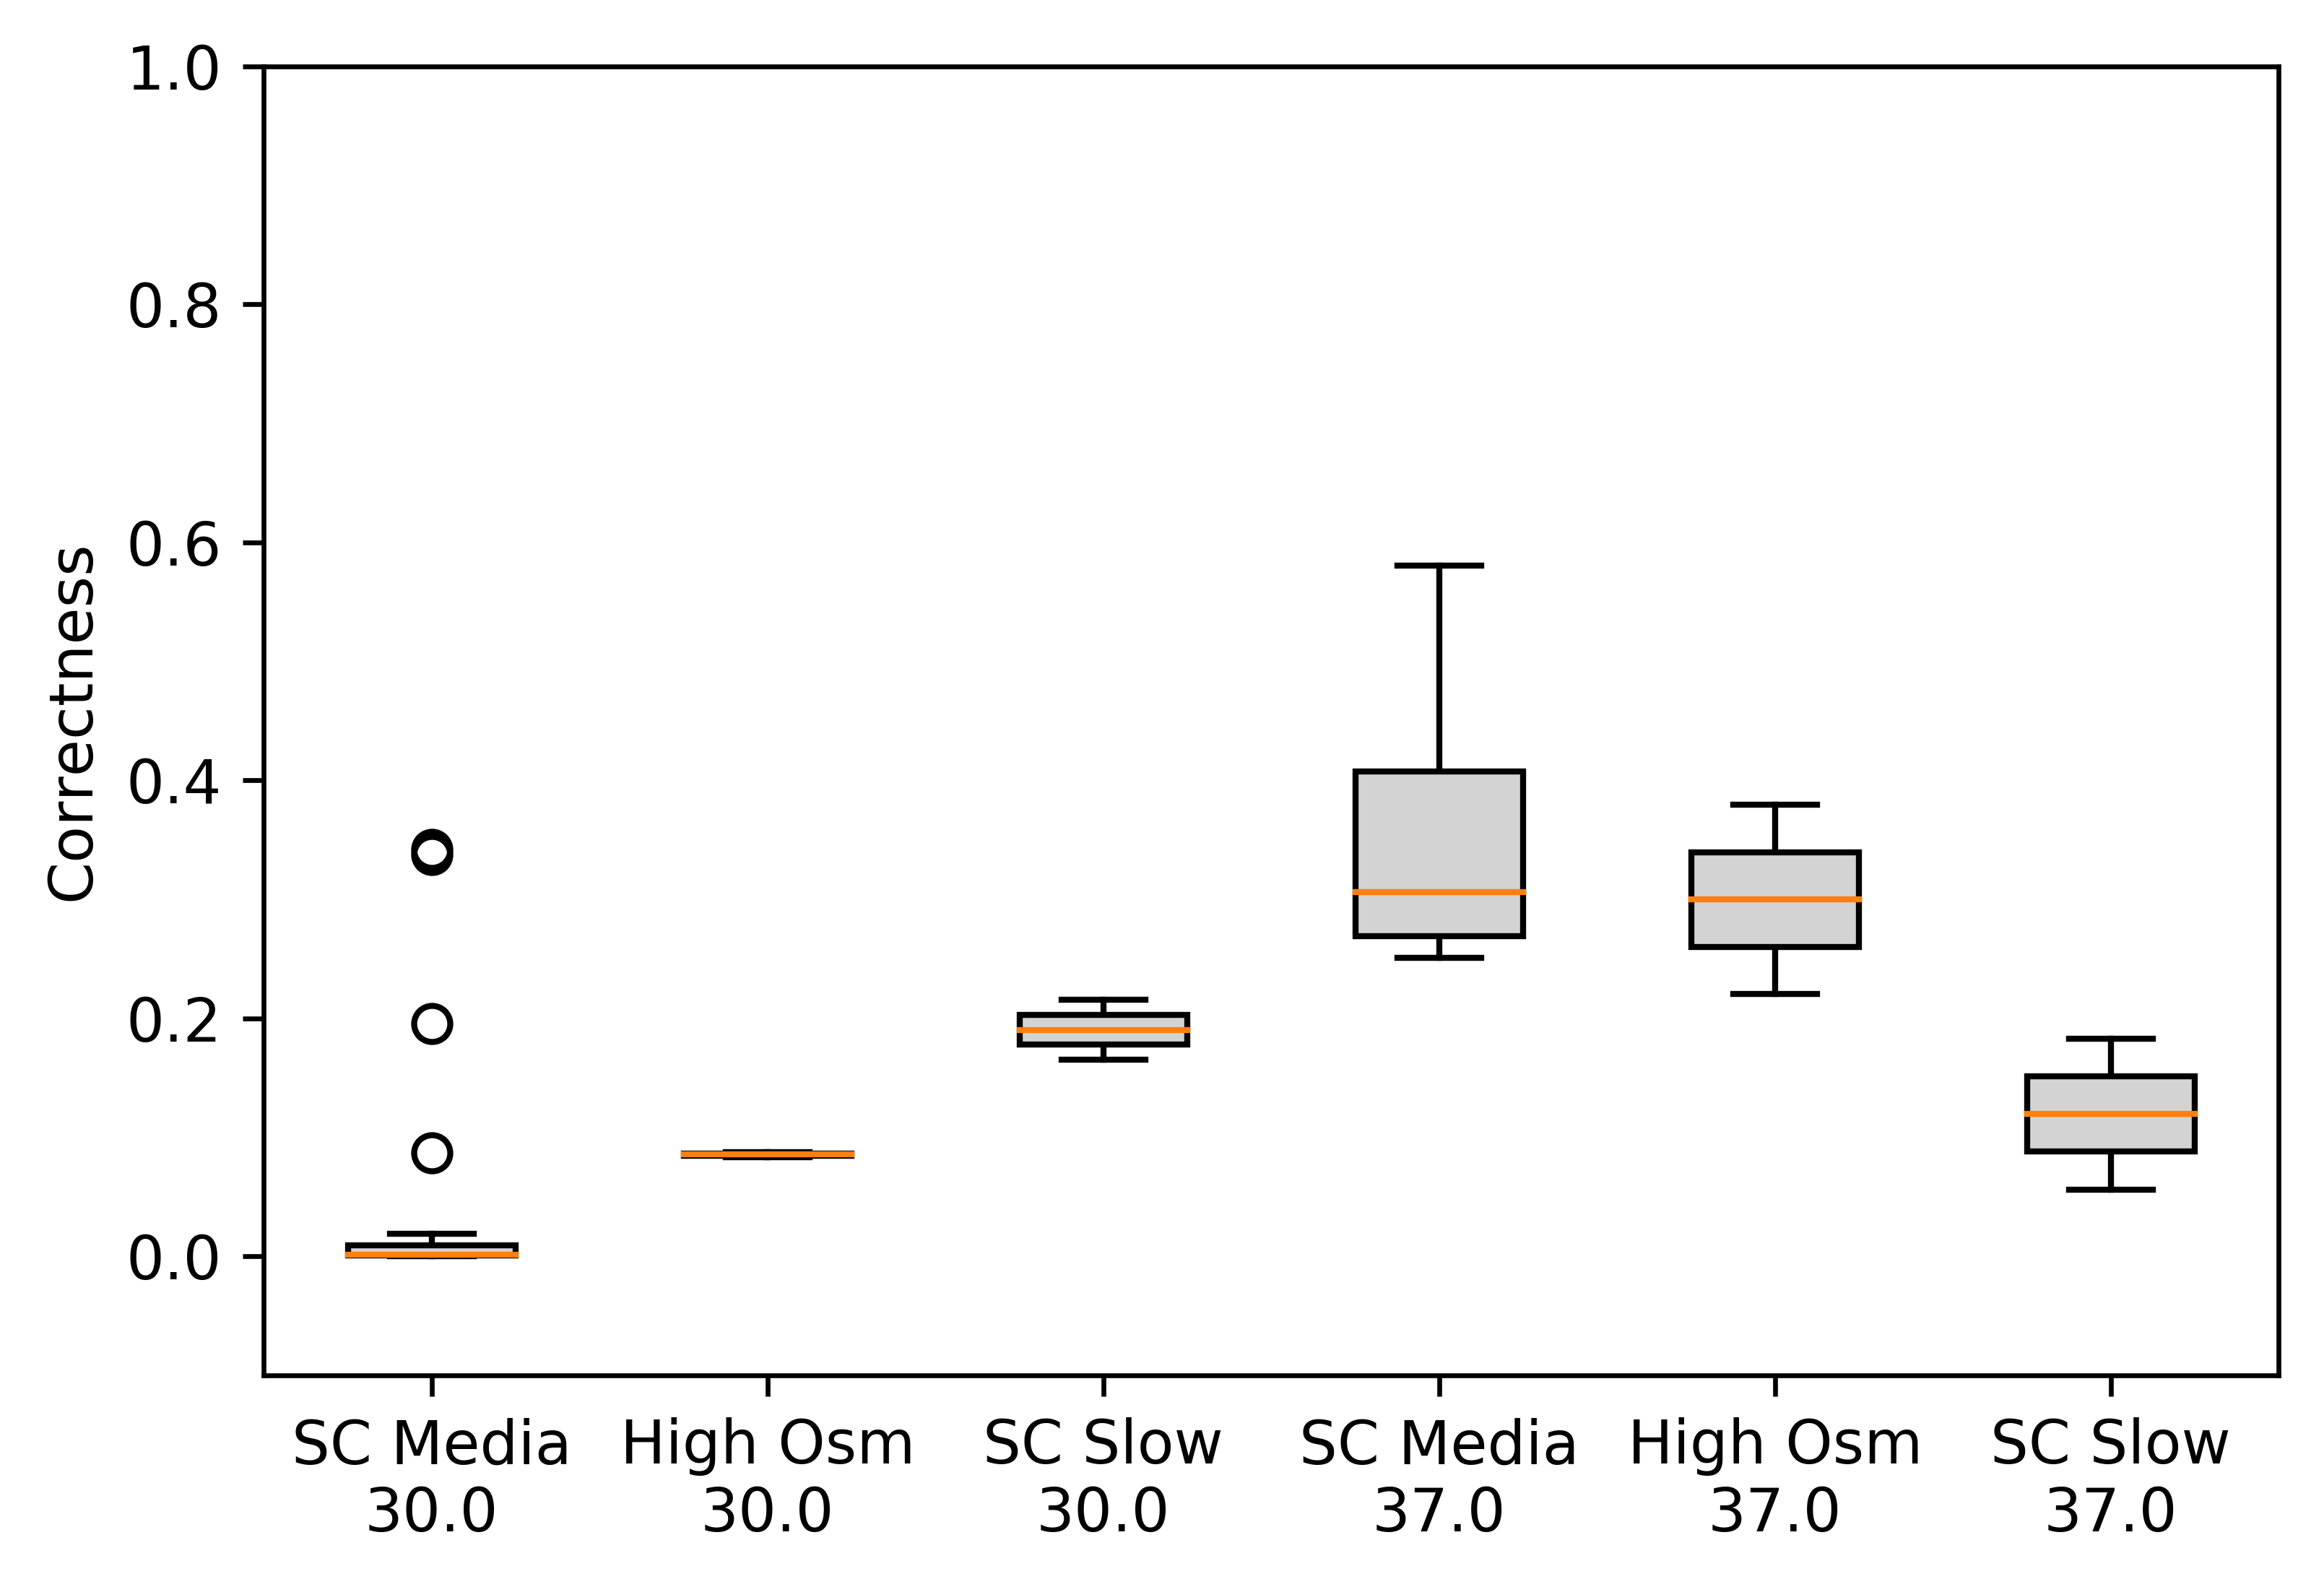

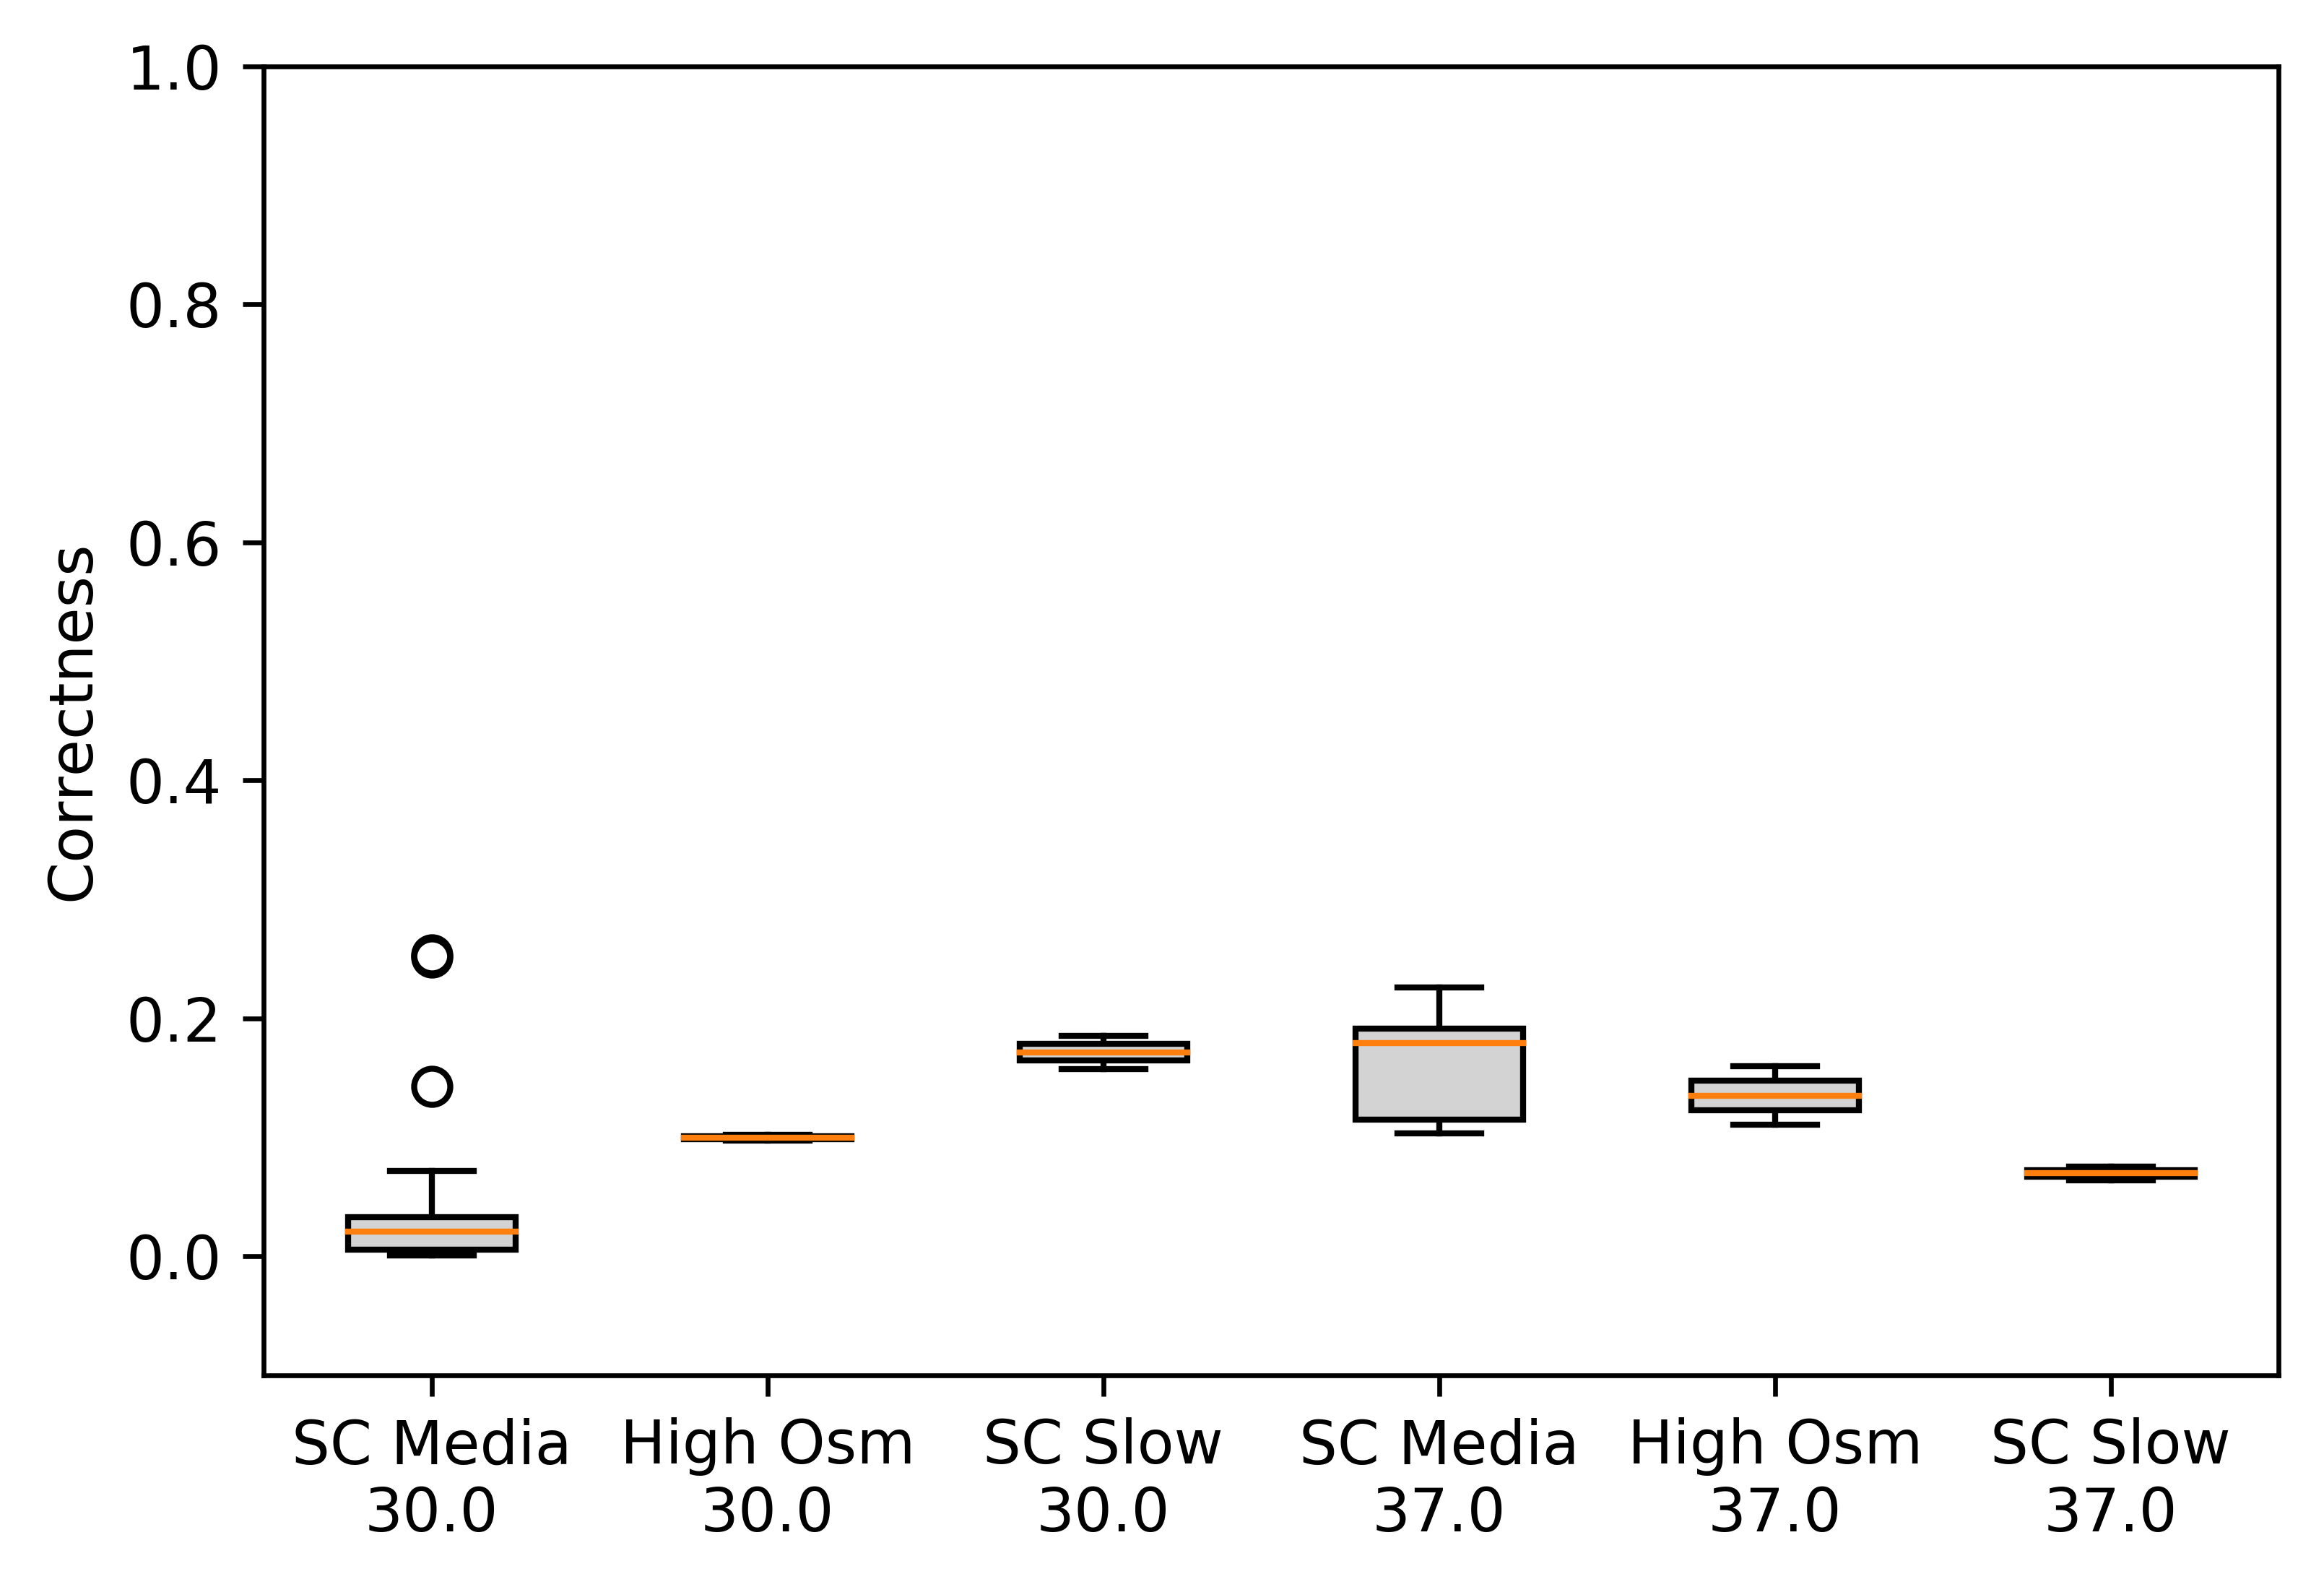

In [63]:
whisker("XOR",'mean_correct_classifier_live',cspd1)
whisker("XOR",'mean_correct_threshold_live',cspd2)

/Users/b37v456/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/b37v456/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/b37v456/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[('SC30', 0.04035156620749549), ('OSM30', 0.030676952685657732), ('SLOW30', nan), ('SC37', 0.04066482454893106), ('OSM37', 0.022984689521061776), ('SLOW37', 0.015295557398318485)]
[('SC30', 0.036473264149075646), ('OSM30', 0.017144608704196557), ('SLOW30', nan), ('SC37', 0.019991522039930706), ('OSM37', 0.005442252232490433), ('SLOW37', 0.013074224411376656)]


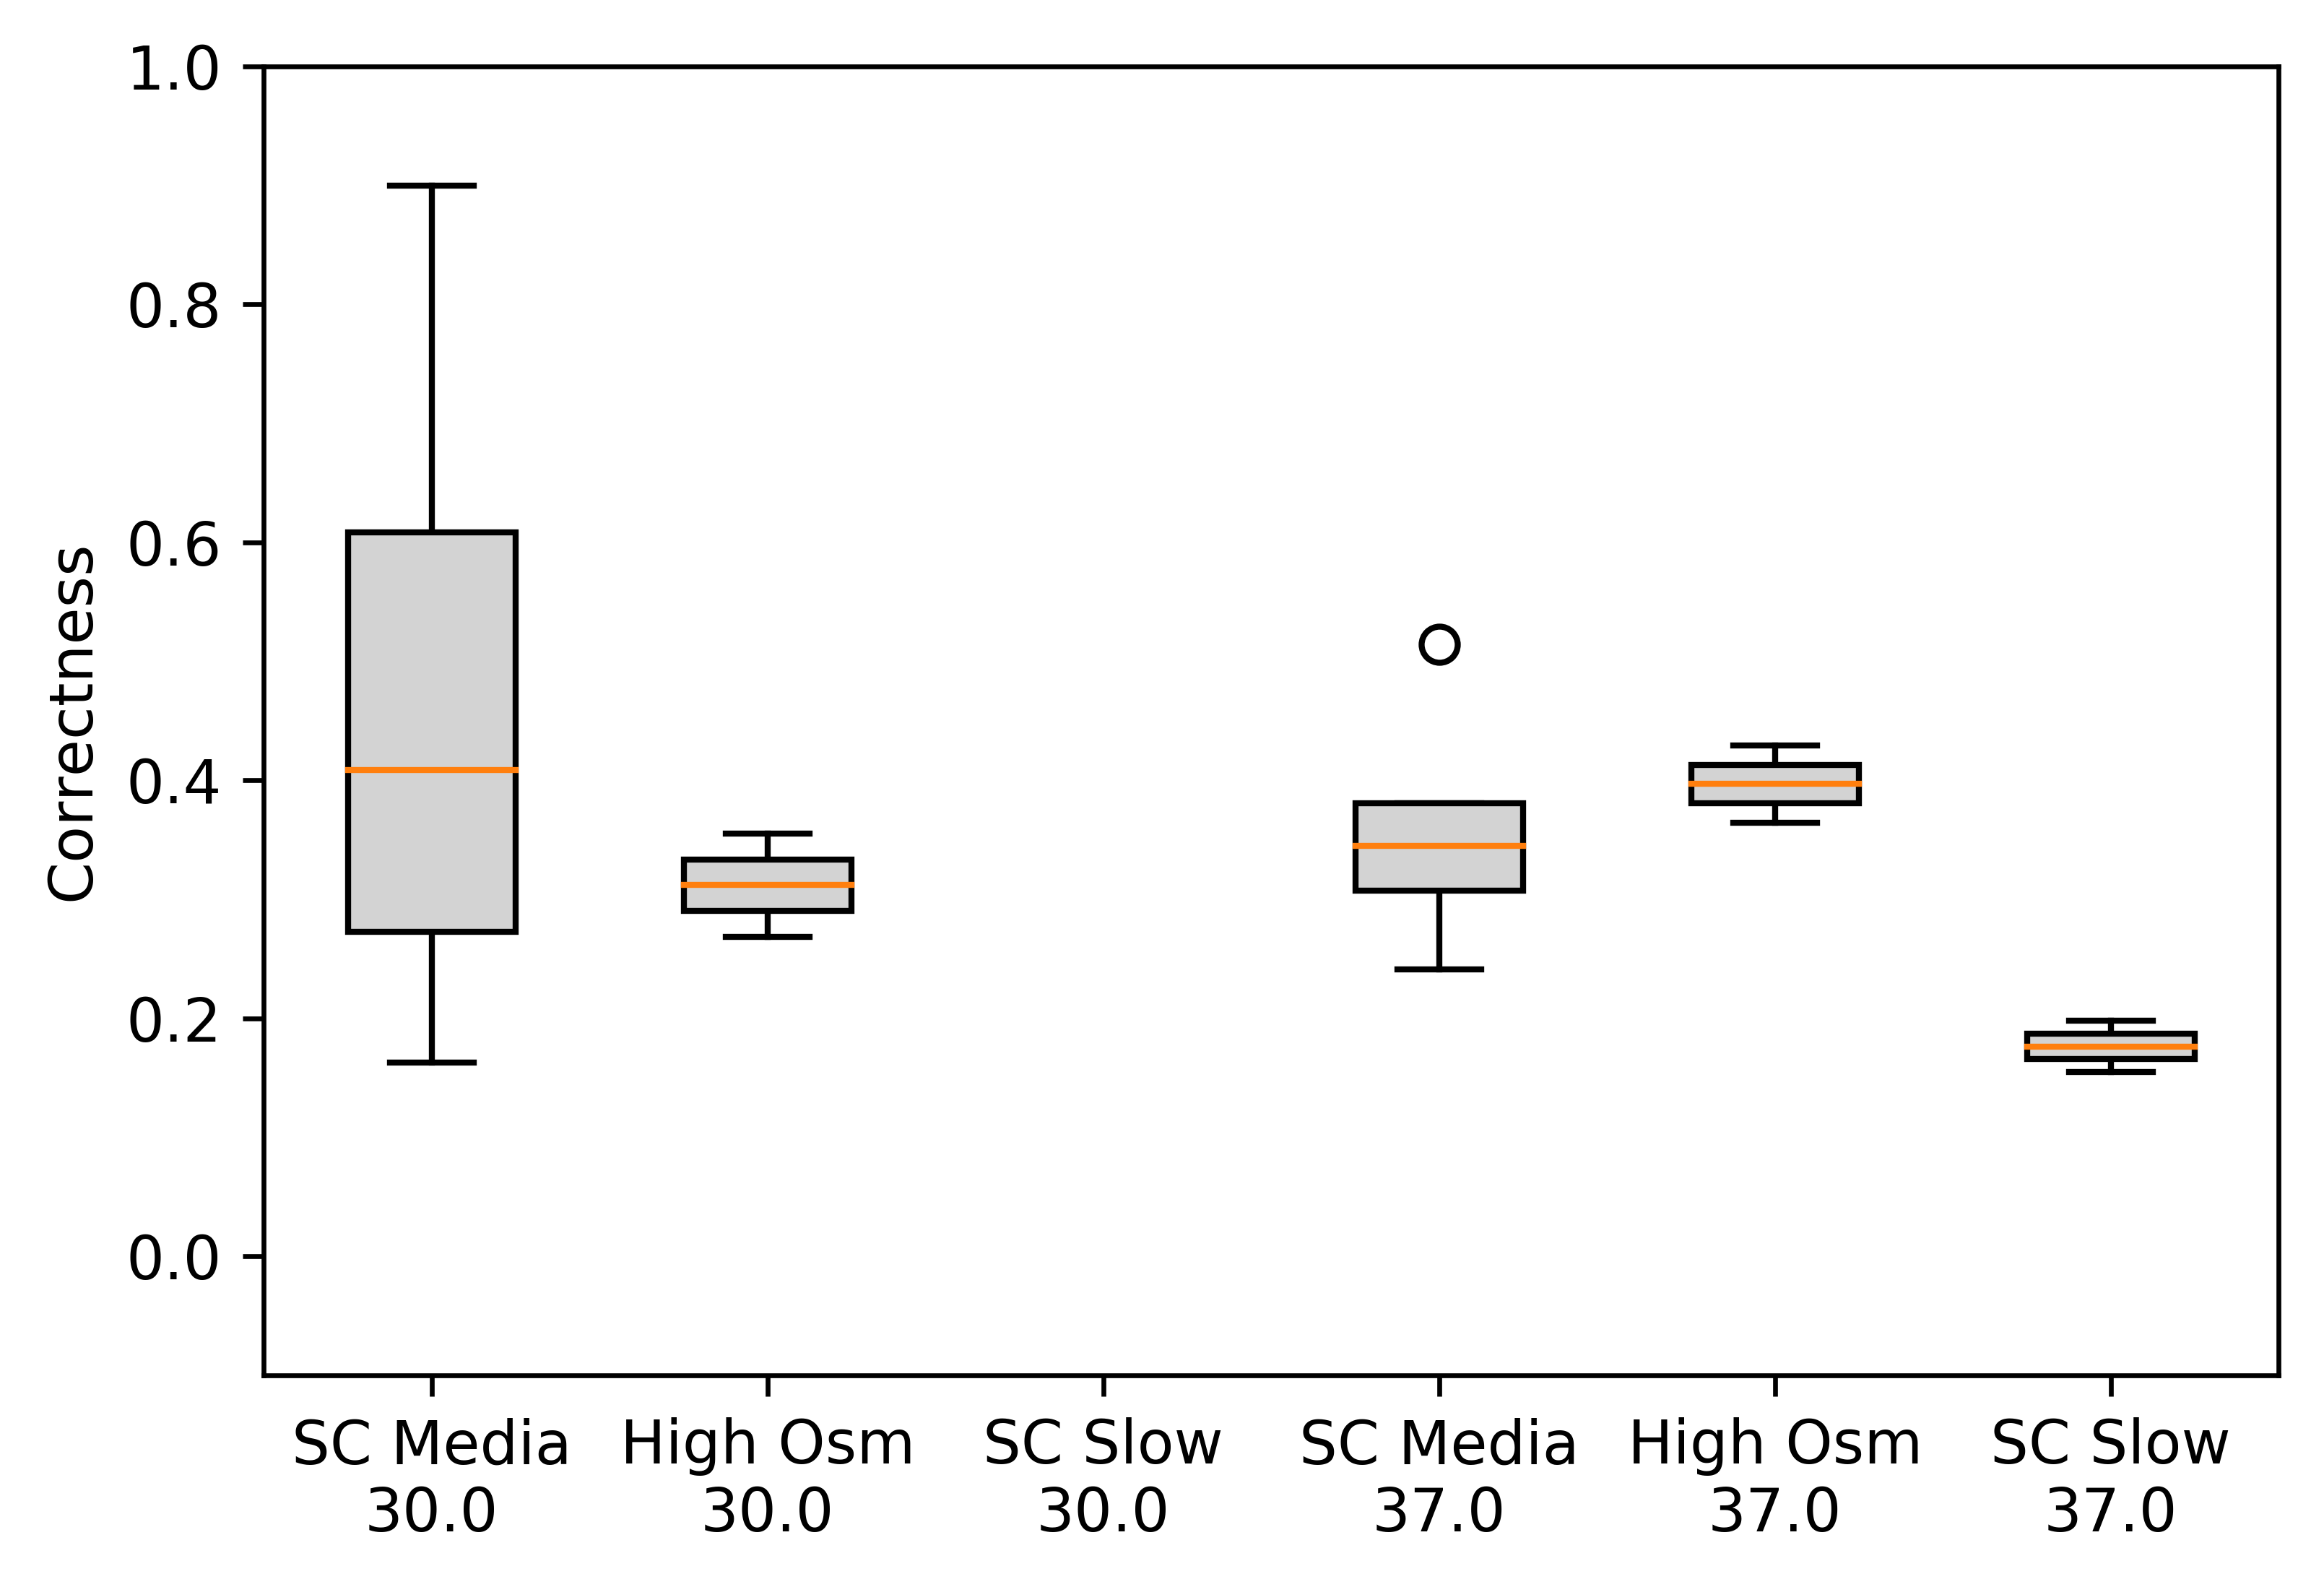

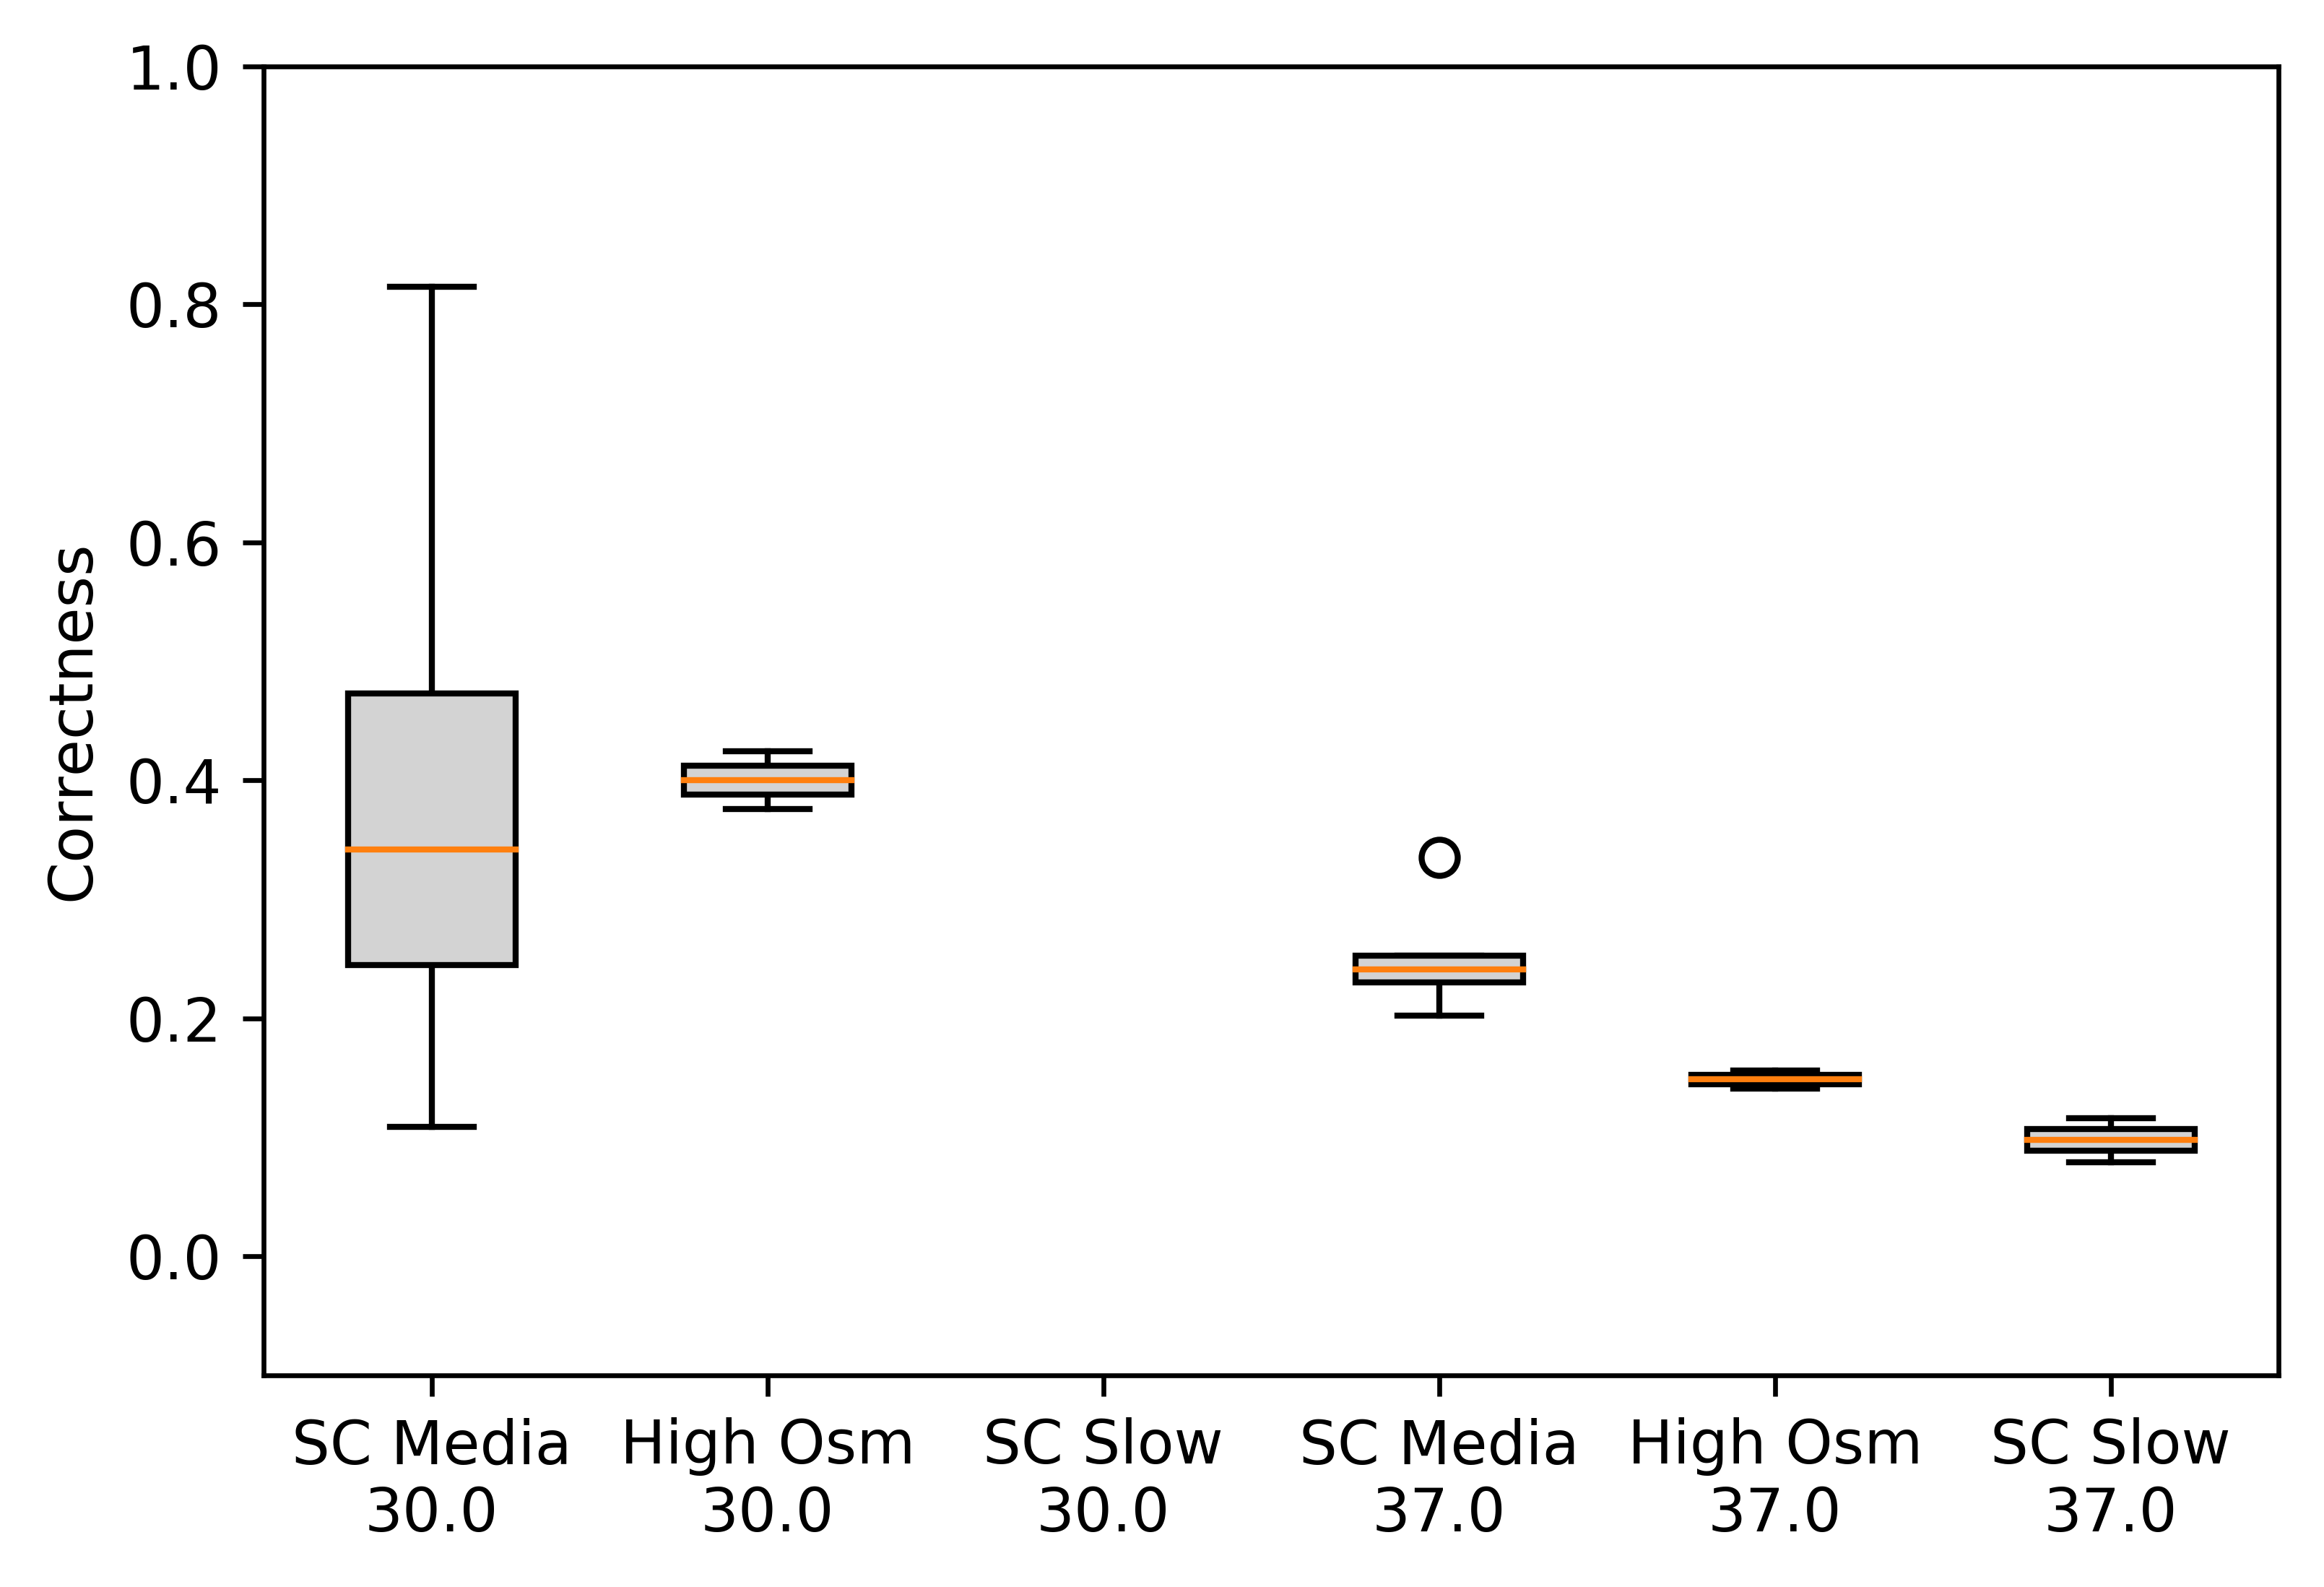

In [64]:
whisker("XNOR",'mean_correct_classifier_live',cspd1)
whisker("XNOR",'mean_correct_threshold_live',cspd2)

In [51]:
correctness_col2 = 'mean_correct_threshold_live'
circuit_score_df_prod_inc2 = cspd2.groupby(conditions2+['gate'])[correctness_col2].agg(np.mean).reset_index()
circuit_score_df_prod_od2 = circuit_score_df_prod_inc2.groupby(conditions3+['gate'])[correctness_col2].agg(np.mean).reset_index()
circuit_score_df_prod_od2_std = circuit_score_df_prod_inc2.groupby(conditions3+['gate'])[correctness_col2].agg(np.std).reset_index()
circuit_score_df_prod_od2.loc[:,"std"] = circuit_score_df_prod_od_std.loc[:,correctness_col2].values
circuit_score_df_prod_inc_temp = circuit_score_df_prod_od2.groupby(conditions3+['gate'])[correctness_col].agg(np.mean).reset_index()

circuit_score_df_prod_media_only = circuit_score_df_prod_inc_temp.groupby(['media','gate'])[correctness_col].agg(np.mean).reset_index()
circuit_score_df_prod_media_only.sort_values(by=[correctness_col])


KeyError: 'mean_correct_threshold_live'